# Project 6: Visualizing Monetary Policy

In this lecture, we will review the [Federal Reserve's balance sheet](https://fred.stlouisfed.org/release/tables?rid=20&eid=1194154&od=#) and review Fed activity in the overnight lending market, creating functions for visualizing relevant data in the process. We will  create a *plots.py* file class that will include some of the visualization functions from chapters 5 and 6, as well as some new visualizations that we will create in this lesson.

Let's get started by reconstructing the scatter plot function from  chapter 6. For this project, we will represent the time period with color. Make sure to save plot functions and functions to download data from FRED in separate files using *Spyder*. Save them in a folder named *datlib*. This folder must be in the same directory as this notebook. We will import that folder (package). The name of the appropriate file is included in the first line of each file.

In [1]:
#plots.py
# !pip install pandas-datareader
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

def plot_ts_scatter(data, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    df = data.copy()
    for var1 in df:
        for var2 in df:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

Now that we have saved these classes in *.py* files, we will import these files as to plot data from the [Federal Reserve](https://research.stlouisfed.org/). First, let's create a script name *FRED.py* that imports data from FRED using *pandas*.

In [2]:
#FRED.py
import pandas as pd
import pandas_datareader.data as web
import datetime

def gather_data(data_codes, 
                start, 
                end = datetime.datetime.today(), 
                freq = "M"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(
                val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            # setting i to None will cause the next block of code to execute,
            # placing data within df instead of creating a new dataframe for
            # each variable
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()

    return df

We have now saved all of the classes that will be included in the *datlib* package. Import the *datlib* and use the FRED module to download data from FRED. Let's start by gathering data reflecting the monetary base and currency in circulation.

In [3]:
#fedProject.py
#from datlib.stats import *
from datlib.plots import * 
from datlib.FRED import *
data_codes  = {"Base: Total": "BOGMBASEW",
               "Base: Currency in Circulation": "WCURCIR"}
# Select start and end dates
start = datetime.datetime(2002, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
data = gather_data(data_codes = data_codes, start = start, end = end, freq = "W")

In [4]:
data.iloc[:15]

Base: Total  Base: Currency in Circulation
DATE                                                  
2002-01-06     659930.0                        643.044
2002-01-13     659930.0                        638.956
2002-01-20     652179.0                        632.719
2002-01-27     652179.0                        632.017
2002-02-03     649587.0                        630.409
2002-02-10     649587.0                        631.843
2002-02-17     655271.0                        635.017
2002-02-24     655271.0                        638.840
2002-03-03     657321.0                        637.836
2002-03-10     657321.0                        638.543
2002-03-17     657943.0                        639.616
2002-03-24     657943.0                        640.023
2002-03-31     661137.0                        640.608
2002-04-07     661137.0                        642.930
2002-04-14     663255.0                        644.043

## Breaking down the Federal Reserve's balance sheet

Now that we have an idea of how to gather and organize data from FRED, let's download data that reflects the balance sheet of the Federal Reserve.

Like any balance sheet, the Federal Reserve's balance sheet is comprised of assets and liabilities. A bank holds assets that earn some return. For example, the Federal Reserve earns interest on Treasuries that it is holding. Liabilities on the balance sheet indicate cases where the Federal Reserve owes funds to holders of offsetting assets (except in the case of Federal Reserve Notes Outstanding). Some banks hold deposit accounts that hold excess reserves with the Federal Reserve. Likewise, the U.S. Treasury holds unspent funds in an account at the Federal Reserve. The Federal Reserve must repay these funds and often will pay interest on these accounts.

We will download many of the largest categories of the Fed's assets and liabilities and build functions to visualize them over time.

Not all data gathered will is provided in units of millions of dollars. As we download other data from FRED, we will find that most data is saved in terms of millions or billions of dollars. We will want to standardize units so that all measurements are in millions. 

Add the following function to convert units from billions to millions. We will create a function to transform units in the FRED.py file. Then we will create a list of variables to pass to that function. 

In [5]:
#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3

We will use the bil_to_mil() function to transform data reflecting total reserves as well as other deposits from billions to millions of dollars.

In [6]:
#fedProject.py
# . . .
data_codes  = {"Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Mil)": "WCURCIR",
               # Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Excess Reserves ($ Mil)": "EXCSRESNW",
               "Balance Sheet: Required Reserves ($ Mil)": "RESBALREQW",
               "Balance Sheet: Total Reserves ($ Mil)": "WRESBAL",
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Interest Rates
               "Federal Funds Target (Pre-Crisis)": "DFEDTAR",
               "Federal Funds (Upper) Target":"DFEDTARU",
               "Effective Federal Funds Rate":"DFF",
               "Interest on Excess Reserves":"IOER",
               "Interest on Reserve Balances":"IORB",

               # Req Reserves and Vault Cash
               "Vault Cash ($ Mil)": "TLVAULTW",
               "Vault Cash Used as Req. ($ Mil)": "VAULT",
               }
               
# Select start and end dates
start = datetime.datetime(2002, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
data = gather_data(data_codes = data_codes, start = start, 
                   end = end, freq = "W")
data["Interest on Reserves"] = data["Interest on Excess Reserves"].fillna(0).add(data["Interest on Reserve Balances"].fillna(0))
bil_to_mil_list  = ["Balance Sheet: Total Reserves ($ Mil)",
                    "Balance Sheet: Other Deposits ($ Mil)",
                    "Base: Currency in Circulation ($ Mil)"]
for key in bil_to_mil_list:
    data[key] = bil_to_mil(data[key])

In [7]:
data

Base: Total ($ Mil)  Base: Currency in Circulation ($ Mil)  \
DATE                                                                     
2002-01-06             653800.0                               643044.0   
2002-01-13                  NaN                               638956.0   
2002-01-20                  NaN                               632719.0   
2002-01-27                  NaN                               632017.0   
2002-02-03             654600.0                               630409.0   
...                         ...                                    ...   
2022-11-06            5418700.0                              2284599.0   
2022-11-13                  NaN                              2288188.0   
2022-11-20                  NaN                              2293401.0   
2022-11-27                  NaN                              2293562.0   
2022-12-04            5405400.0                              2297330.0   

            Balance Sheet: Total Assets ($ Mil)  \
DATE                                              
2002-01-06                                  NaN   
2002-01-13                                  NaN   
2002-01-20                                  NaN   
2002-01-27                                  NaN   
2002-02-03                                  NaN   
...                                         ...   
2022-11-06                            8676870.0   
2022-11-13                            8678886.0   
2022-11-20                            8625620.0   
2022-11-27                            8621390.0   
2022-12-04                            8584576.0   

            Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)  \
DATE                                                                        
2002-01-06                                                NaN               
2002-01-13                                                NaN               
2002-01-20                                                NaN               
2002-01-27                                                NaN               
2002-02-03                                                NaN               
...                                                       ...               
2022-11-06                                          8566631.0               
2022-11-13                                          8565174.0               
2022-11-20                                          8526413.0               
2022-11-27                                          8522164.0               
2022-12-04                                          8489074.0               

            Balance Sheet: Securities Held Outright ($ Mil)  \
DATE                                                          
2002-01-06                                              NaN   
2002-01-13                                              NaN   
2002-01-20                                              NaN   
2002-01-27                                              NaN   
2002-02-03                                              NaN   
...                                                     ...   
2022-11-06                                        8255836.0   
2022-11-13                                        8256104.0   
2022-11-20                                        8214279.0   
2022-11-27                                        8209753.0   
2022-12-04                                        8177087.0   

            Balance Sheet: U.S. Treasuries Held Outright ($ Mil)  \
DATE                                                               
2002-01-06                                                NaN      
2002-01-13                                                NaN      
2002-01-20                                                NaN      
2002-01-27                                                NaN      
2002-02-03                                                NaN      
...                                                       ...      
2022-11-06         

Whenever the Federal Reserve acquires an asset, it must also acquire a liability. For much of the history of central banking, an increase in assets was enabled by the creation and distribution of base money. If the central bank provides a loan or purchases an existing debt instrument, new base money would enter circulation. Or, the money might support overnight, interbank lending, in which case, the ability of monetary expansion to postively affect the volume of circulating cash is, under normal circumatances, limited. 

Our breakdown of the Federal Reserve's balance sheet will navigate the distinction between 

1. the portion of the monetary base supporting lending within the economy
2. the portion of the monetary base deposited at the Federal Reserve
3. assets and liabilities that influence the level of overnight lending but are explicitly *not* counted as part of the monetary base.

The remaining portion of the liabilities represents less than 1 percent of the total value of its liabilities.

We will break down the balance sheet into its different components and then will reconstruct it in whole. First, let's build a function to plot lines and save that function in *plots.py*. We will build this function one bit at a time.

In [8]:
#plots.py
# . . .
from matplotlib.backends.backend_pdf import PdfPages
def plot_lines(df, 
               linewidth = 1, 
               figsize = (40,20),
               secondary_y = None, 
               legend=True, 
               pp = None, 
               save_fig = False):
    
    fig, ax = plt.subplots(figsize = figsize)    
    # If no secondary_y (axis), plot all variables at once
    df.dropna(axis = 0, how = "all").plot.line(
        linewidth = linewidth, 
        ax = ax, 
        secondary_y=secondary_y, 
        legend = legend)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals]) 
    
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")  
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + filename[:50] + " line.png", 
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")



Let's call the function. First, let's plot all of the variables associated with the balance sheet. 

C:\Users\JLCat\AppData\Local\Temp\ipykernel_5444\1524566044.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


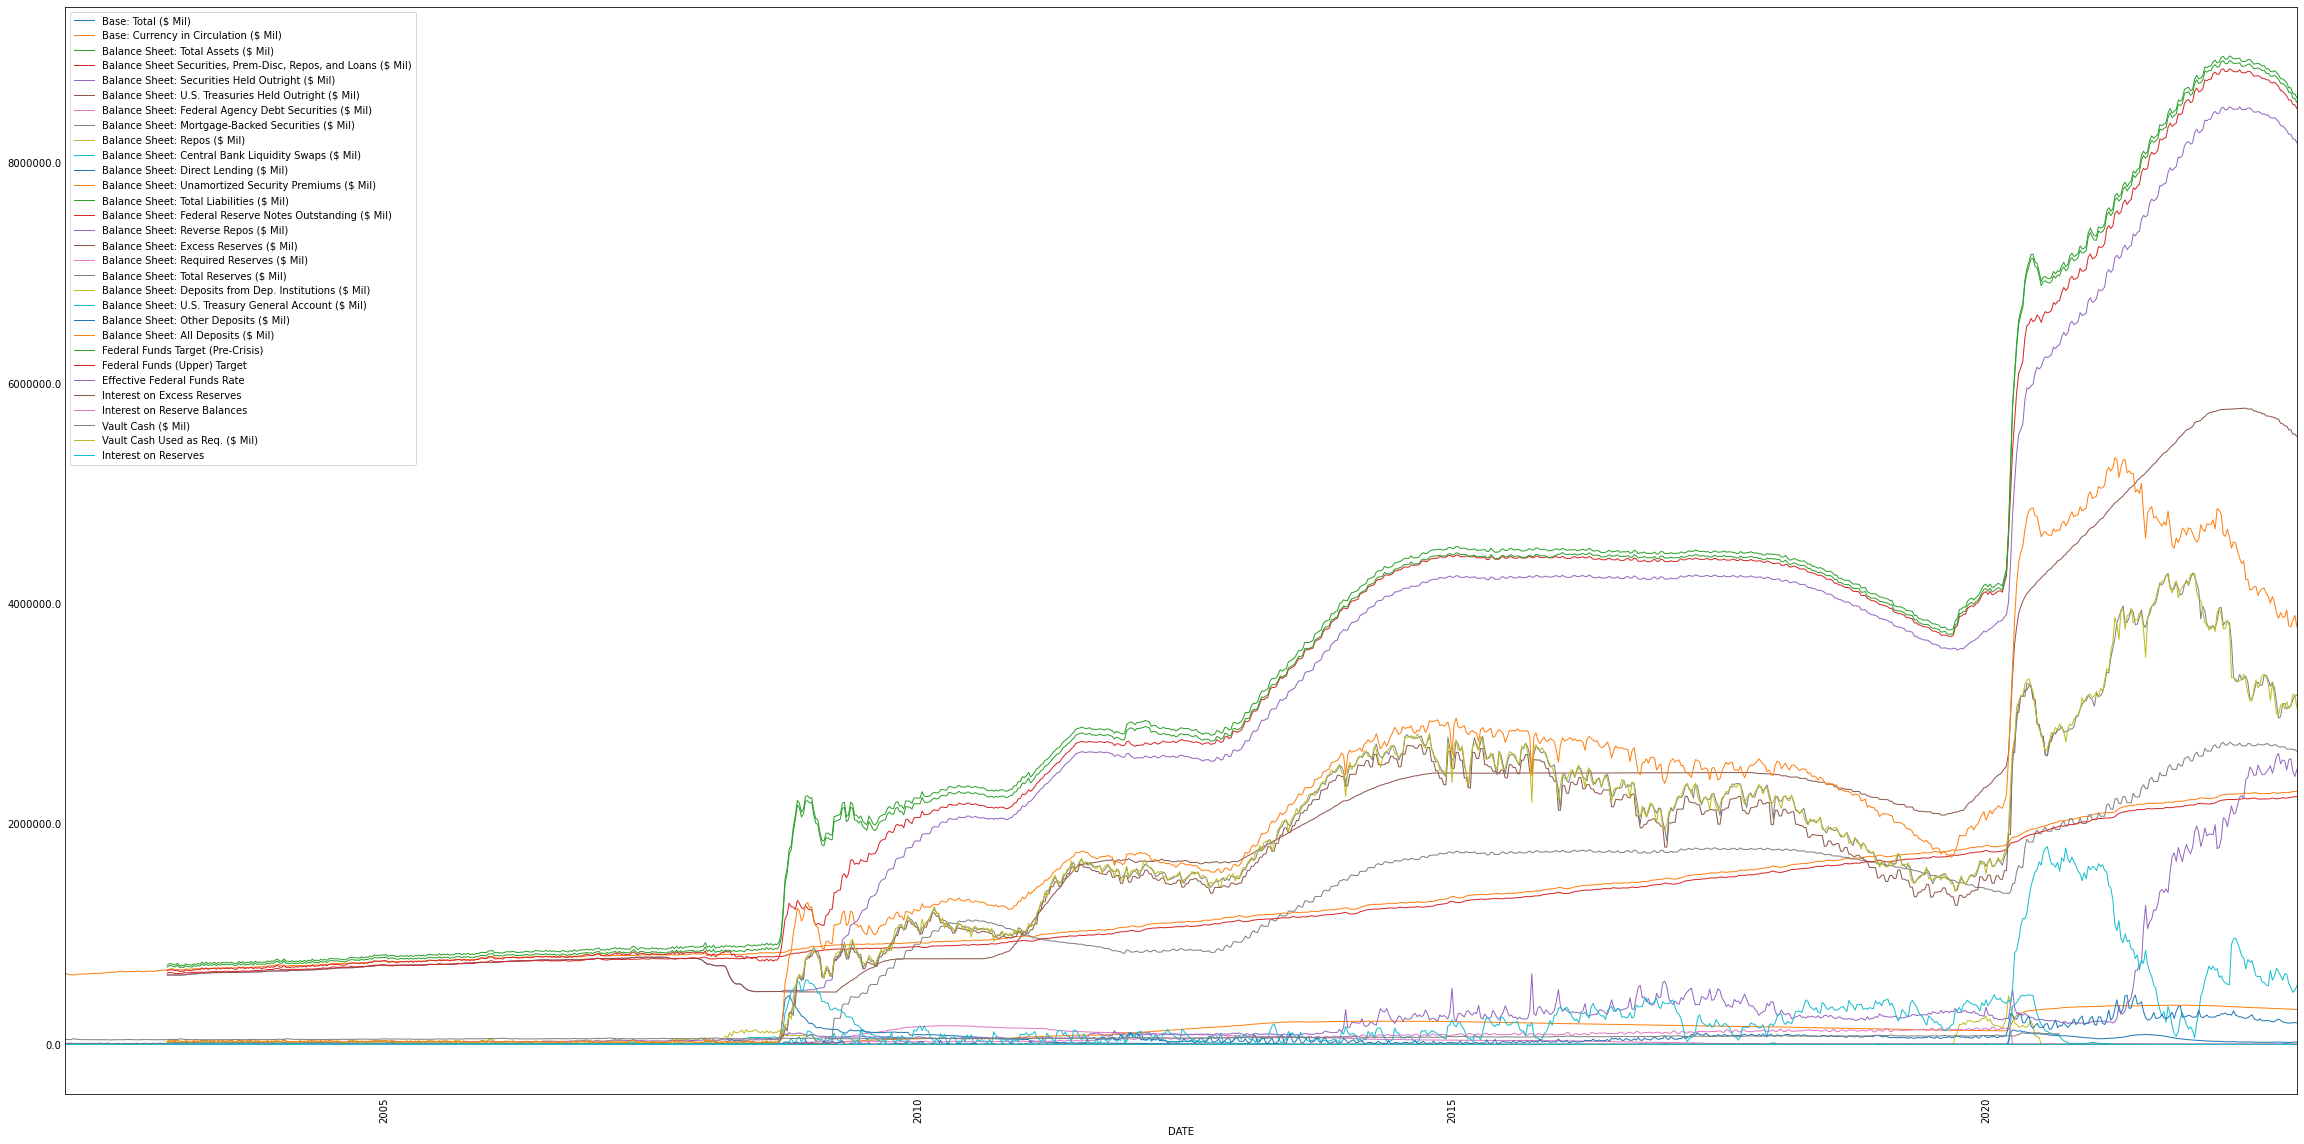

In [9]:
#fedProject.py
#. . . 
plot_lines(df = data, linewidth = 1, figsize = (40, 20), pp = None)


We've plotted all assets and liabilities together. The result is a visualization that is not easy to interpret. Further, there are numerous categories to evaluate. Axis and legend text are too small to read without squinting. 

Let's remedy these problems by concentrating on only a few variables related to the monetary base and increas the size of the text.

C:\Users\JLCat\AppData\Local\Temp\ipykernel_5444\1524566044.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


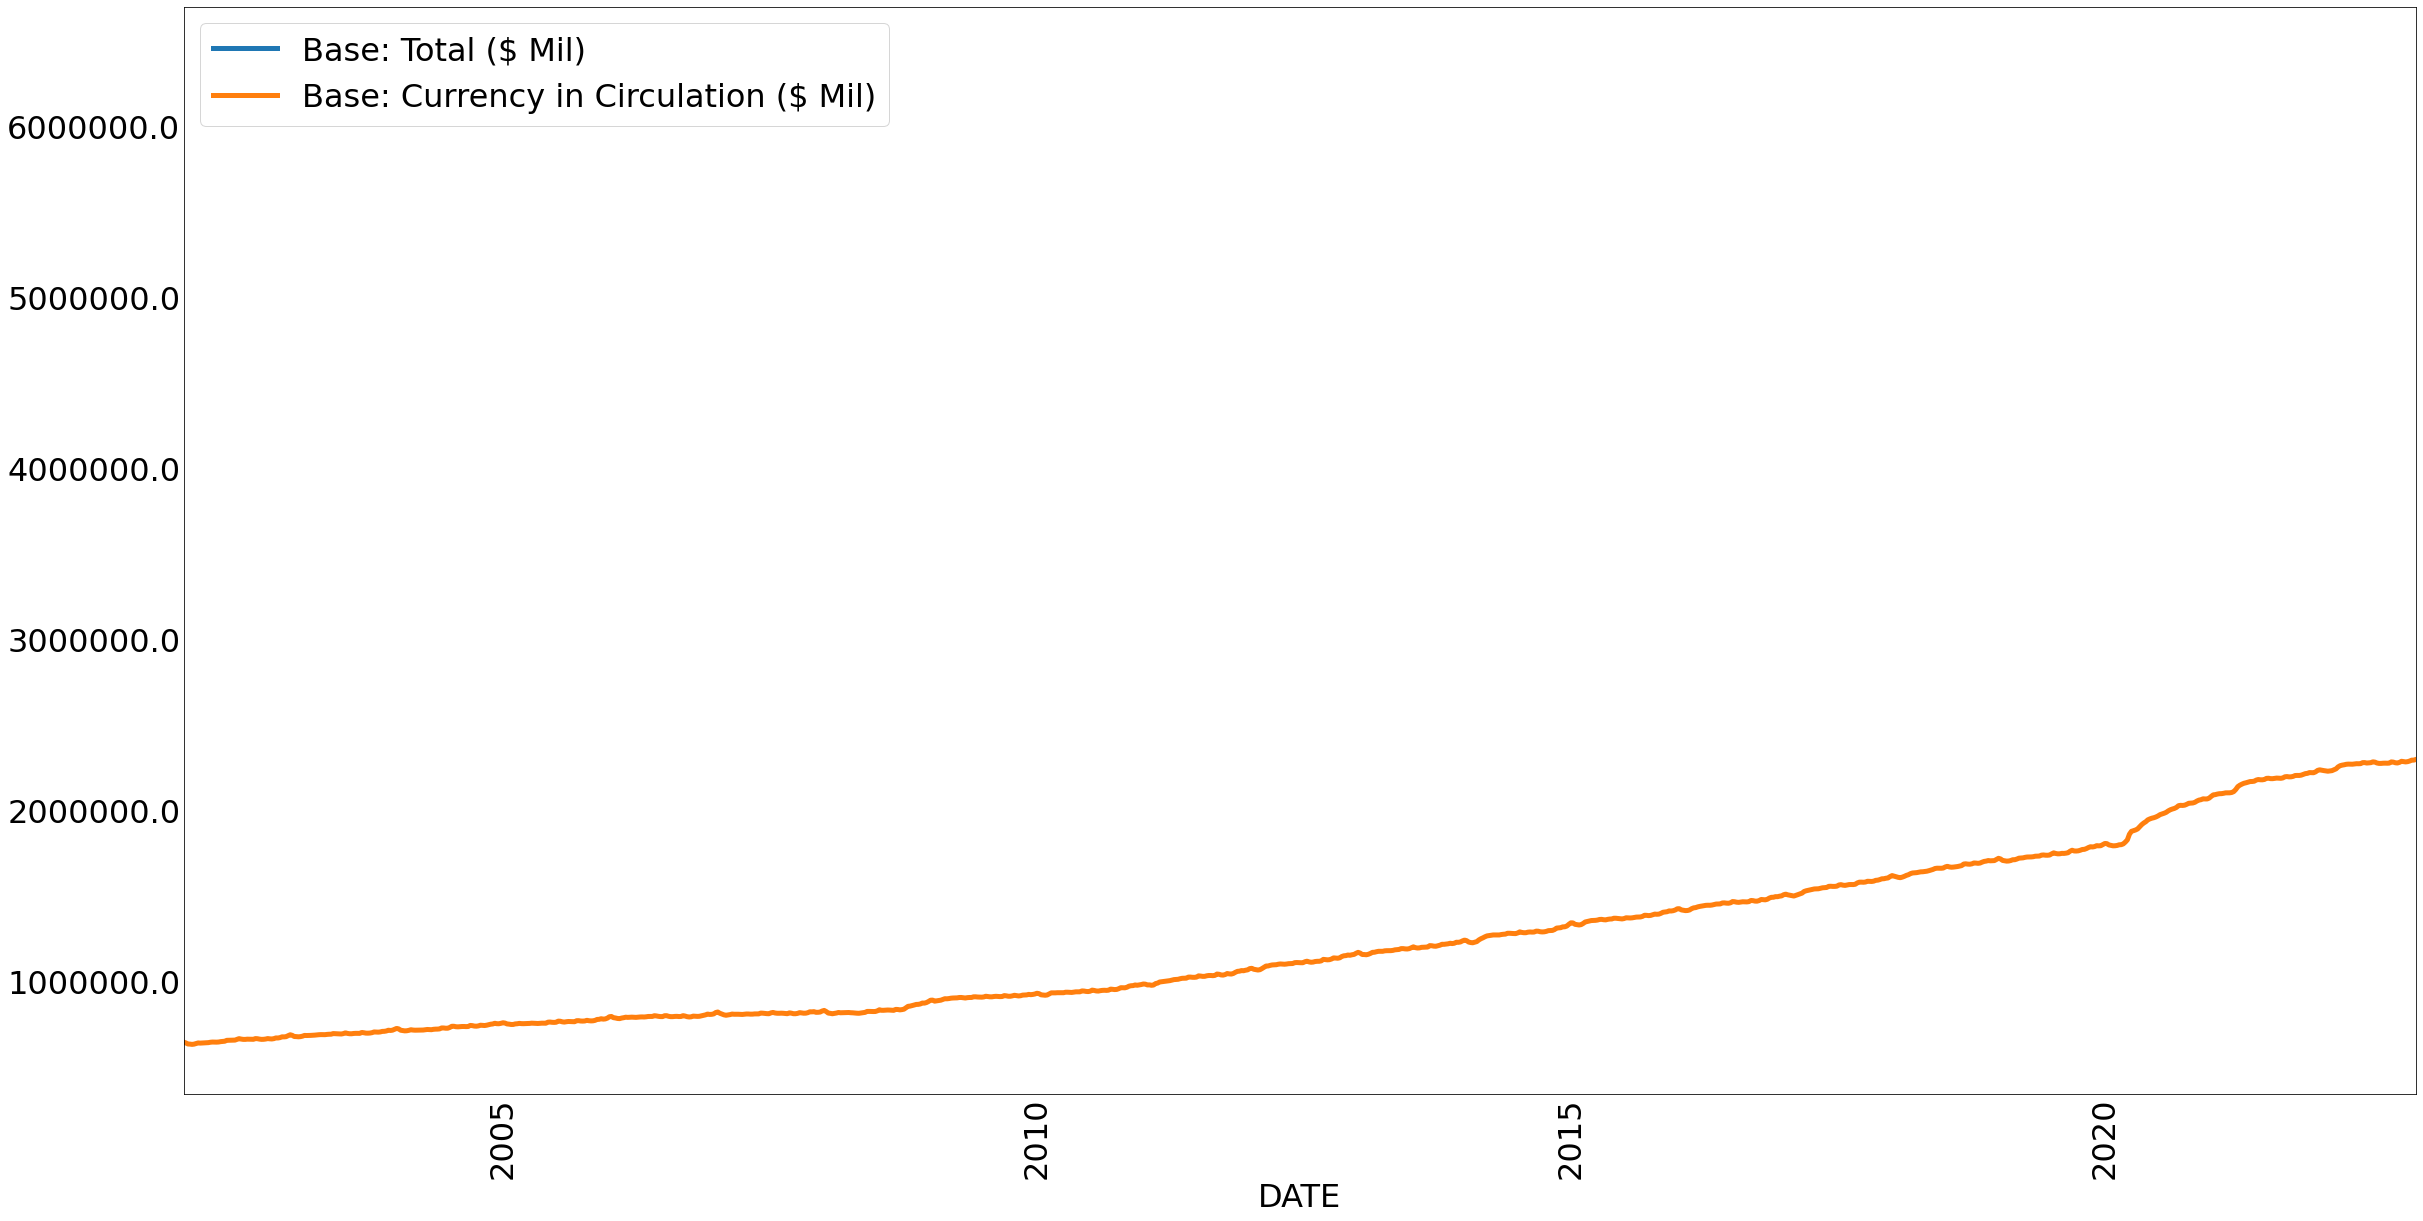

In [10]:
#fedProject.py
plt.rcParams.update({"font.size":32})
money_vars = ["Base: Total ($ Mil)",
              "Base: Currency in Circulation ($ Mil)"]
plot_lines(df = data[money_vars], linewidth = 5, figsize = (40, 20), pp = None)

### Monetary base

The total monetary base can be described in terms of its support of lending within the economy.  The remainder of the base is held at the Federal Reserve without supporting additional lending. We will plot the total quantity of base money, and then break down this amount between base money that is and is not deposited at the Federal Reserve. We will observe that a radical change in monetary policy in 2008 led to an unprecedented increase in the portion of the base deposited at the Federal Reserve. 

From the plot, we observe that, before 2008, nearly the entire stock of base money was in circulation. After 2008, it is common for much, if not most, of the base to lie outside of circulation. In essence, the Federal Reserve borrows money from banks, paying them a risk free rate of interest. If we add a 3rd variable to the visualization, we can identify a significant portion of the stock of base money not in circulation as excess reserves.

C:\Users\JLCat\AppData\Local\Temp\ipykernel_5444\1524566044.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


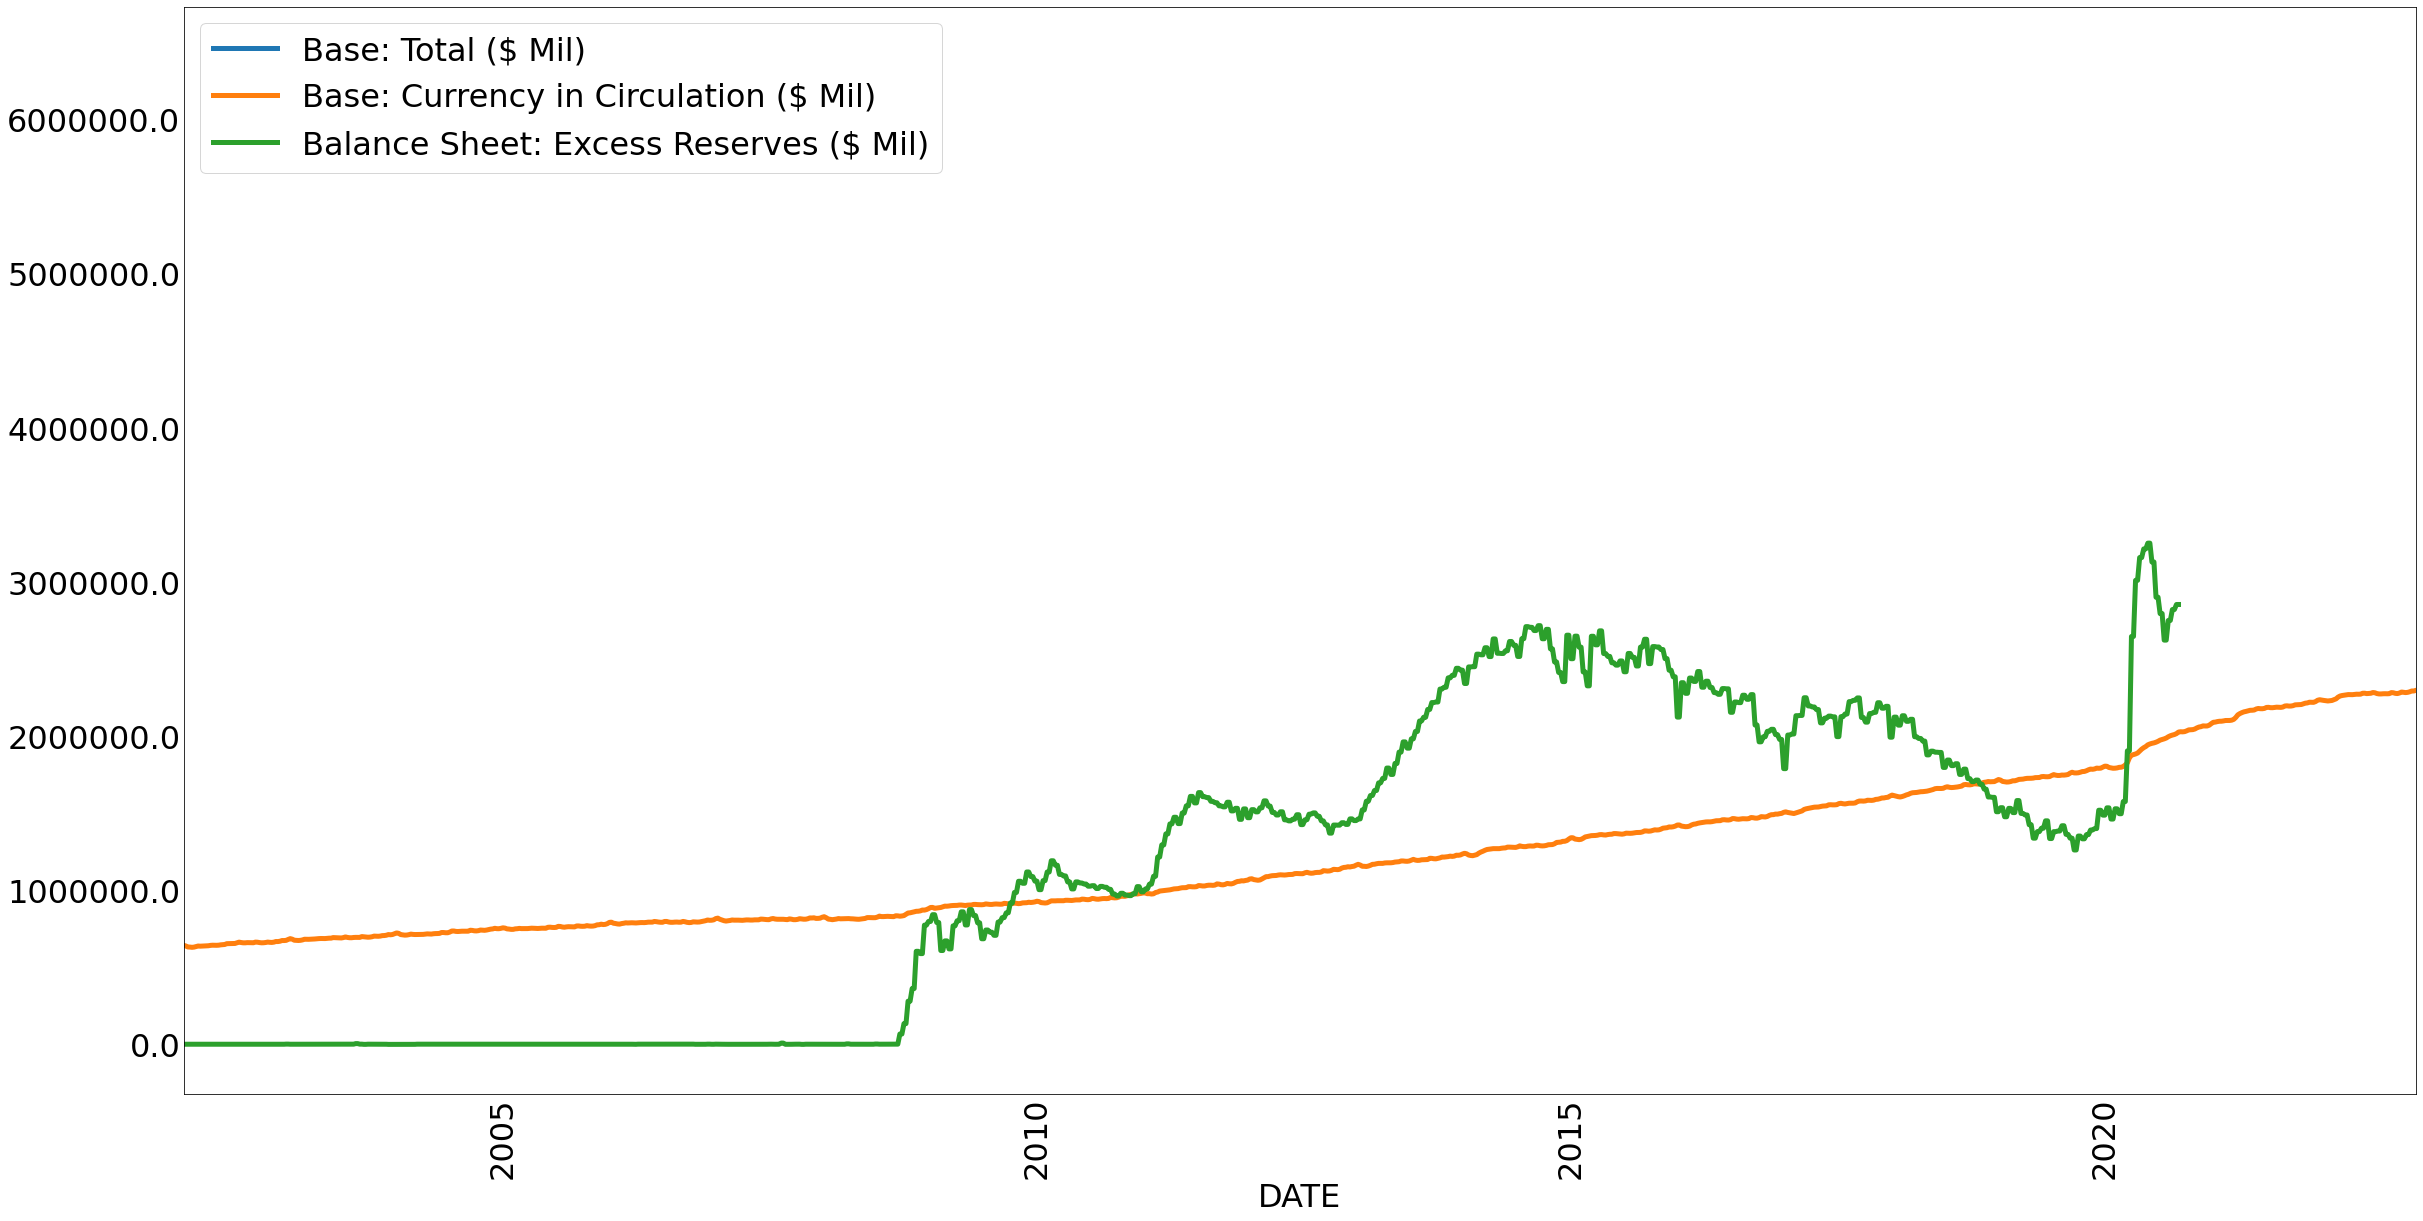

In [11]:
#fedProject.py
plt.rcParams.update({"font.size":32})
money_vars = ["Base: Total ($ Mil)",
              "Base: Currency in Circulation ($ Mil)",
              "Balance Sheet: Excess Reserves ($ Mil)"]
plot_lines(df = data[money_vars], linewidth = 5, figsize = (40, 20), pp = None)

### Stacking Lines 
It would be useful if we could view these components as portions of the total stock of base money. To accomplish this, we need to create a new function in plots. This function will stack the values plotted instead of plotting the values independent of one another.

In [ ]:
bil_to_mil_list  = ["Balance Sheet: Total Reserves ($ Mil)",
                    "Balance Sheet: Other Deposits ($ Mil)",
                    "Base: Currency in Circulation ($ Mil)"]
for key in bil_to_mil_list:
    data[key] = data[key].mul(10 ** 3)

In [12]:
#plots.py
# . . .
def plot_stacked_lines(df, 
                       plot_vars, 
                       linewidth = 1, 
                       figsize = (40,20), 
                       pp = None, 
                       total_var = False):
    fig, ax = plt.subplots(figsize = figsize)
    df[plot_vars].plot.area(stacked = True, 
                            linewidth = linewidth,
                            ax = ax)
    # change y vals from mil to tril
    
    if total_var != False:
        df[total_var].plot.line(
            linewidth = linewidth, 
            ax = ax, 
            c = "k",
            label = total_var, 
            ls = "--")
    ax.legend(loc=2, ncol = 2)

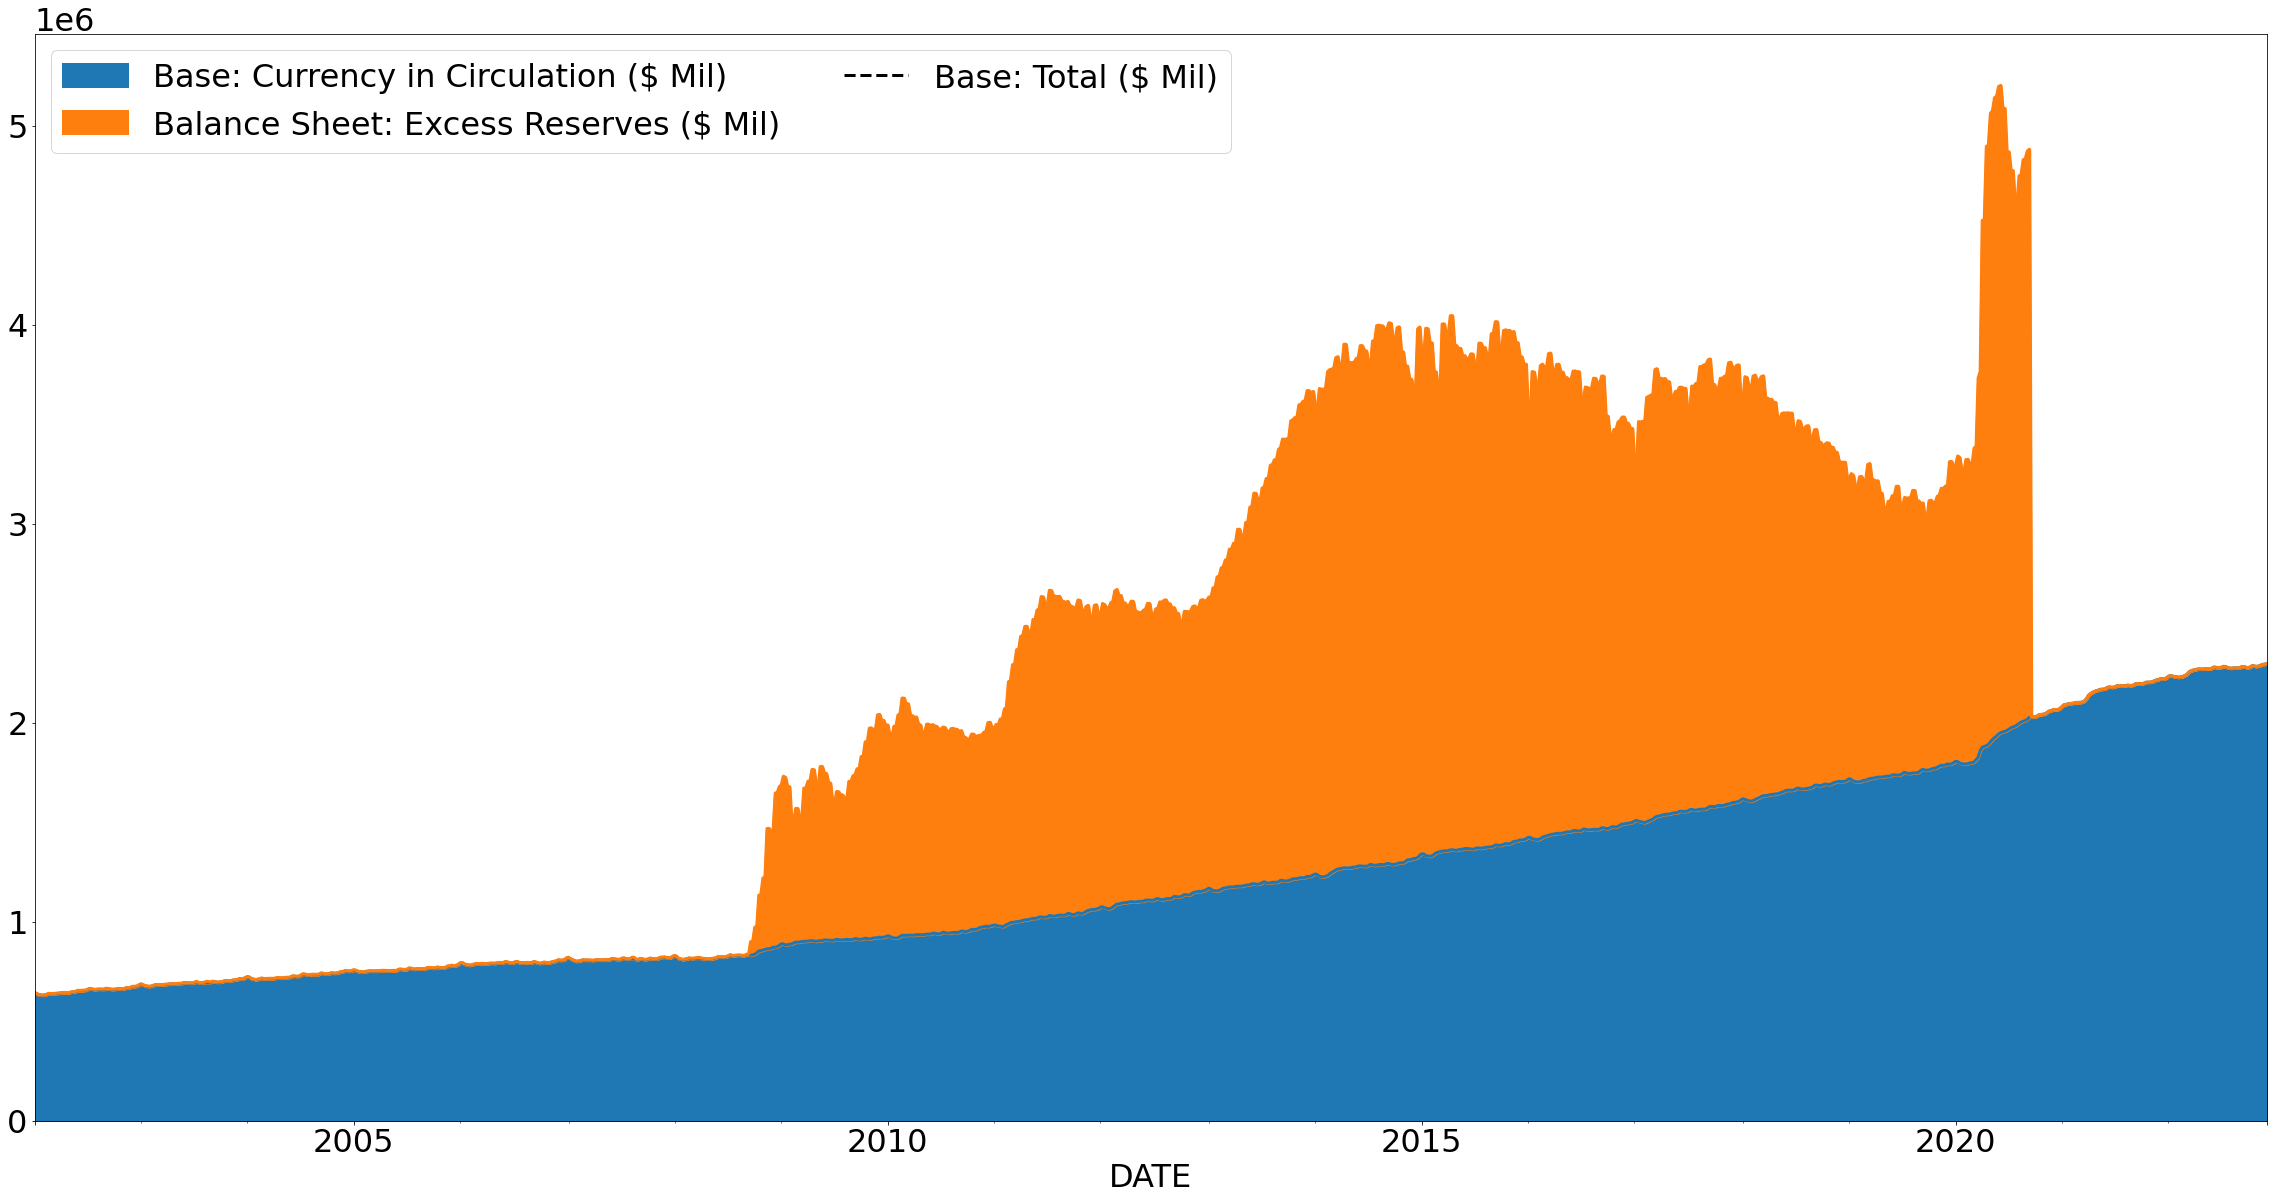

In [13]:
#fedProject
# . . . 
money_vars = ["Base: Currency in Circulation ($ Mil)",
              "Balance Sheet: Excess Reserves ($ Mil)"]

plot_stacked_lines(data, 
                   money_vars, 
                   linewidth = 3,
                   total_var = "Base: Total ($ Mil)")

We can see that the monetary base is almost entirely divided between currency in circulation and money deposited on account as excess reserves at the Fed. The missing portion of the base in this graph is the quantity of required reserves held at the Federal Reserve. This excludes the value of required reserves held as vault cash.

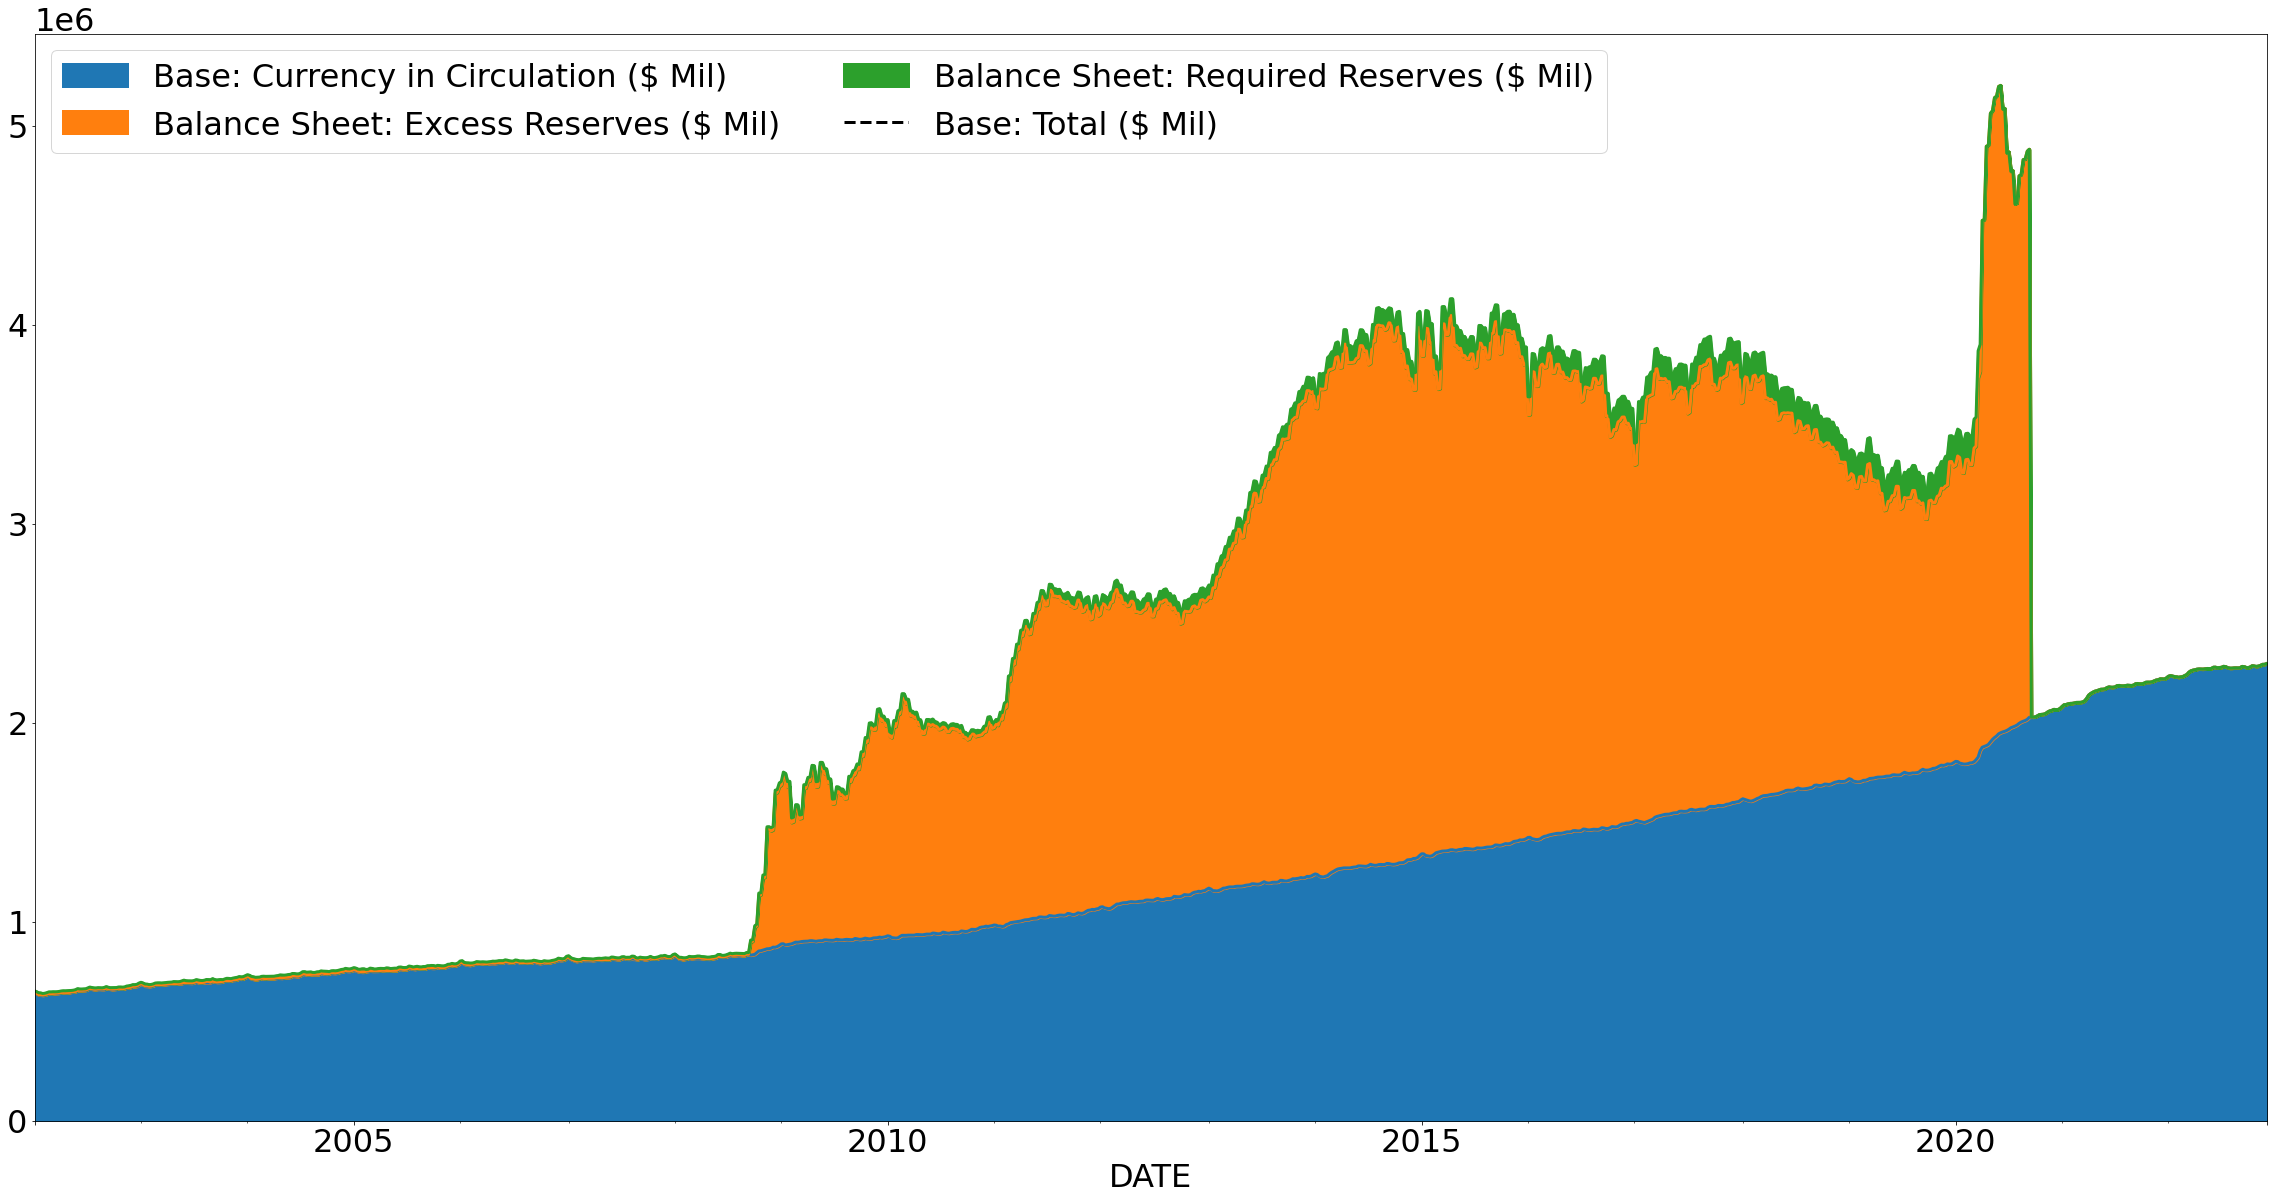

In [14]:
reserve_vars = ["Base: Currency in Circulation ($ Mil)",
             "Balance Sheet: Excess Reserves ($ Mil)",
             "Balance Sheet: Required Reserves ($ Mil)"]
plot_stacked_lines(data, reserve_vars, linewidth = 3, total_var = "Base: Total ($ Mil)")

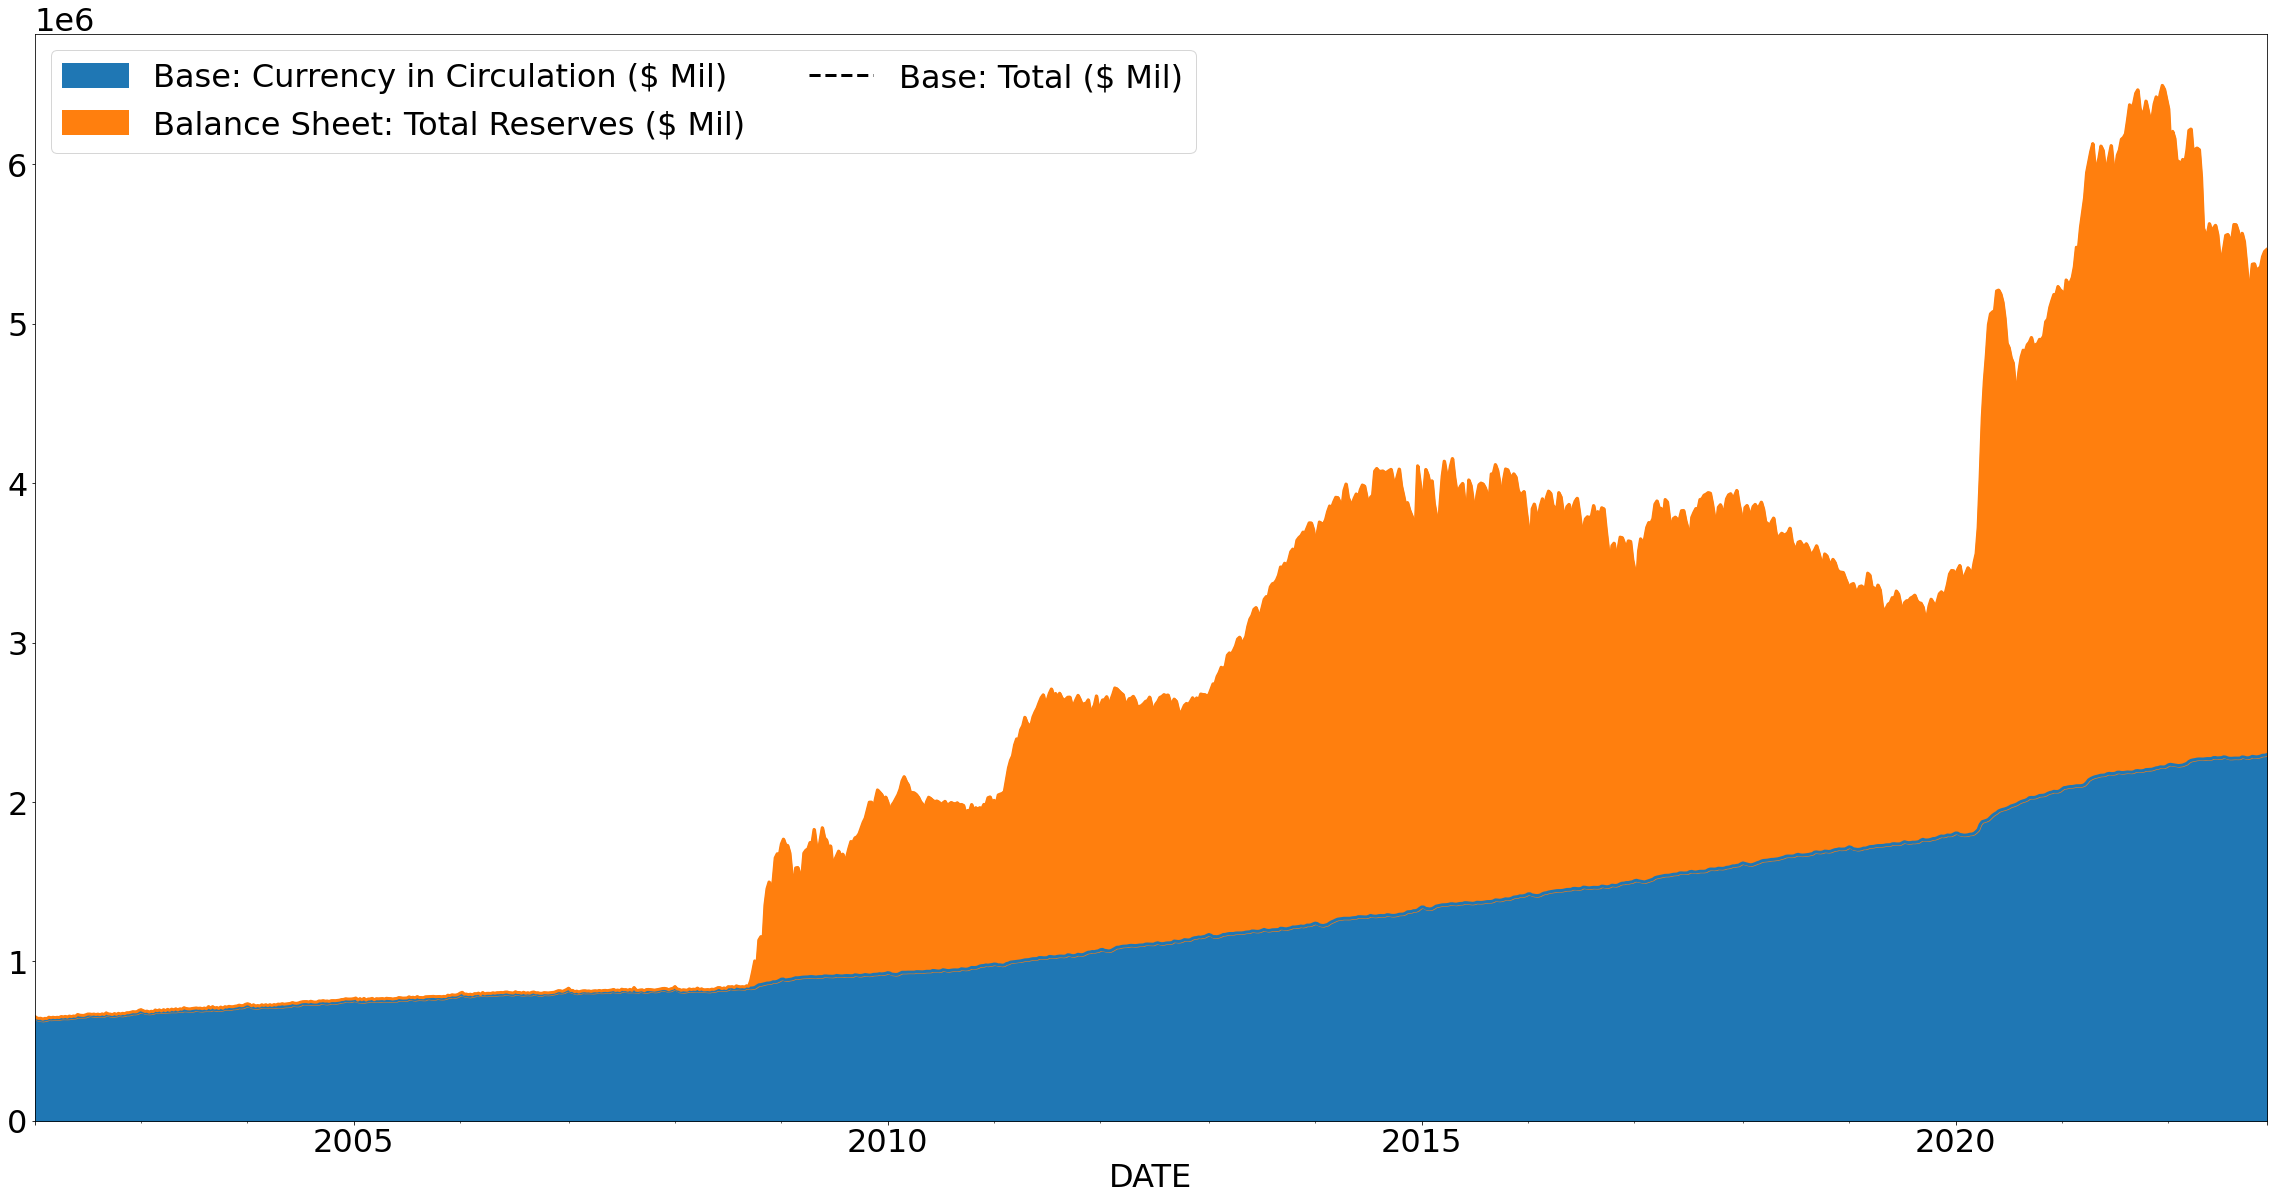

In [15]:
reserve_vars = ["Base: Currency in Circulation ($ Mil)",
             "Balance Sheet: Total Reserves ($ Mil)"]
plot_stacked_lines(data, reserve_vars, linewidth = 3, total_var = "Base: Total ($ Mil)")



C:\Users\JLCat\AppData\Local\Temp\ipykernel_5444\1524566044.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


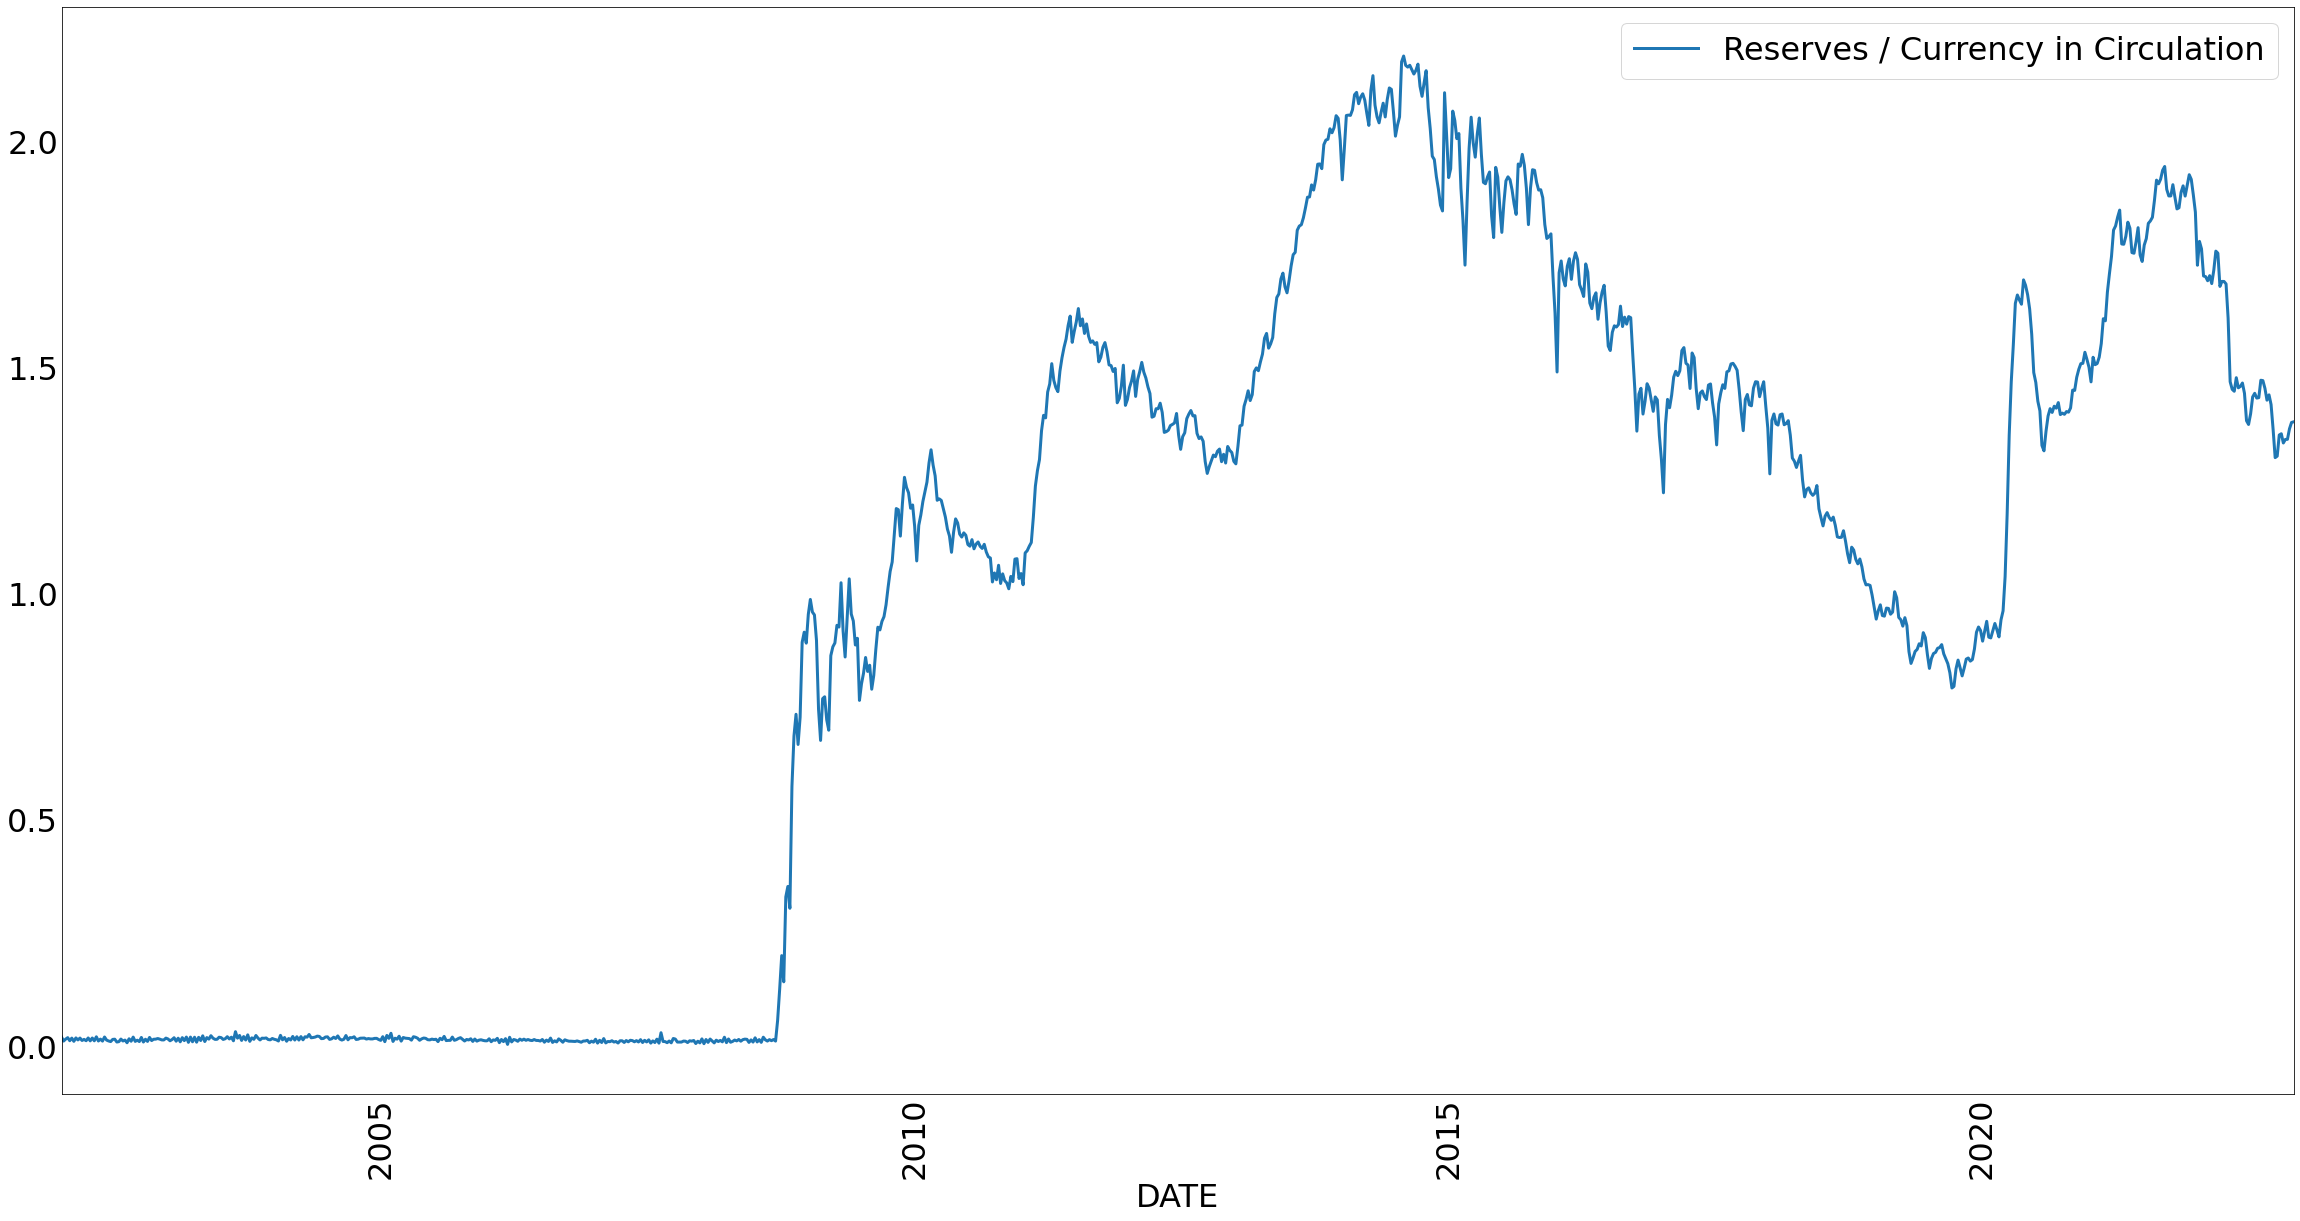

In [16]:
data["Reserves / Currency in Circulation"] = data["Balance Sheet: Total Reserves ($ Mil)"].div(
    data["Base: Currency in Circulation ($ Mil)"])

reserve_vars = ["Reserves / Currency in Circulation"]

plot_lines(data[reserve_vars], linewidth = 3, save_fig = False)

Reserves held as vault cash are held by banks themselves. They do not receive interest. Let's represent this distinction between reserves at the Federal Reserve and reserves held as vault cash.

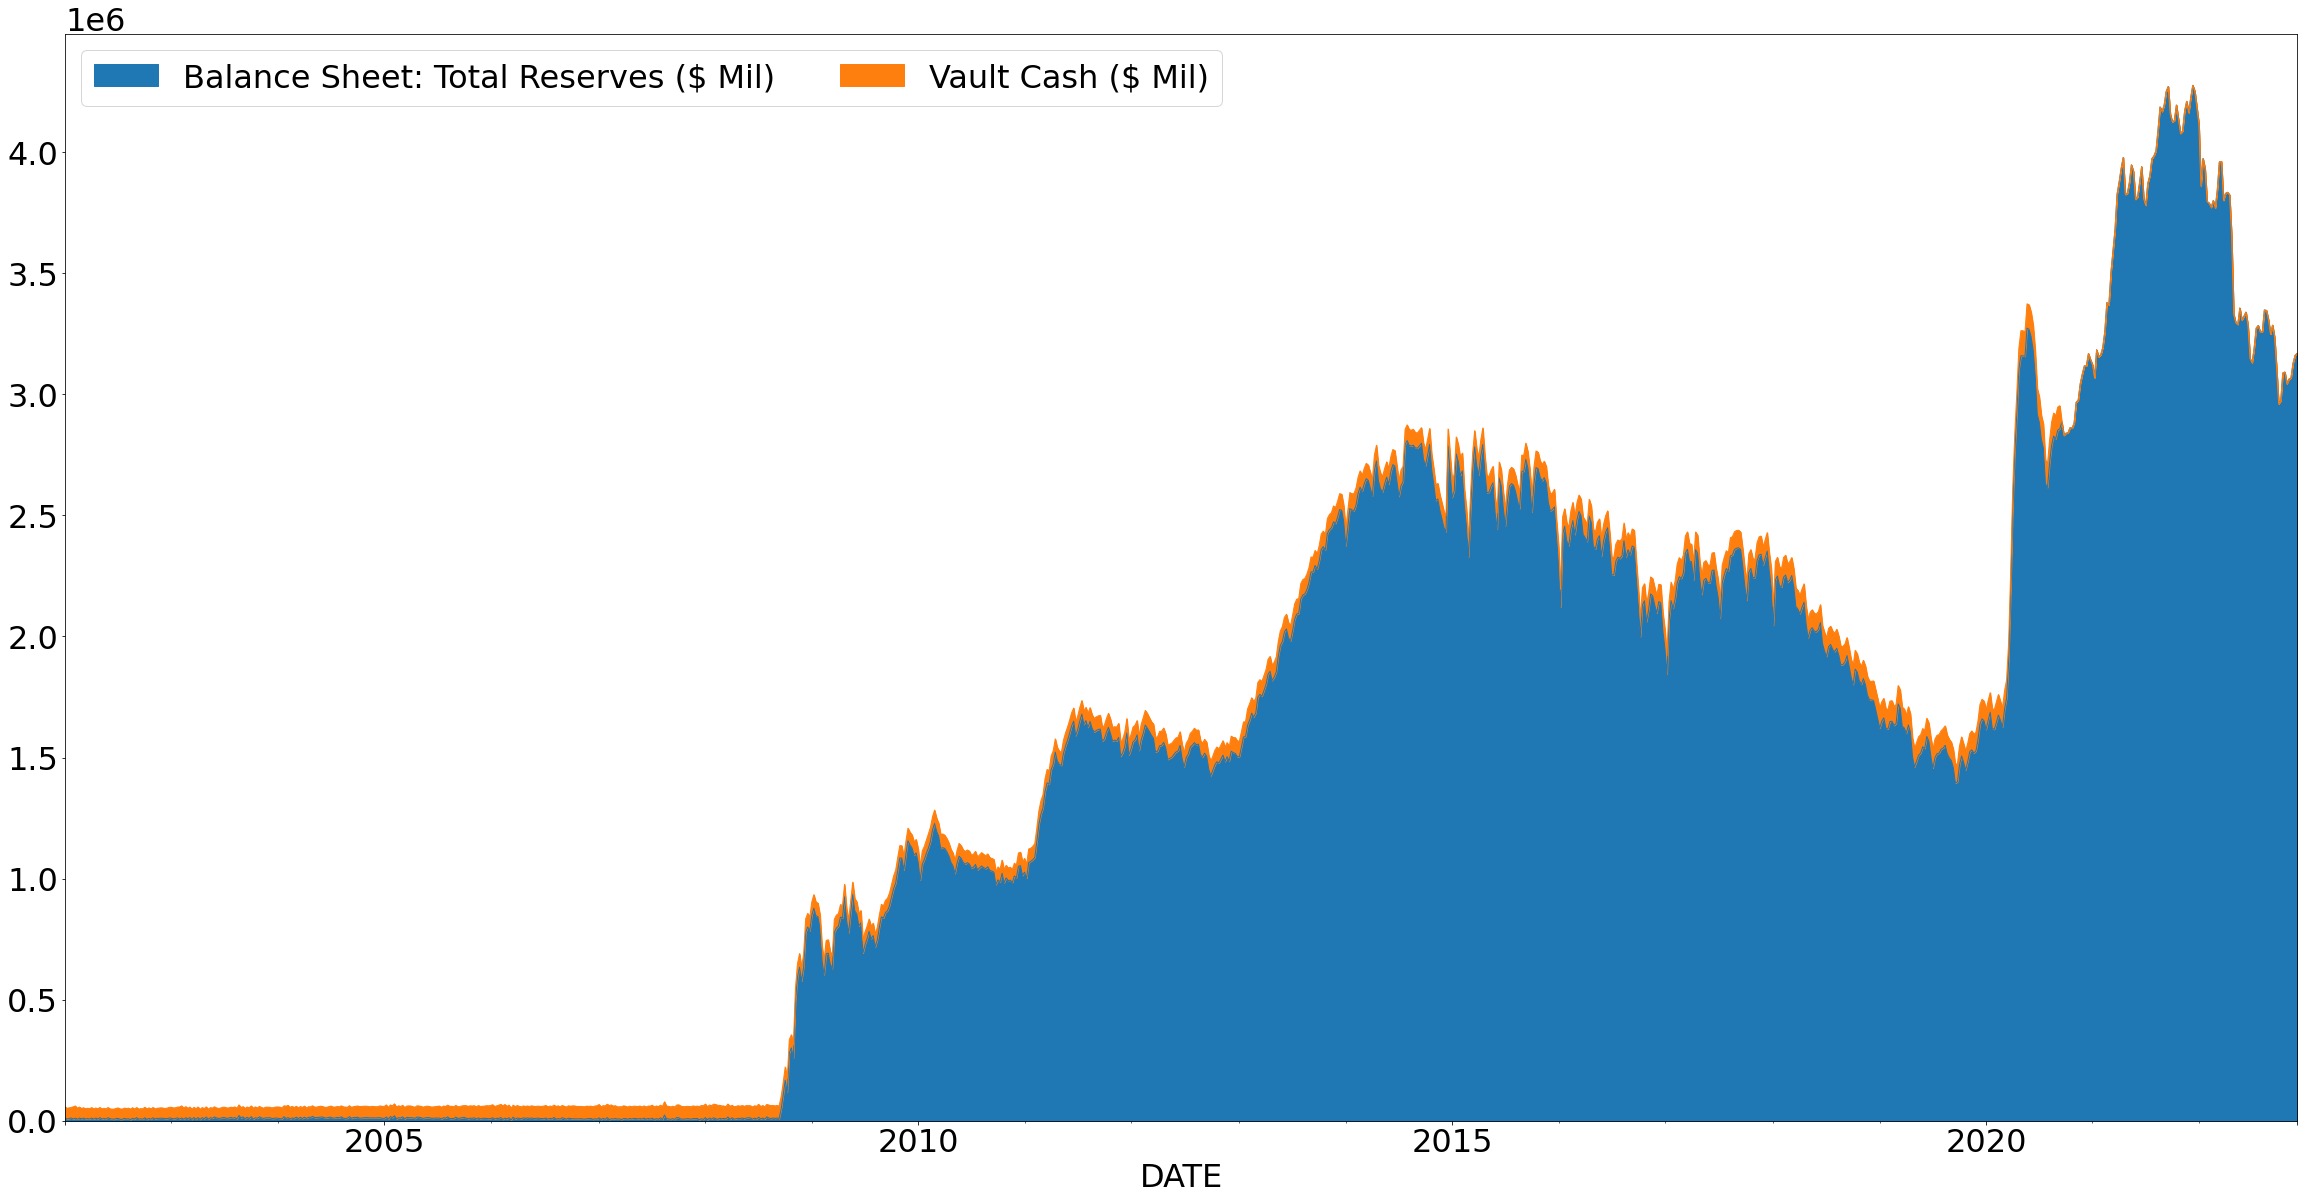

In [17]:
reserve_vars = ["Balance Sheet: Total Reserves ($ Mil)",
                "Vault Cash ($ Mil)"]
plot_stacked_lines(data, reserve_vars)

We can further distinguish between required reserves and excess reserves in each category. We will have to take the difference between vault cash and required reserves held as vault cash.

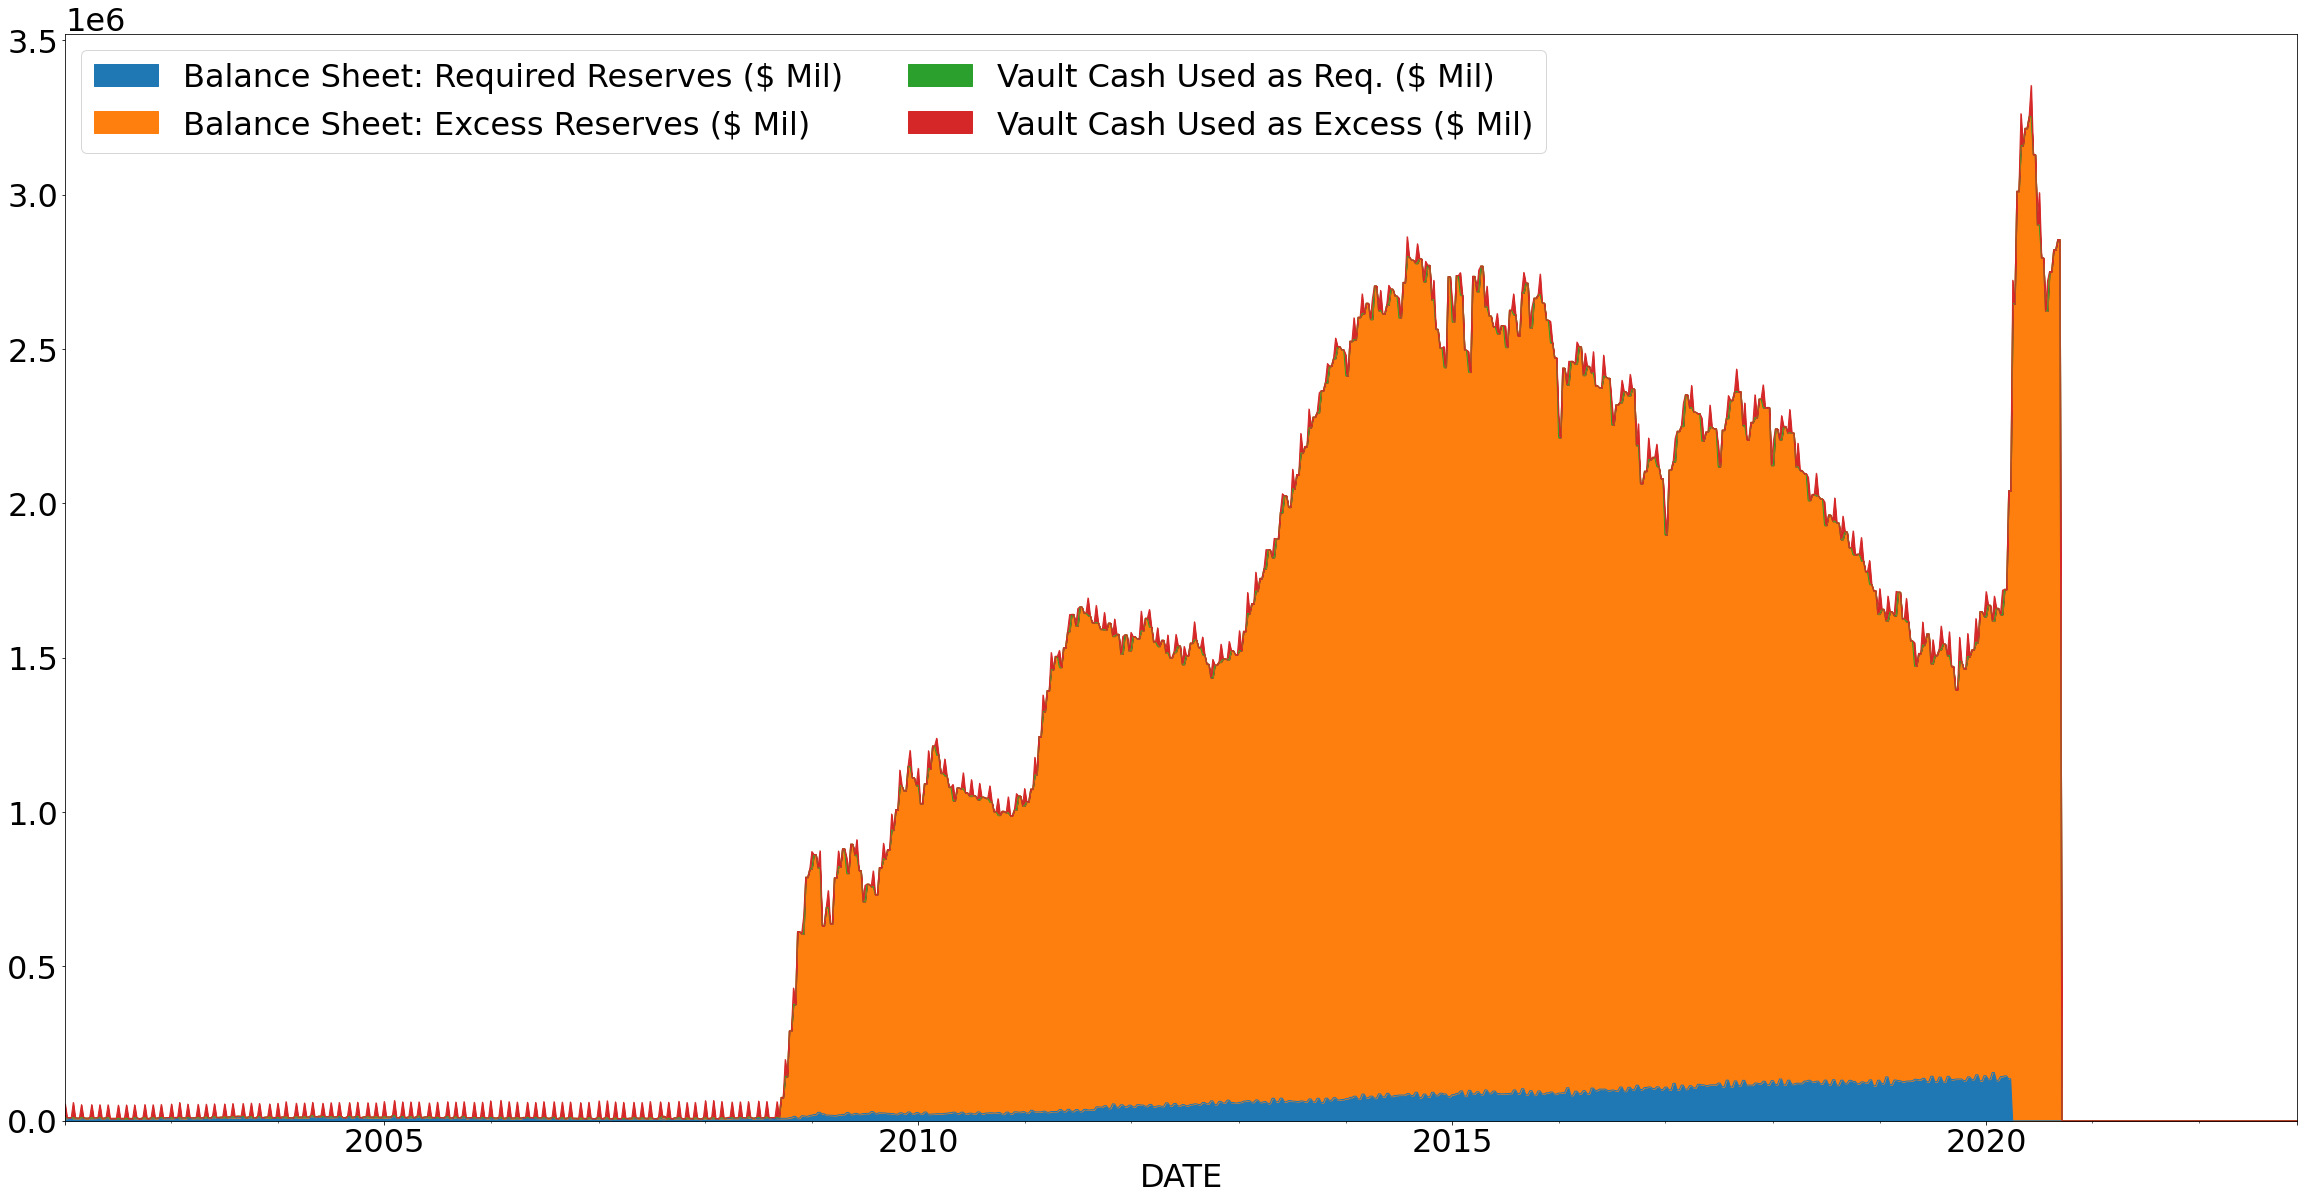

In [18]:
data["Vault Cash Used as Excess ($ Mil)"] = data["Vault Cash ($ Mil)"].sub(
    data["Vault Cash Used as Req. ($ Mil)"])

reserve_vars = ["Balance Sheet: Required Reserves ($ Mil)",
                "Balance Sheet: Excess Reserves ($ Mil)",
               "Vault Cash Used as Req. ($ Mil)",
                "Vault Cash Used as Excess ($ Mil)"]
plot_stacked_lines(data, reserve_vars)

As you can see, vault cash was the primary means of holding reserves *before* 2008. After the 2008 Crisis, nearly all reserves have been held on account.

There is a lot going on beneath the surface of these measures. To get a better idea of how monetary policy works, let's work through the major components of the Federal Reserve's balance sheet. We will return to the topic of reserves when discussing liabilities of the Federal Reserve.
## Assets Held by the Federal Reserve

Like any bank, the Federal Reserve not only takes deposits. It invests in interest bearing assets. For most of the Fed's history, these investments were predominantly, if not wholly, comprised of U.S. Treasuries - i.e., loans to the federal government. The Federal Reserve greatly expanded operations after 2008. It began investing in mortgage backed securities and lending to private banks, holding debt from federal agencies as well as to central banks in other countries with central bank liquidity swaps. All of these can be thought of as influencing the total stock of base money. In addition to these, the Federal Reserve also lends in the overnight lending market using repurchase agreements (repos). We will explain this last category later in the lesson.

Let's observe the change in the structure of security holdings from the Federal Reserve.

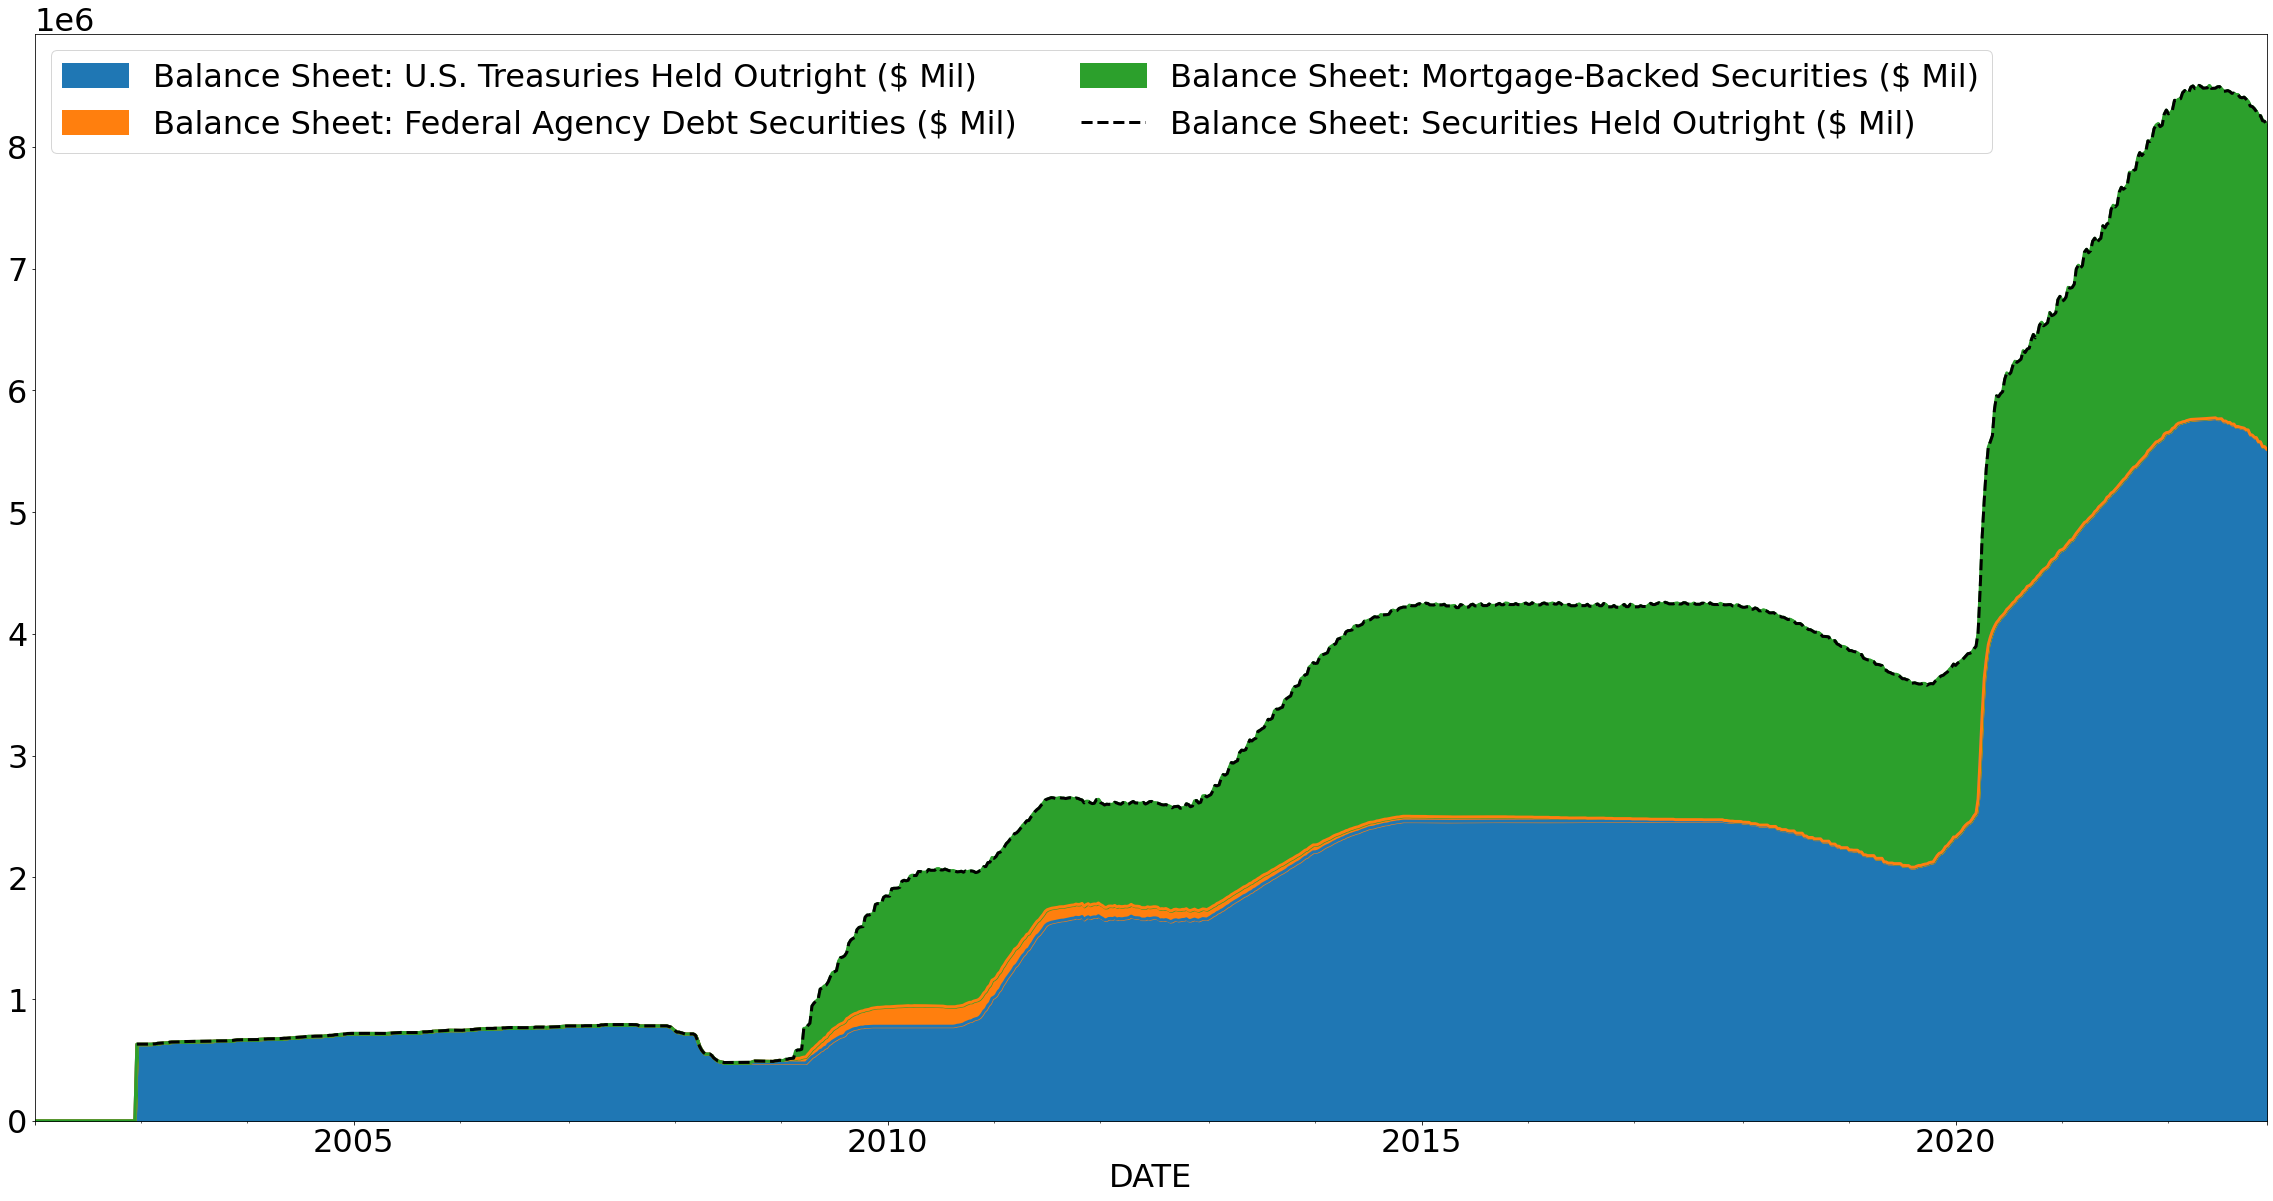

In [19]:
#fedProject
# . . . 
account_vars = ["Balance Sheet: U.S. Treasuries Held Outright ($ Mil)",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)"]

# these three subcomponents comprise the value of securities held outright in its entirety. To more distinctly show
# the total value of securities held by the Fed, increase linewidth.
plot_stacked_lines(data, account_vars, linewidth = 3, 
                   total_var = "Balance Sheet: Securities Held Outright ($ Mil)")


The mix of assets held by the Federal Reserve indicates the particular markets that it supports relative to those markets that do not receive direct support. From the data, it is clear that the Federal Reserve provides significant support for 1) federal borrowing and 2) mortgage markets, or in other words, real estate. Interest rates in both markets have remained relatively low throughout the period that they have received support. 

Central banks have traditionally supported government spending, so 1) should be no  surprise. There is a strong correlation between the size of a central banks balance sheet and the value of government debt that it owns. Much of the expansion that occurred after 2008, even if it did not support federal borrowing, ultimately ended up serving this purpose.

We can use a scatter plot to more clearly detect correlation between variables.

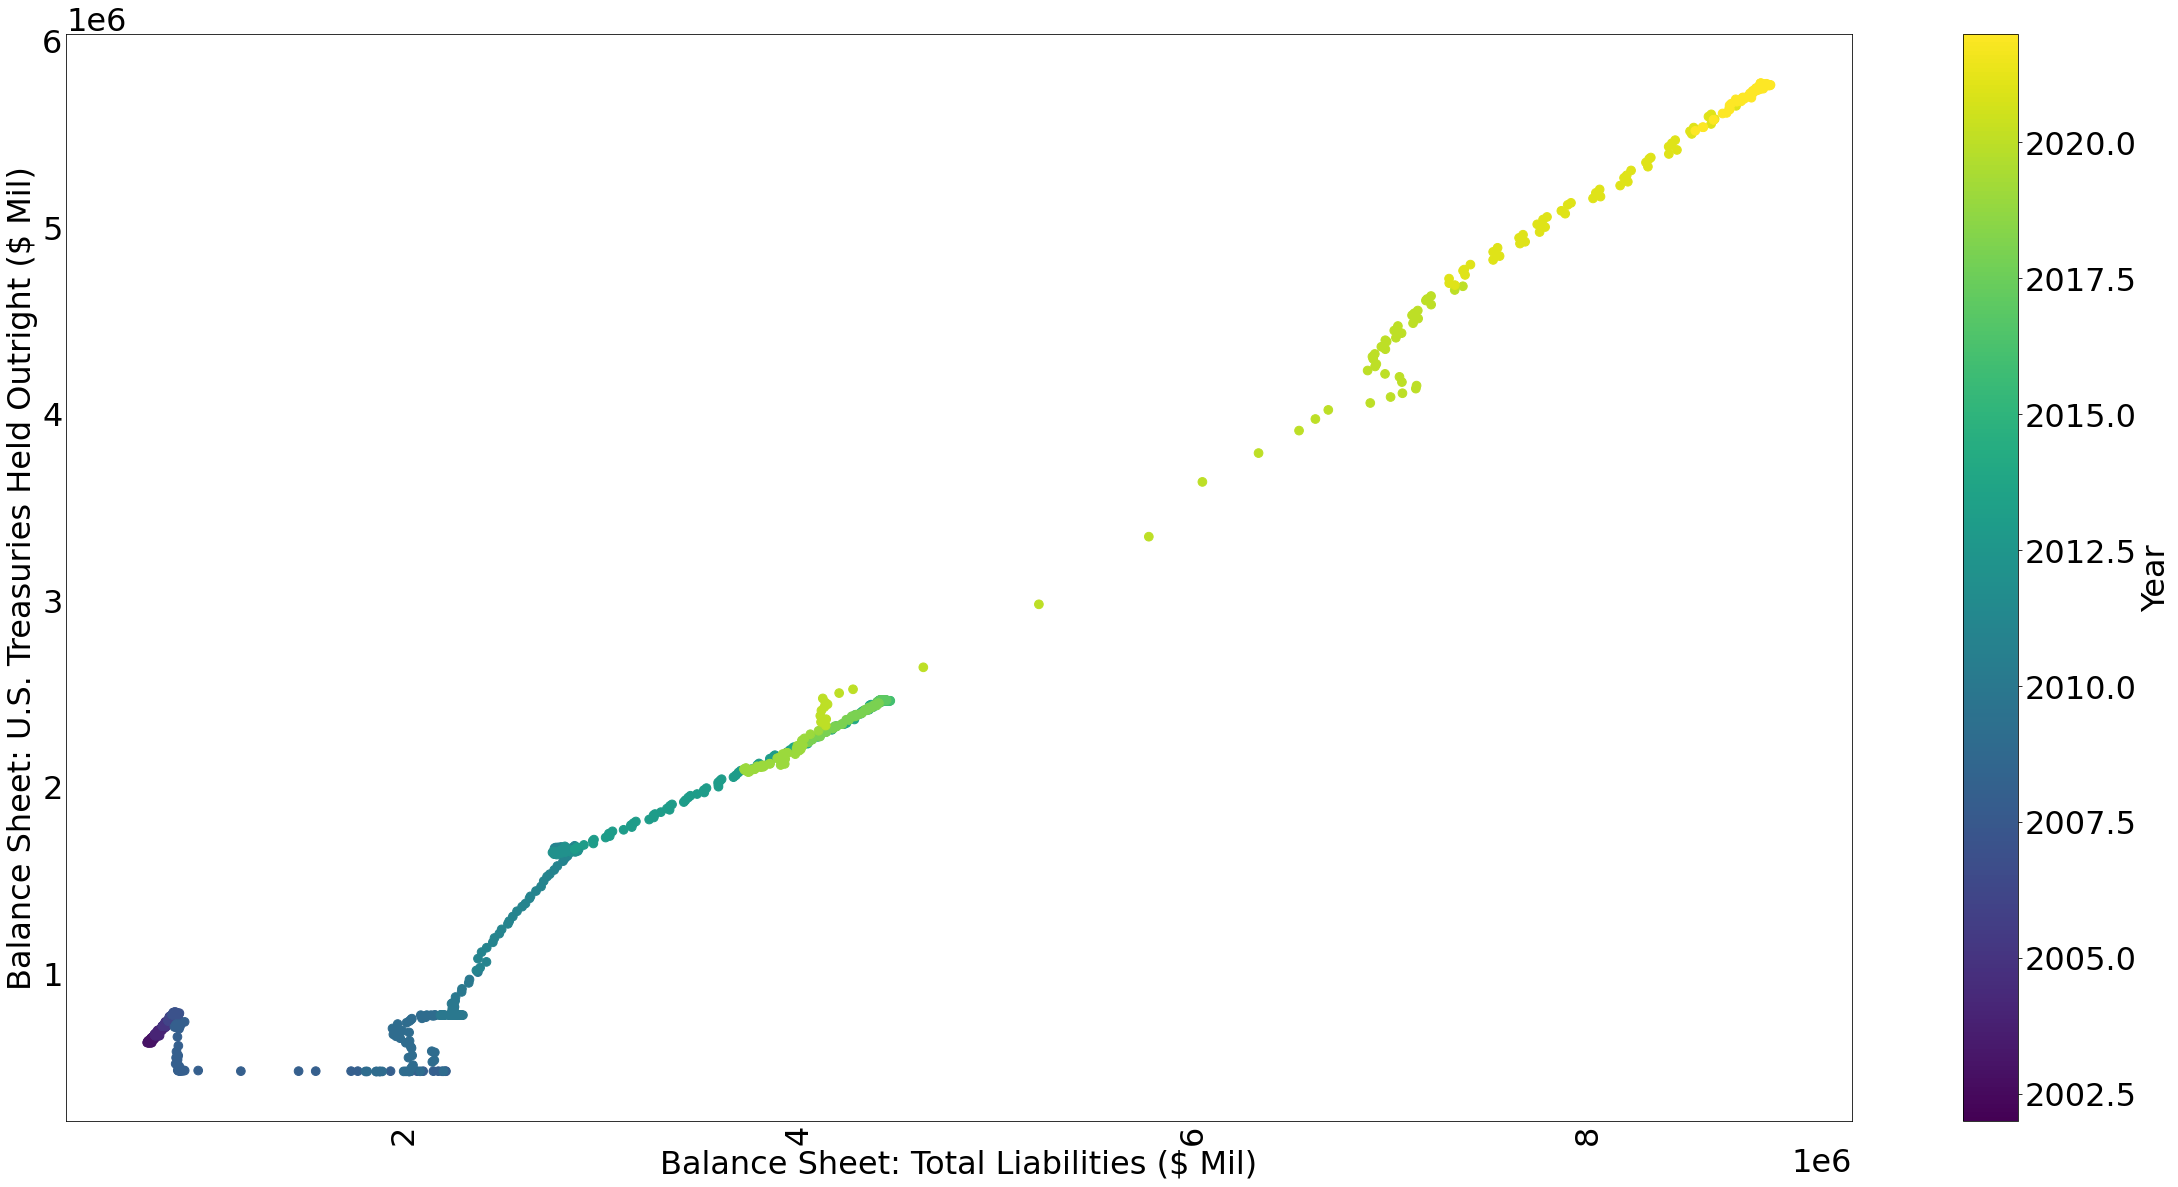

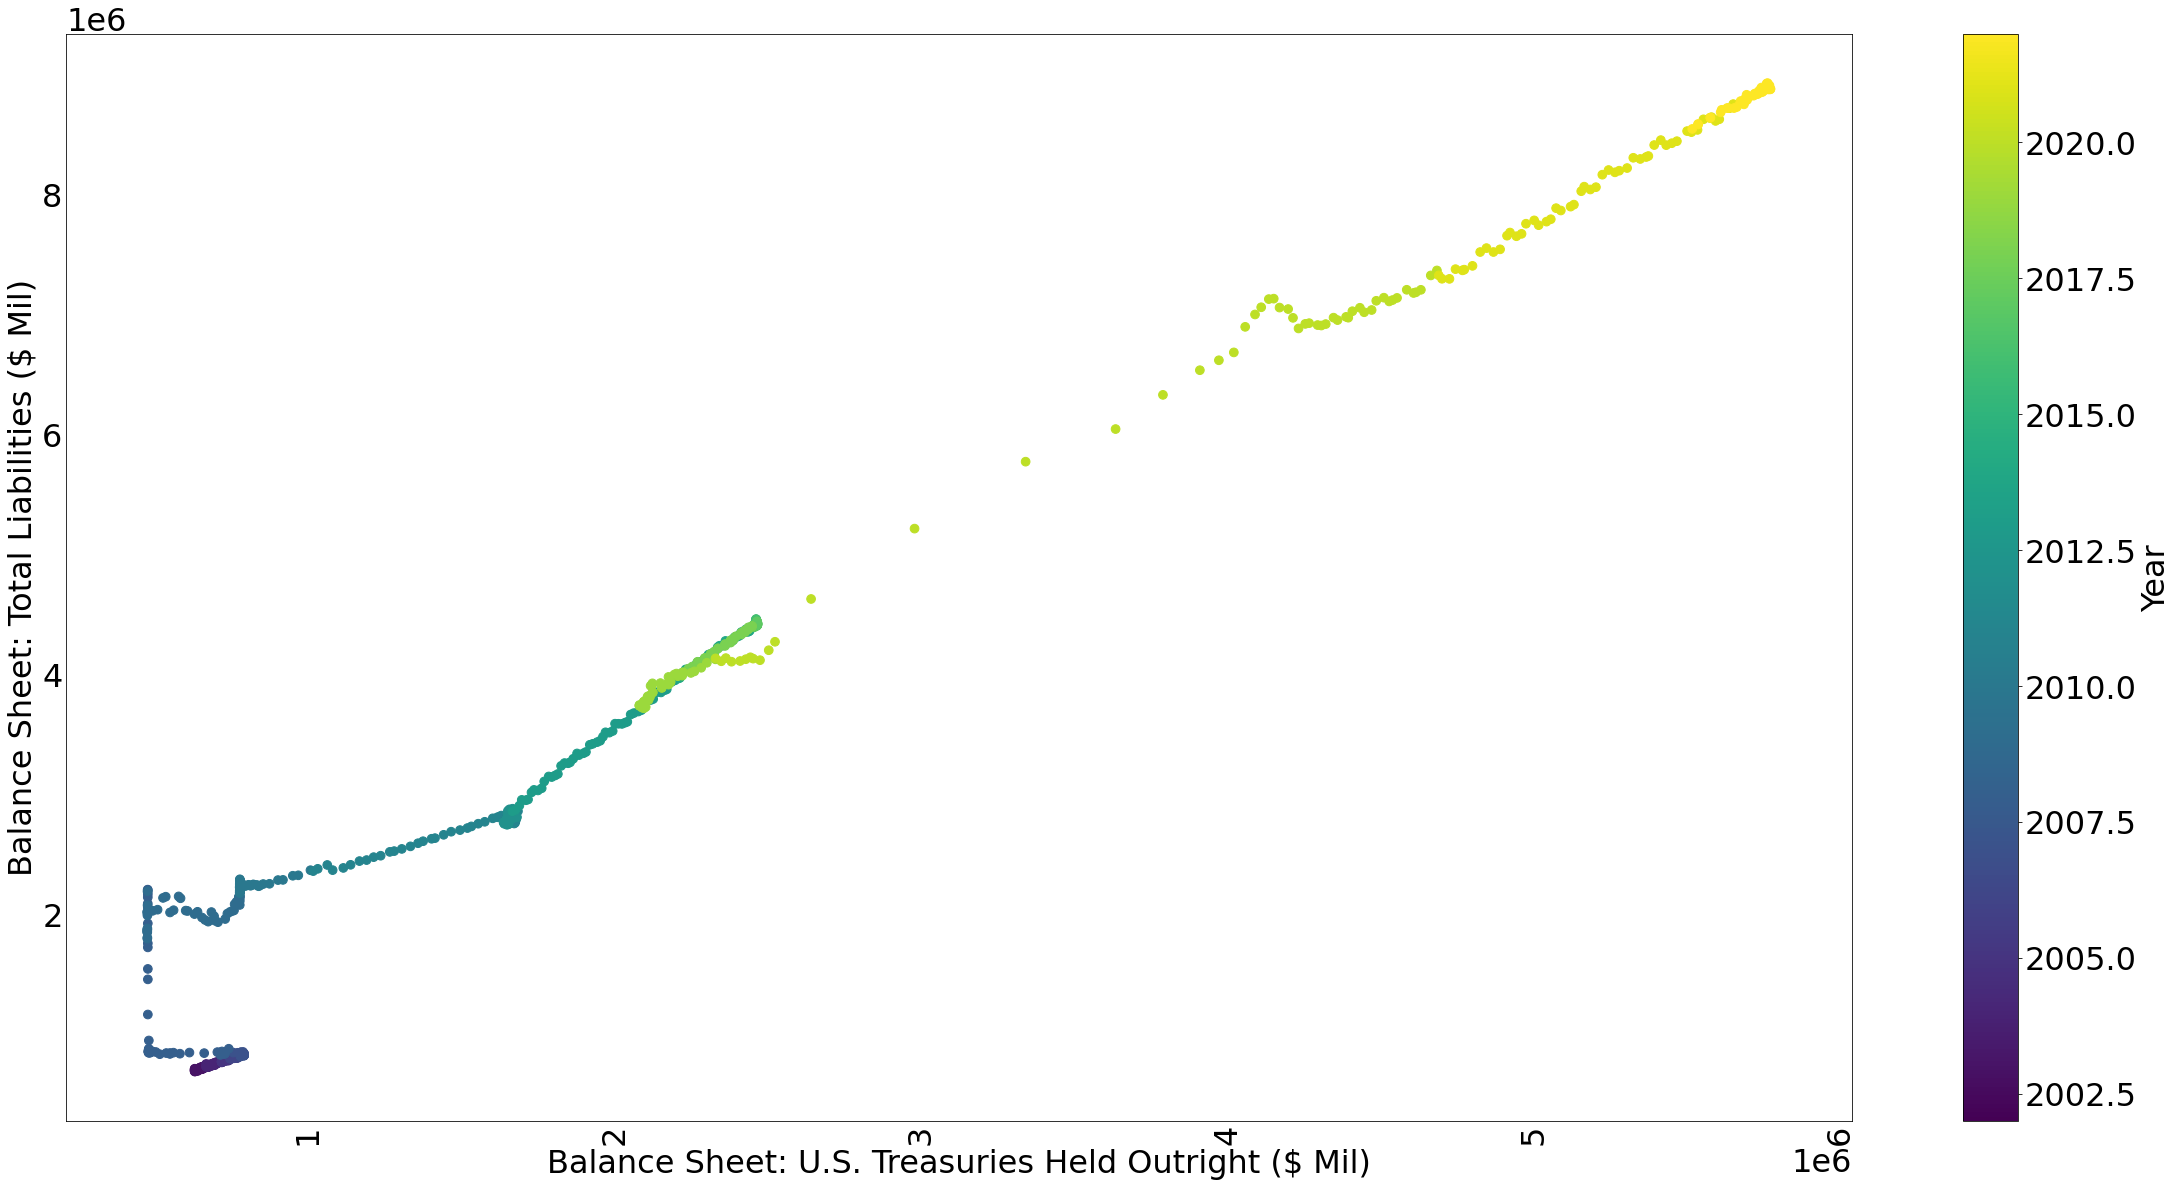

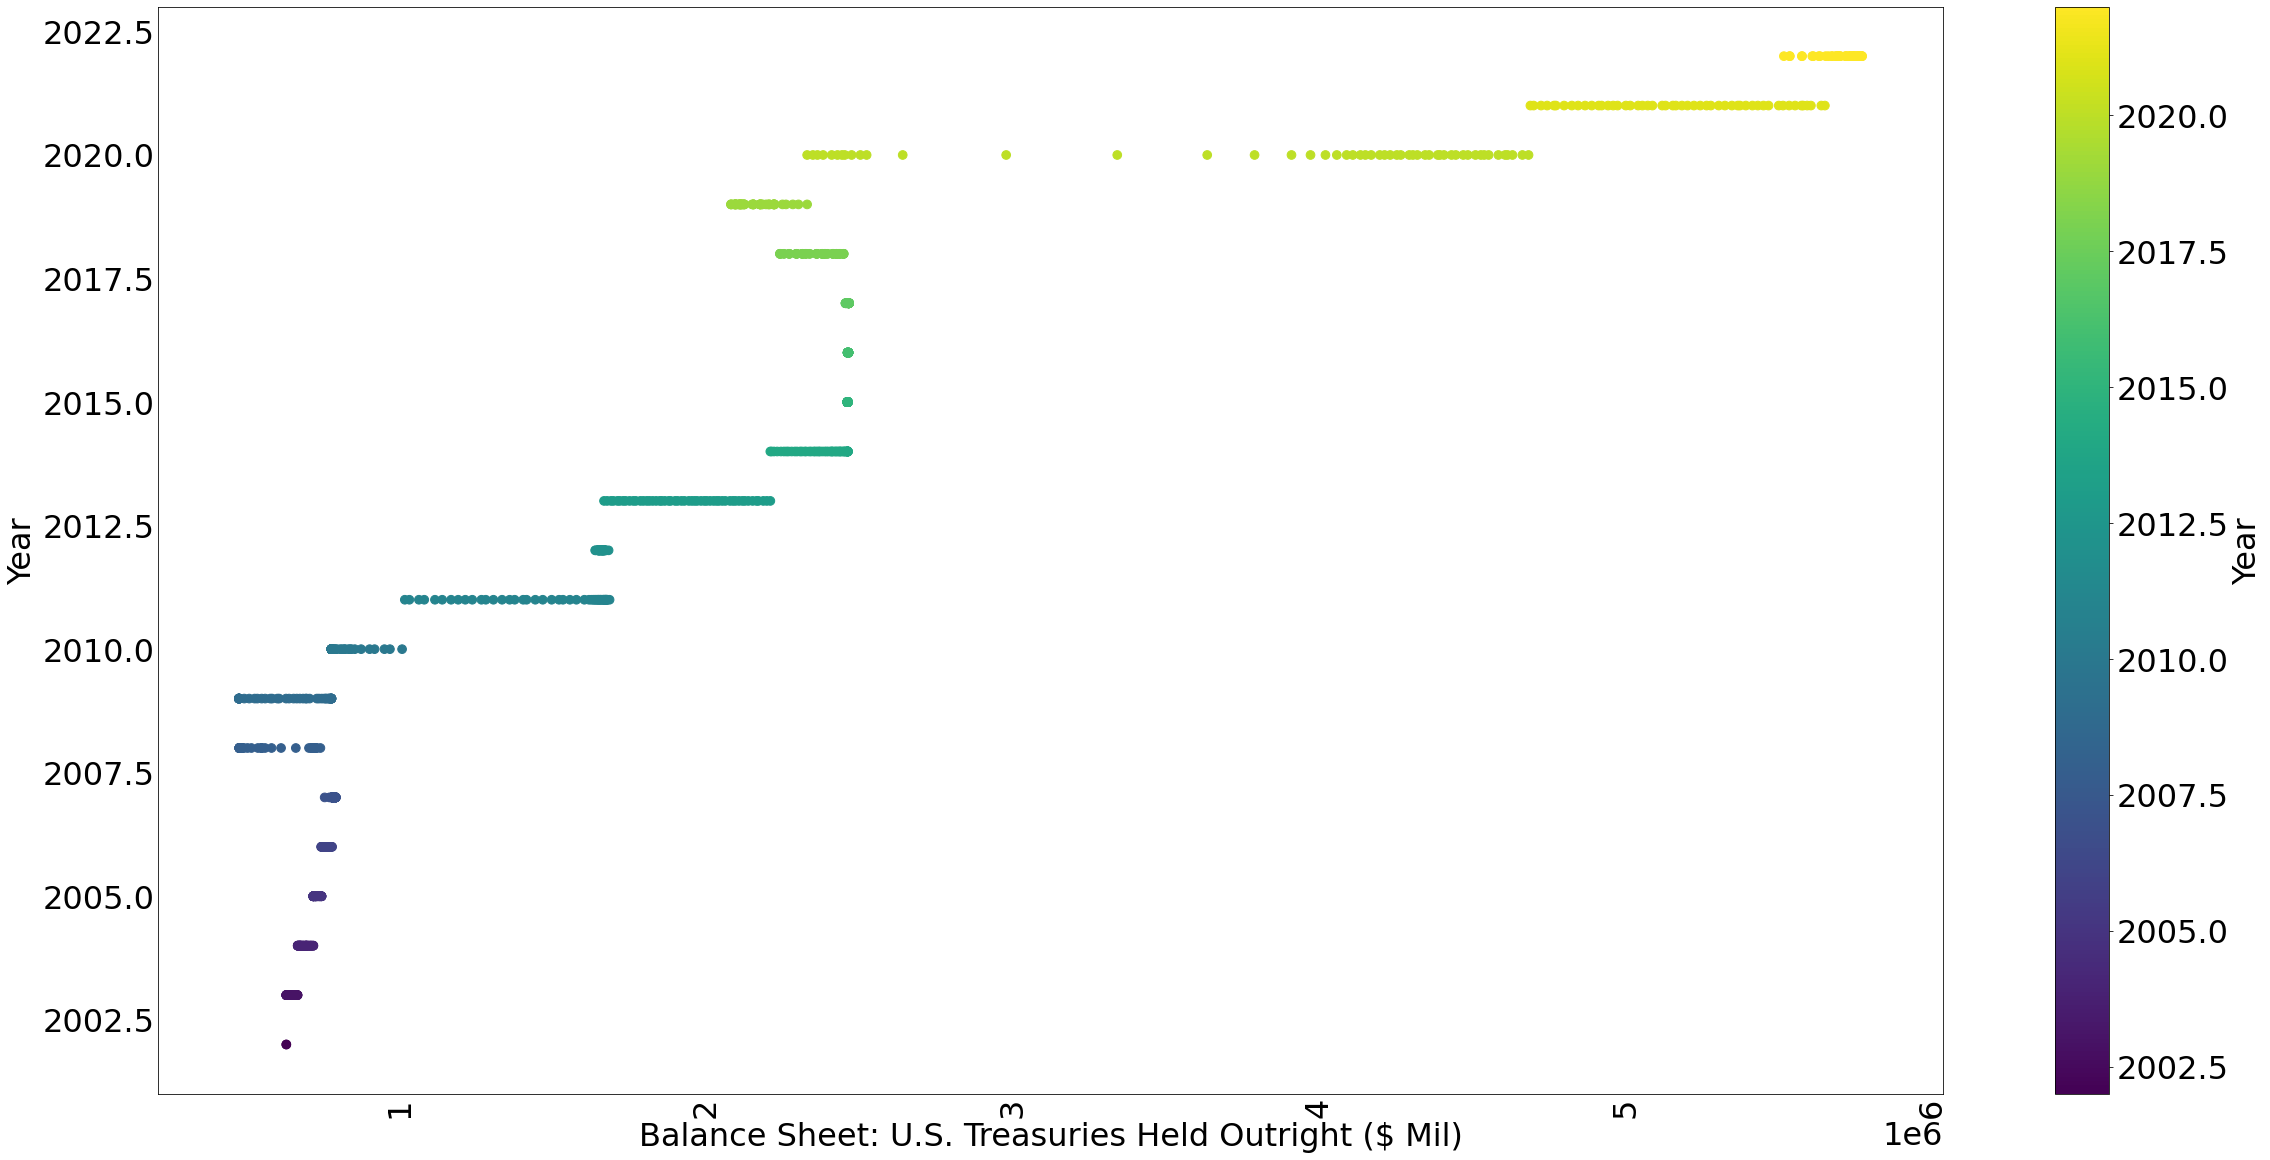

In [20]:
scatter_vars = ["Balance Sheet: Total Liabilities ($ Mil)",
                "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)"]
plot_ts_scatter(data[scatter_vars])

One obvious result of 1) is that the federal government has increased it's level of borrowing as a proportion of nominal income. The level of present taxation as a percent of GDP has fallen. As rates on federal debt have falllen, the cost of federal borrowing has fallen. This data is not included in the current exercise since [nominal income](https://fred.stlouisfed.org/series/GDP) and the [level of federal debt](https://fred.stlouisfed.org/series/GFDEBTN) are only recorded quarterly. 

<img src="https://github.com/jlcatonjr/Learn-Python-for-Stats-and-Econ/blob/master/In%20Class%20Projects/Federal%20Taxes%20and%20Debt%20to%20GDP.png?raw=true" alt="" title="" />
<h3><center></center></h3>


Since we already know the composition of securities held outright by the Fed, it will be convenient to reference this aggregate value when representing the rest of the asset side of the Fed's balance sheet. We add other forms of lending. The Fed lends to other central banks using liquidity swaps. Or it may lend directly to private financial instiutitons. Lastly, it may provide loans as repurchase agreements (repos) with borrowers in the interbank, overnight lending  market.

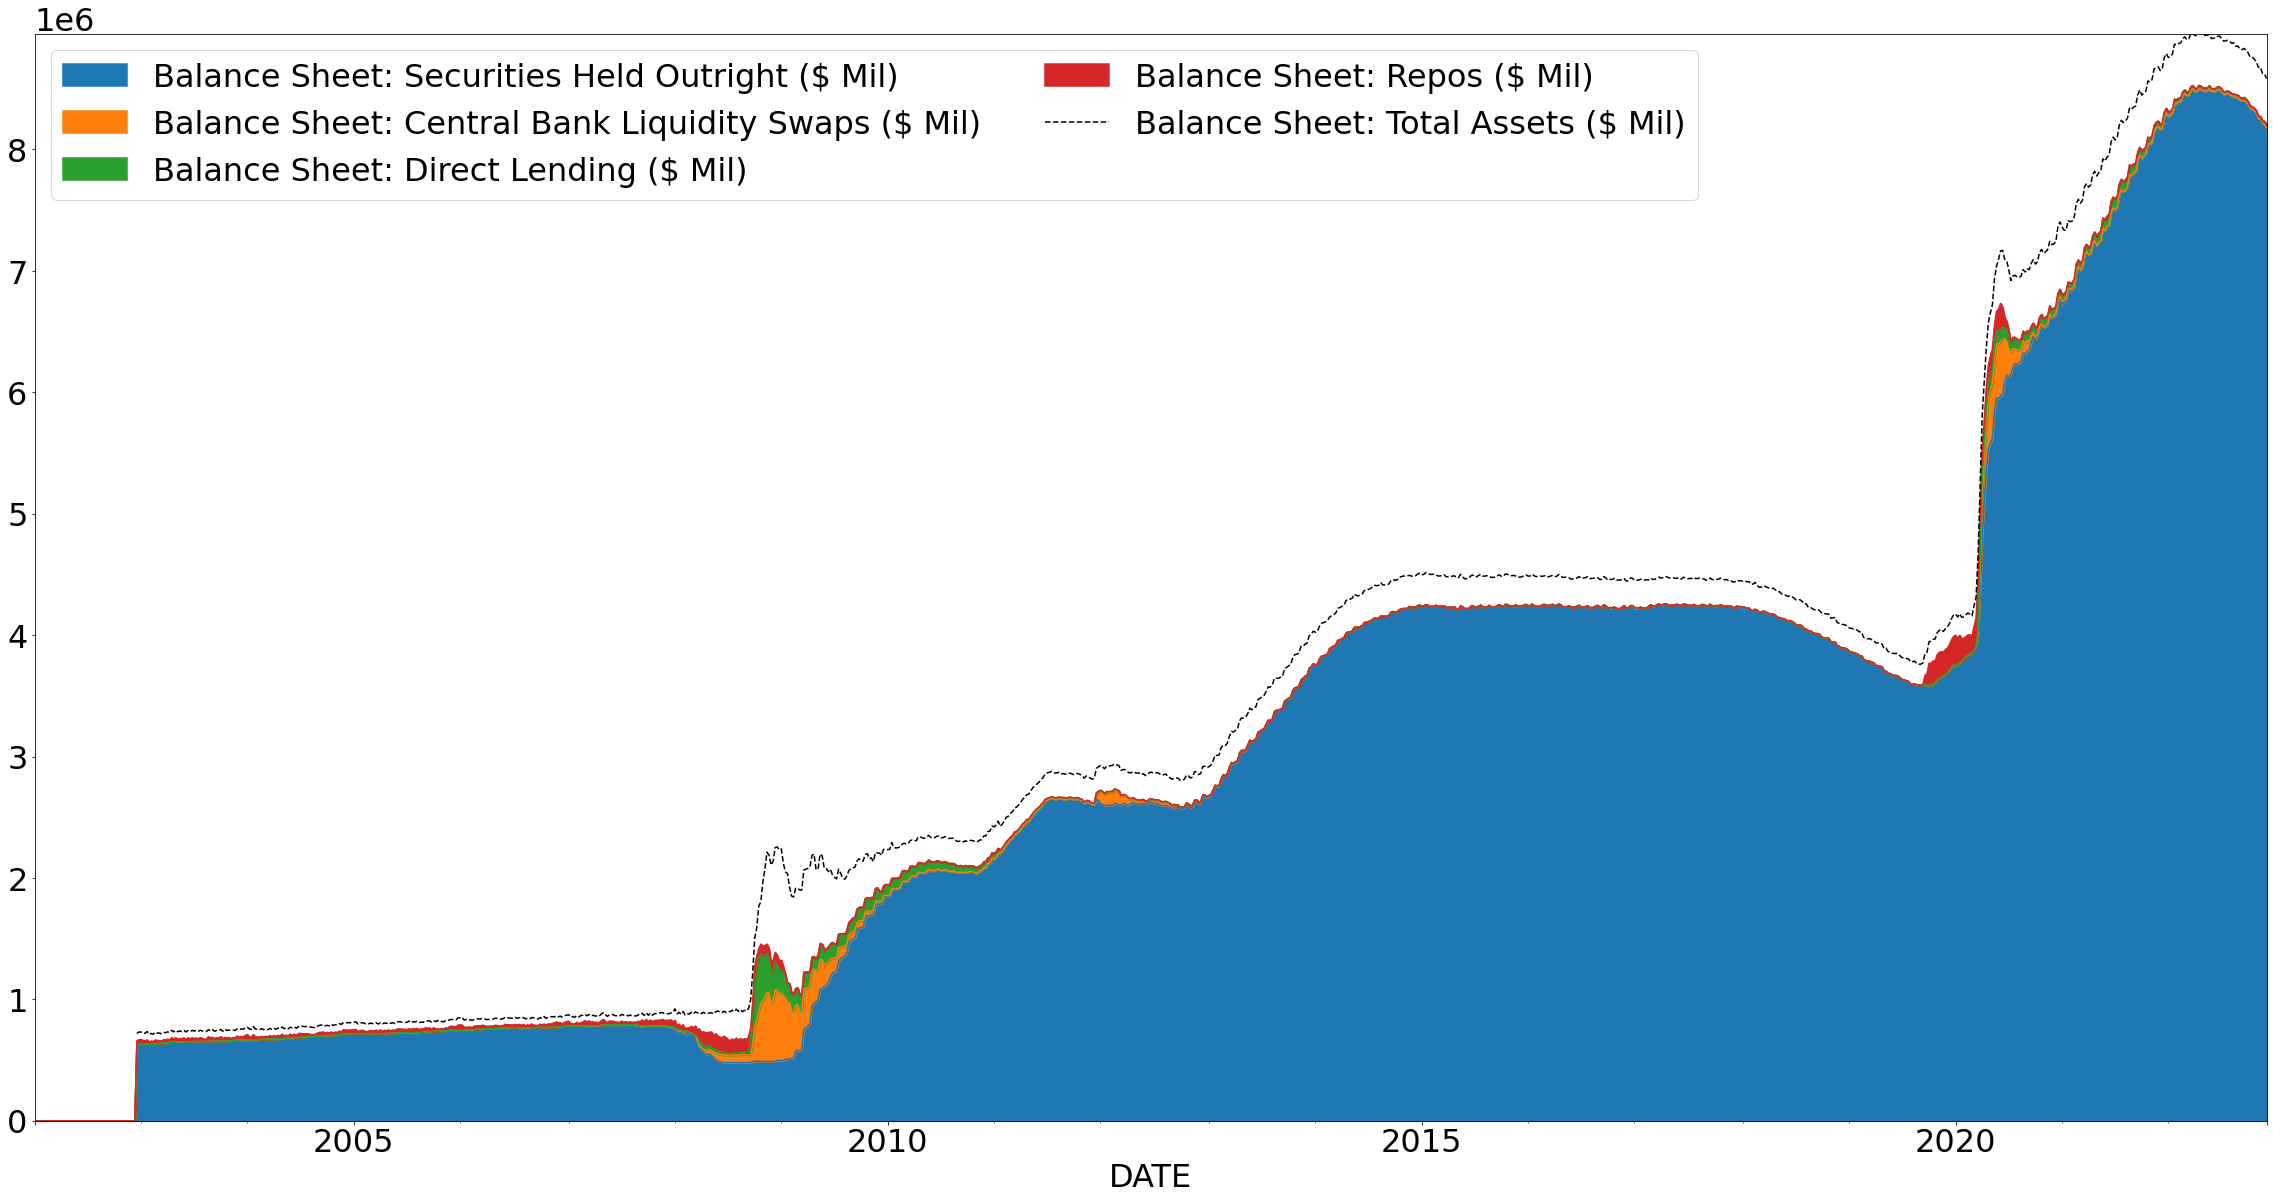

In [21]:
#fedProject
# . . . 
account_vars = ["Balance Sheet: Securities Held Outright ($ Mil)",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)",
               "Balance Sheet: Direct Lending ($ Mil)",
               "Balance Sheet: Repos ($ Mil)"]

plot_stacked_lines(data, 
                   account_vars,
                   linewidth = 1.5, 
                   total_var = "Balance Sheet: Total Assets ($ Mil)")



Although a portion of asset side of the balance sheet remains unexplained, it is clear that the Federal Reserve predominantly purchases securities. A fair share of the remaining value of the balance sheet exists as unamortized changes (usually increases) in the value of securities already held by the Federal Reserve. (I leave out the value of discounts as it is miniscule in comparison.) Let's add this last variable to see how much of the Fed's assets remains undescribed by these variables.

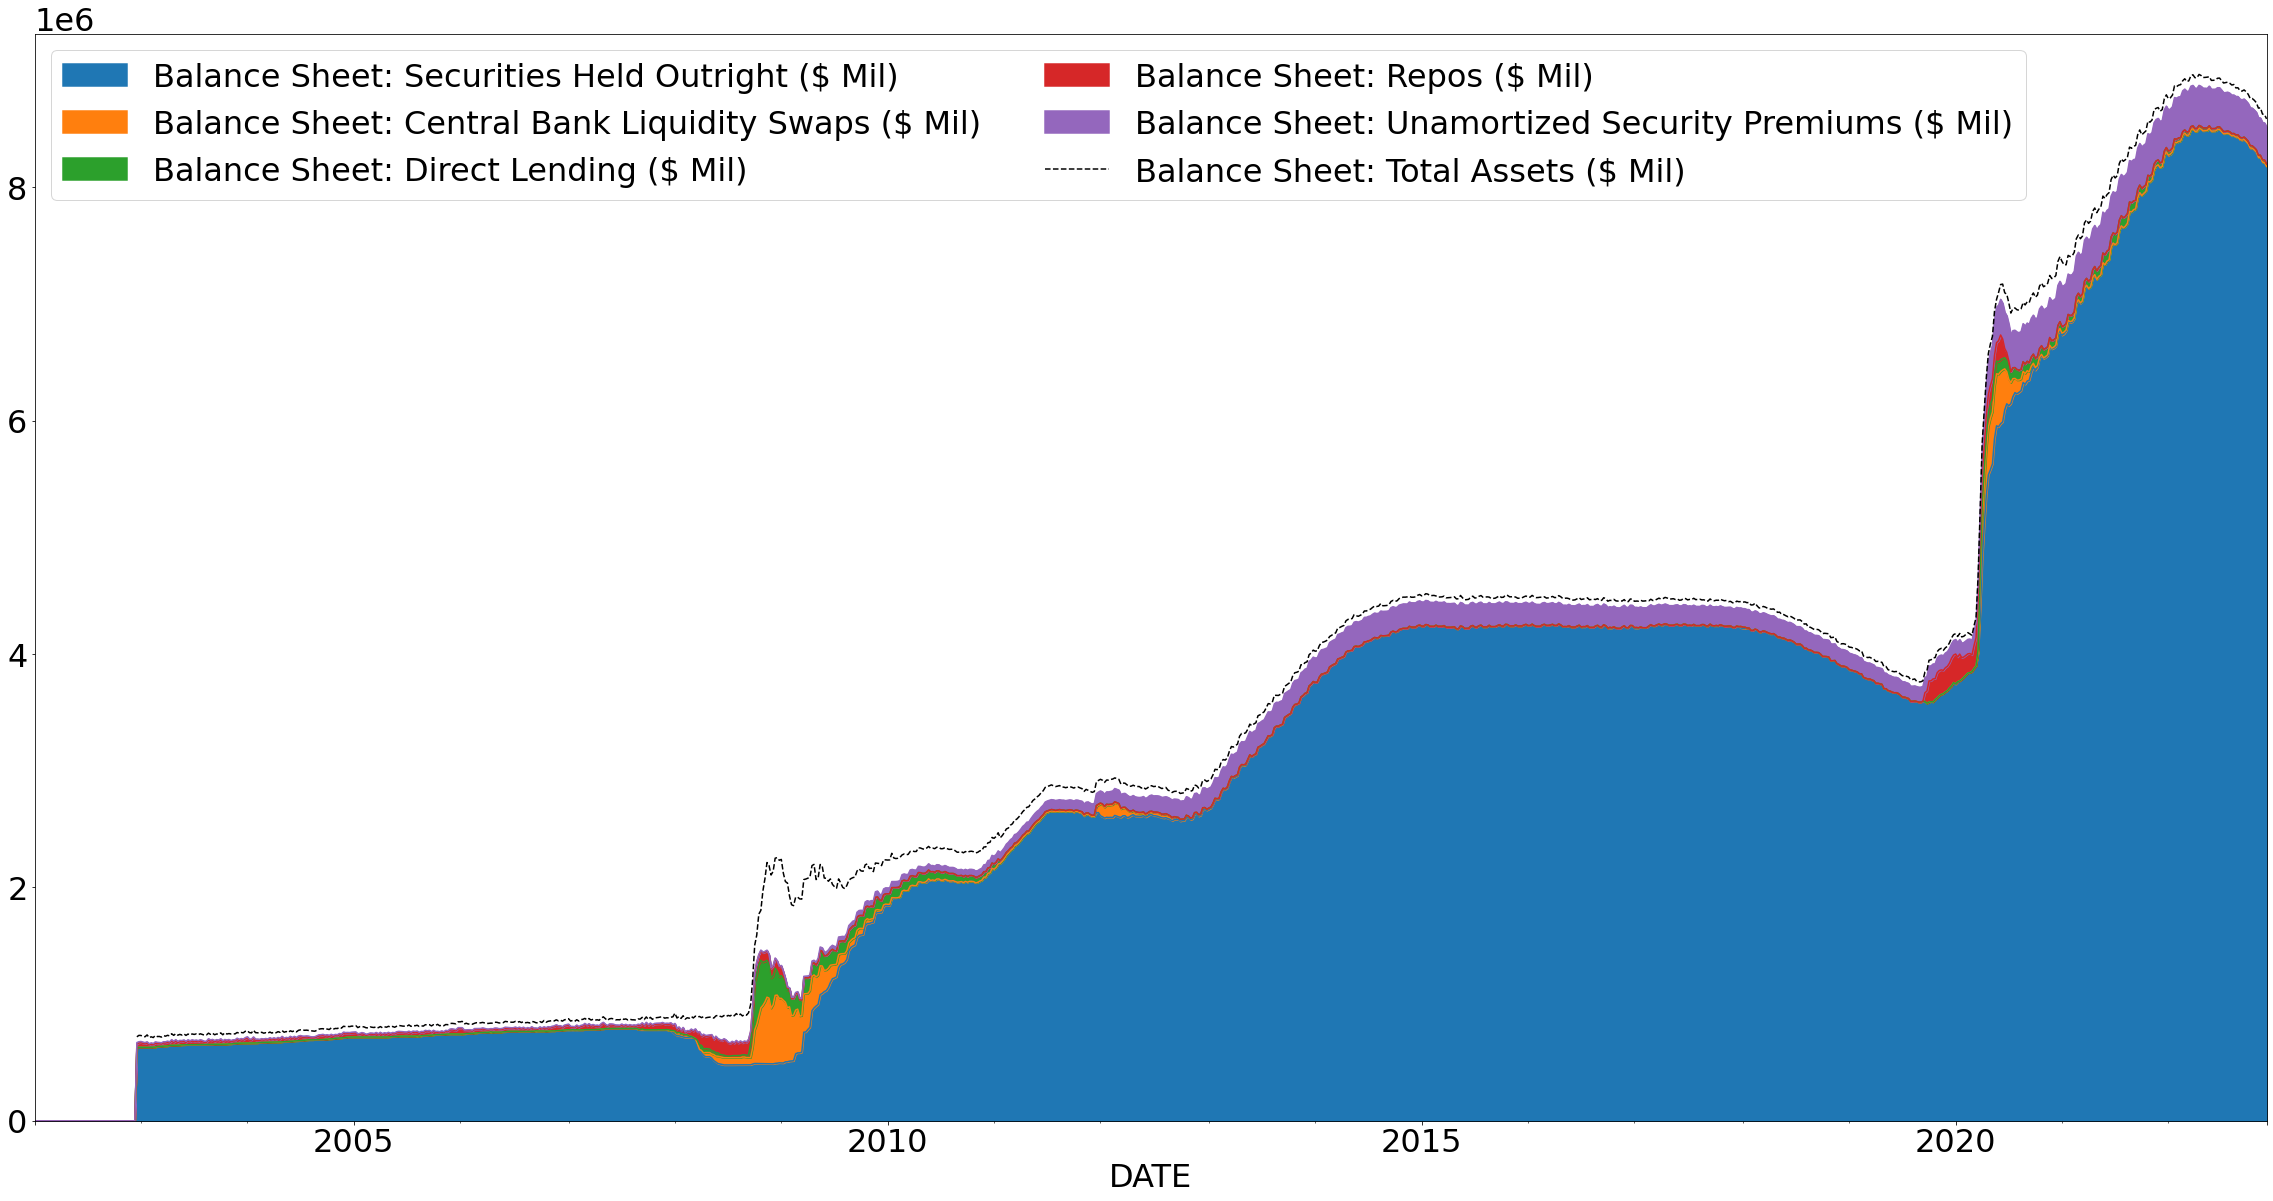

In [22]:
#fedProject
# . . . 
account_vars = ["Balance Sheet: Securities Held Outright ($ Mil)",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)",
               "Balance Sheet: Direct Lending ($ Mil)",
               "Balance Sheet: Repos ($ Mil)",
               "Balance Sheet: Unamortized Security Premiums ($ Mil)"]

plot_stacked_lines(data, account_vars, linewidth = 1.5, 
                   total_var = "Balance Sheet: Total Assets ($ Mil)")

Except for the crisis period, most of the balance sheet is explained by these five variables. Let's consolidate them into a single category that includes a few other modest categories for which we have not so far accounted.* There is still a small portion of the balance sheet unexplained during the Crisis era, but even with this included, we have explained most of the changes occuring on the asset side of the Fed's balance sheet. 

\**These include Net Portfolio Holdings of Commercial Paper Funding Facility II LLC, Items in Process of Collection, Bank Premises, Foreign Currency Denominated Assets, and Other Assets).* 

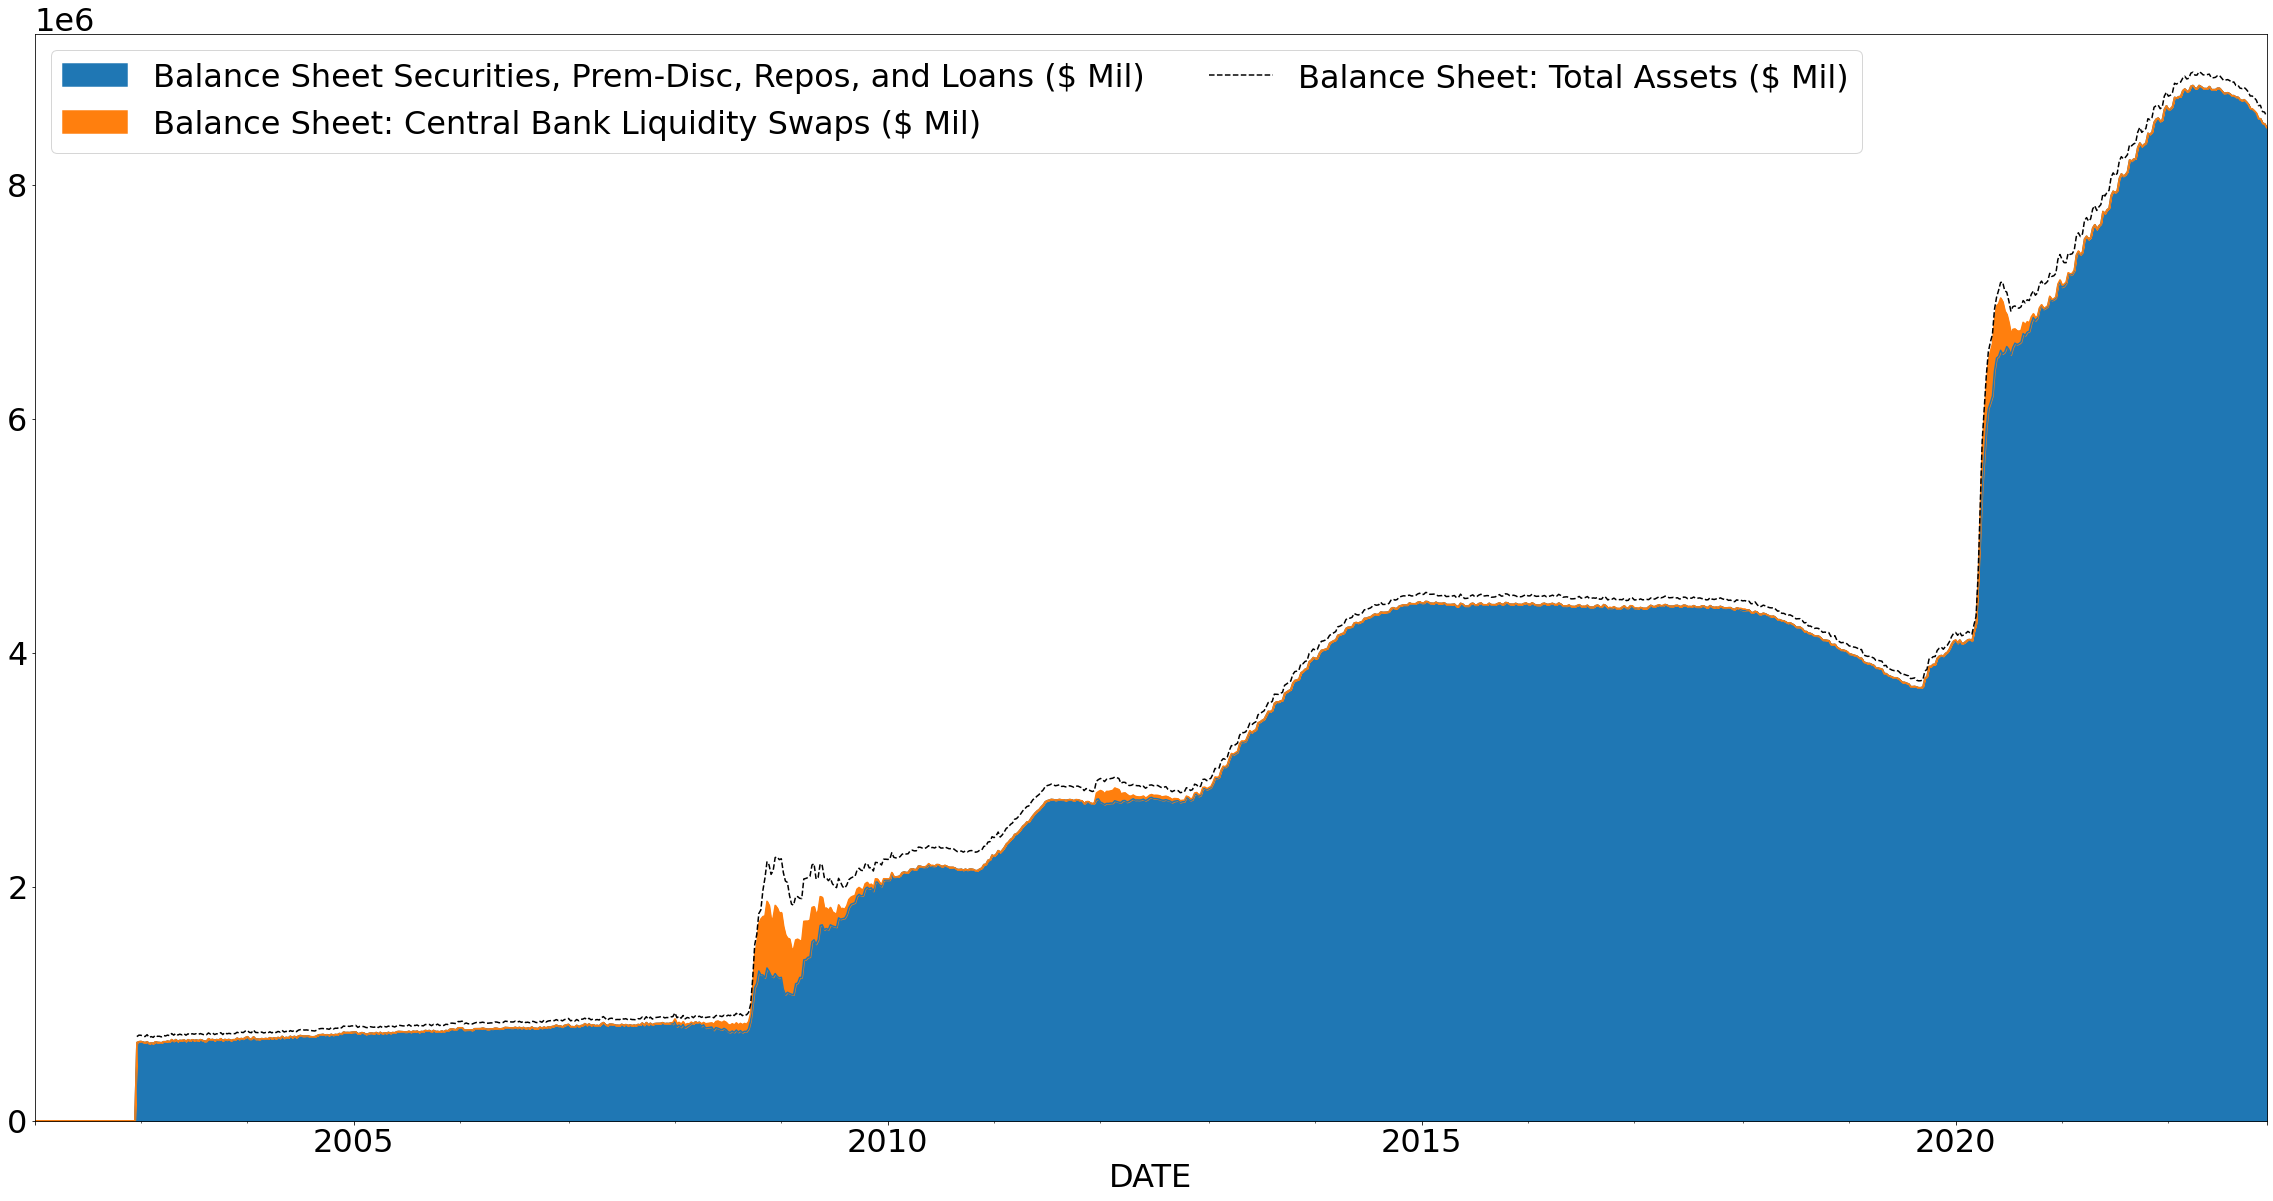

In [23]:
#fedProject
# . . . 
account_vars = ["Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",
                "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)"]

plot_stacked_lines(data, account_vars, linewidth = 1.5, total_var = "Balance Sheet: Total Assets ($ Mil)")


## Liabilities of Federal Reserve

Returning to our earlier discussion of the monetary base and excess reserves, we can think of excess reserves held at the Fed as comprising part of the Federal Reserve's liabilities. But what exactly are excess reserves? Banks have required reserves, or at least they did before the recent COVID-19 measures that reduced required reserves to zero. Required reserves are those funds that they keep on hand in order to fulfill legal reserve requirements. Before the 2008 Crisis, no interest was paid on any reserves. After the 2008 Crisis, interest began to be paid on required *and* excess reserves held at the Federal Reserve. Reserves in the financial system largely shifted to being held at the Federal Reserve as a result.

Parties that hold excess reserves at the Federal Reserve earn a risk free rate of interest on those deposits. Banks decide between earning this risk free rate of return or investing those reserves in the market.

There are two major sources of deposits at the Fed. Deposits of financial institutions are largely represented by reserves data. The U.S. Treasury, the body that oversees expenditures by the federal government, also holds a deposit account at the Federal Reserve.  Much as we added excess reserves and currency in circulation to represent the components of the monetary base, we can add together all reserves and the U.S. Treasury General Account that is held at the Fed to represent deposits held at the Fed. Only a small fraction of unexplained deposits remain.

\*There appears to be an error in one deposit account at the Fed in September 2015 as the sum of reserves held at the Fed and the Treasury General Account is *greater* than the value of all deposits. 

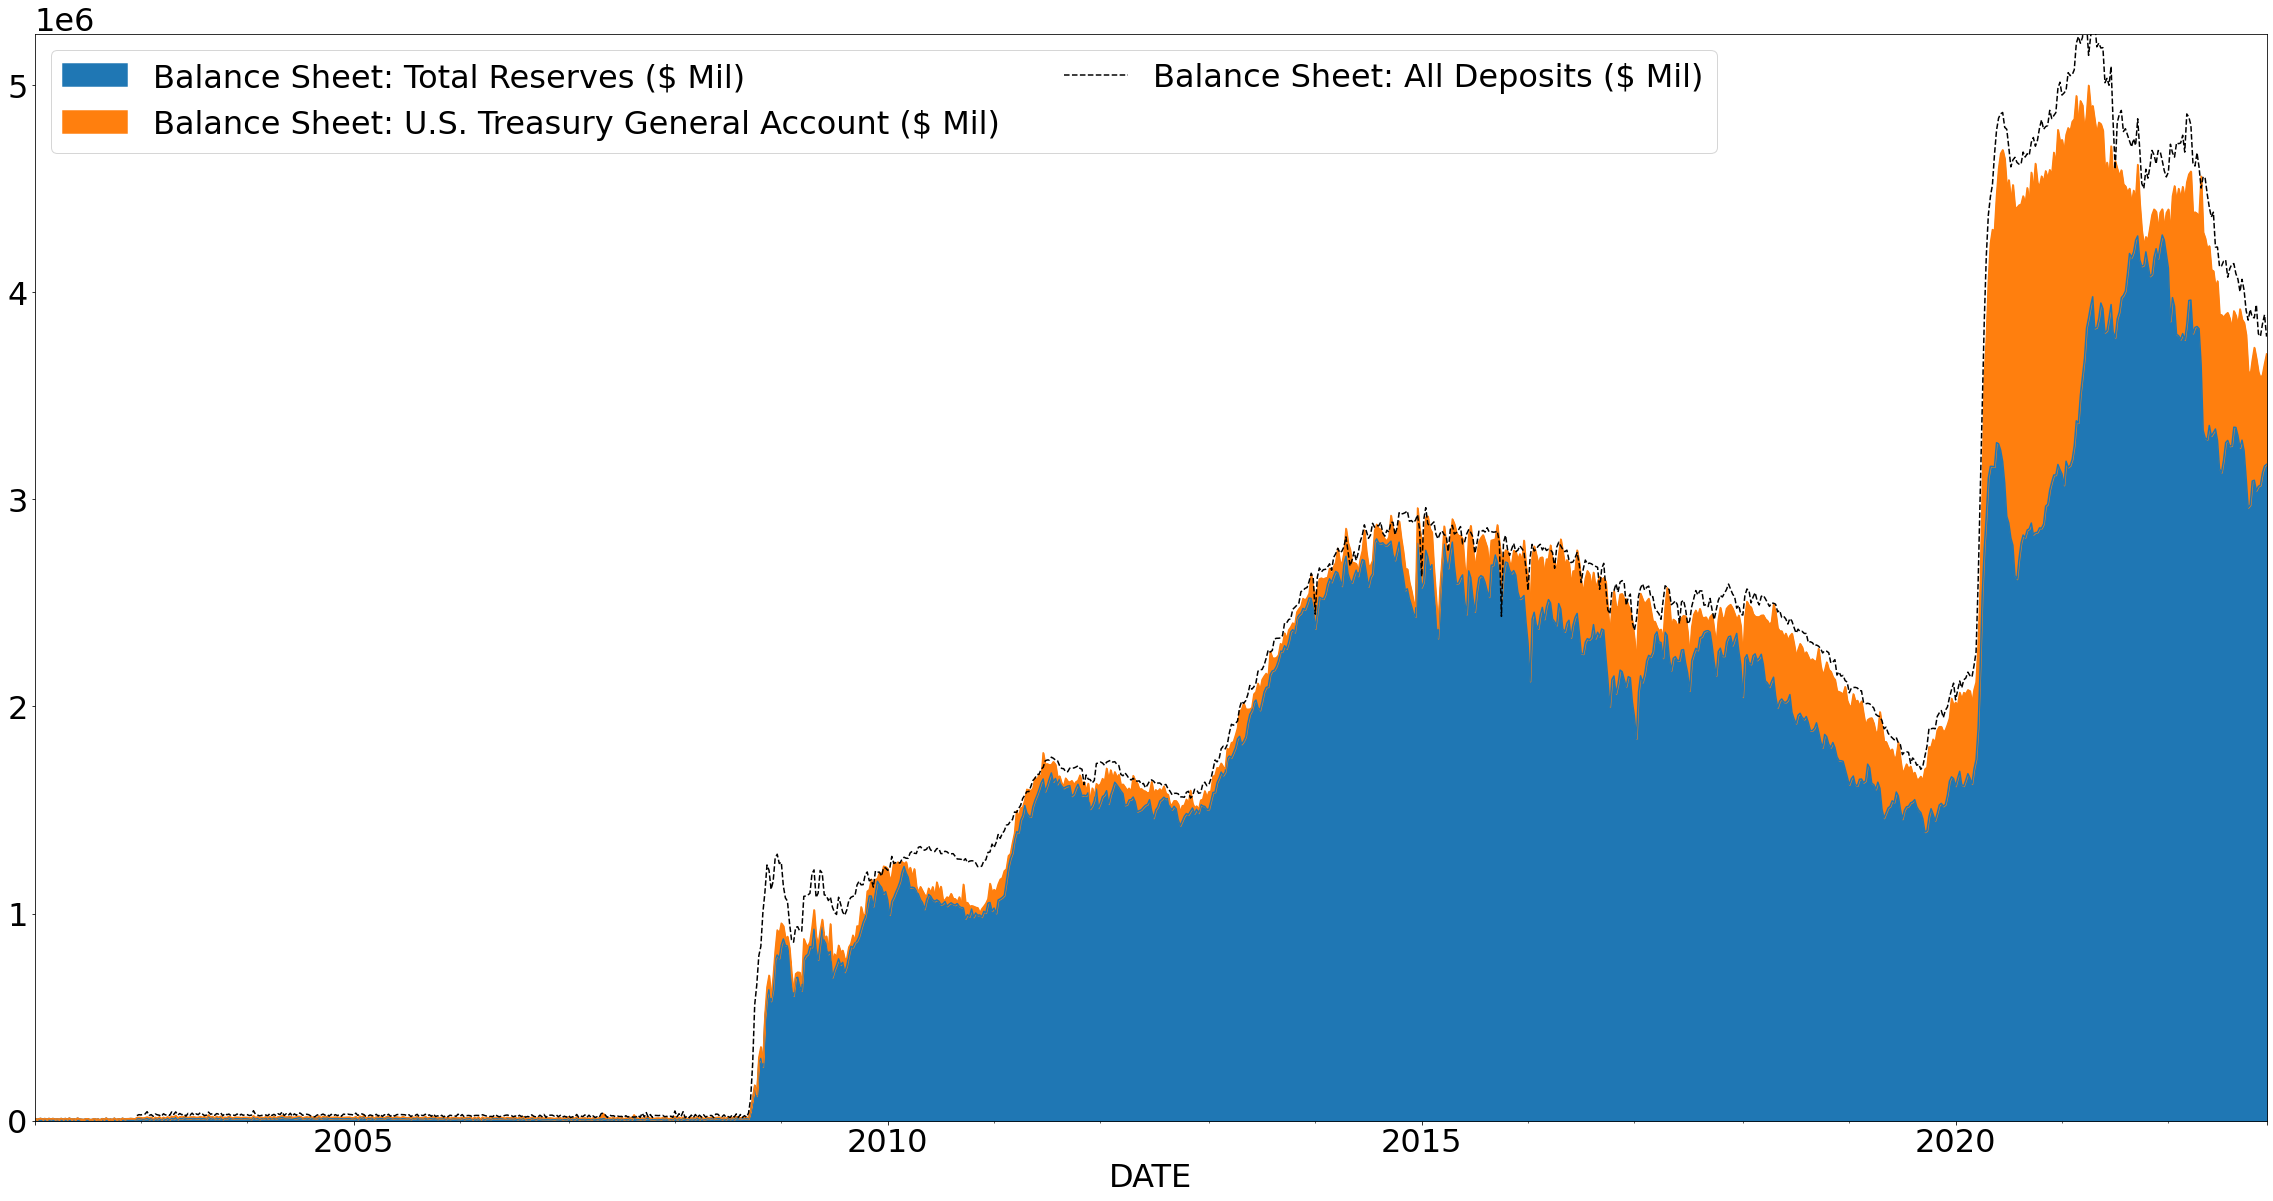

In [24]:
#fedProject
# . . . 
account_vars = ["Balance Sheet: Total Reserves ($ Mil)",
                "Balance Sheet: U.S. Treasury General Account ($ Mil)"]

plot_stacked_lines(data, account_vars, linewidth = 1.5, total_var = "Balance Sheet: All Deposits ($ Mil)")

Federal Reserve Chariman Benjamin S. Bernanke has explained that the purpose of paying interest on excess reserves was to keep a portion of the monetary base out of circulation. Banks increase their level of deposits so long as they expect that the risk adjust return on remaining investments is less the the rate paid on excess reserves. Thus, one way to conceptualize the liabilities of the Fed is to distinguish between reserves held at the Federal Reserve and Federal Reserve notes outside of the federal reserve. Nearly the entire base is accounted for.

Starting in 2015, requirements to maintain a minimum liquidity coverage ratio as defined by Basil III forces banks to either maintain a minimum value of reserves or high quality liquid assets (HQLAs) in order to make loans, thus limiting the extent to which lending can increase the velocity of the base. 

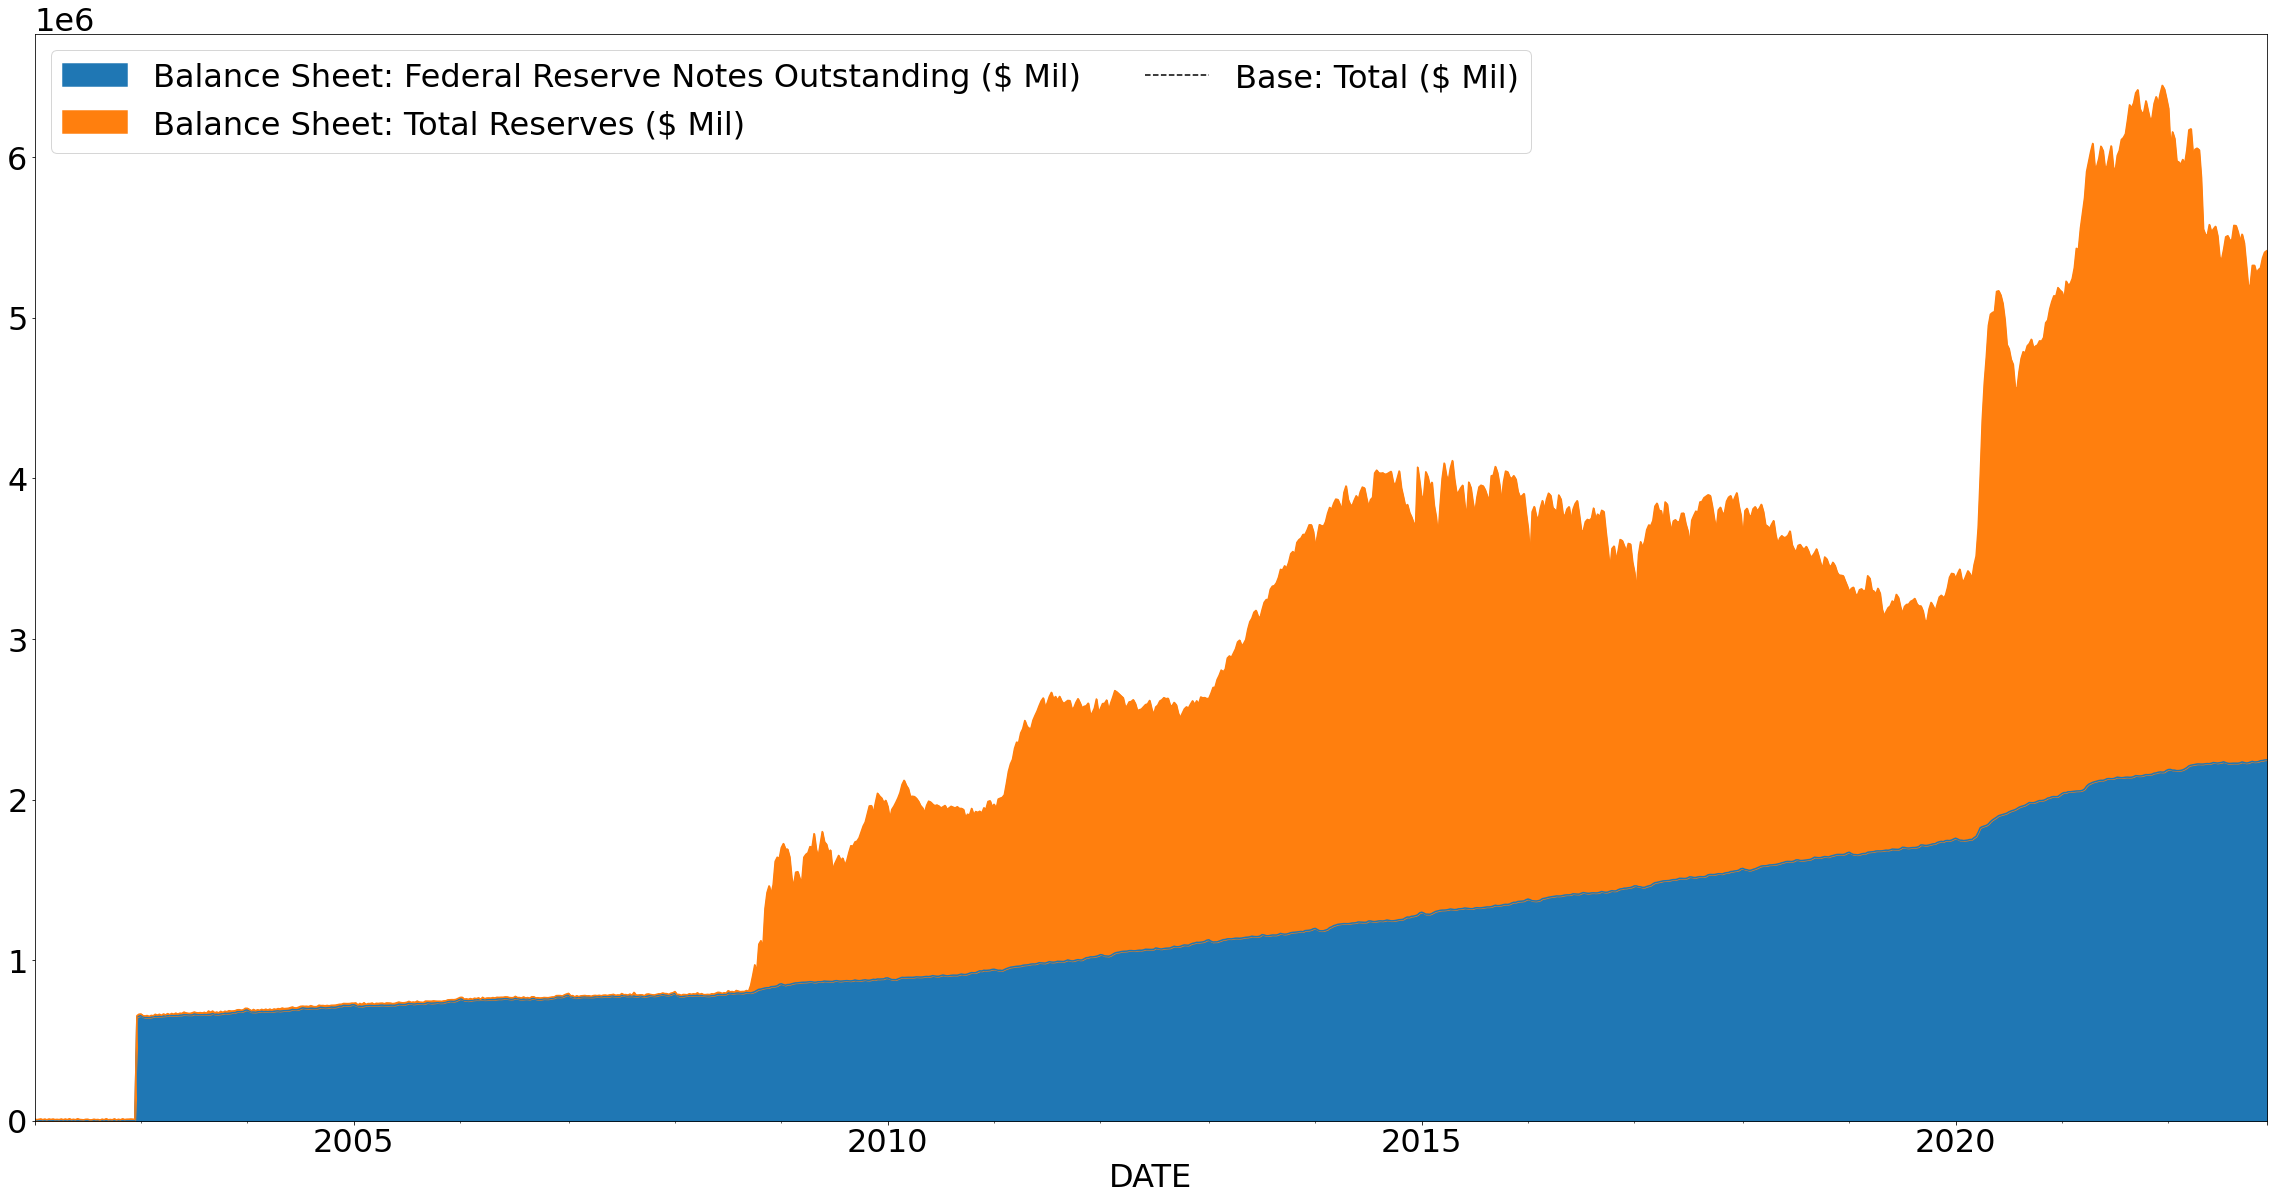

In [25]:
#fedProject
# . . . 
account_vars = ["Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)",
                "Balance Sheet: Total Reserves ($ Mil)"]

plot_stacked_lines(data, account_vars, linewidth = 1.5, total_var = "Base: Total ($ Mil)")

Alternately, we can conceive of all deposits held at the Fed as being divided between deposits from 1) depository institutions, 2) the U.S. Treasury General Account, 3) Other Deposit, as well as a small fraction of deposits not accounted for by 1-3.

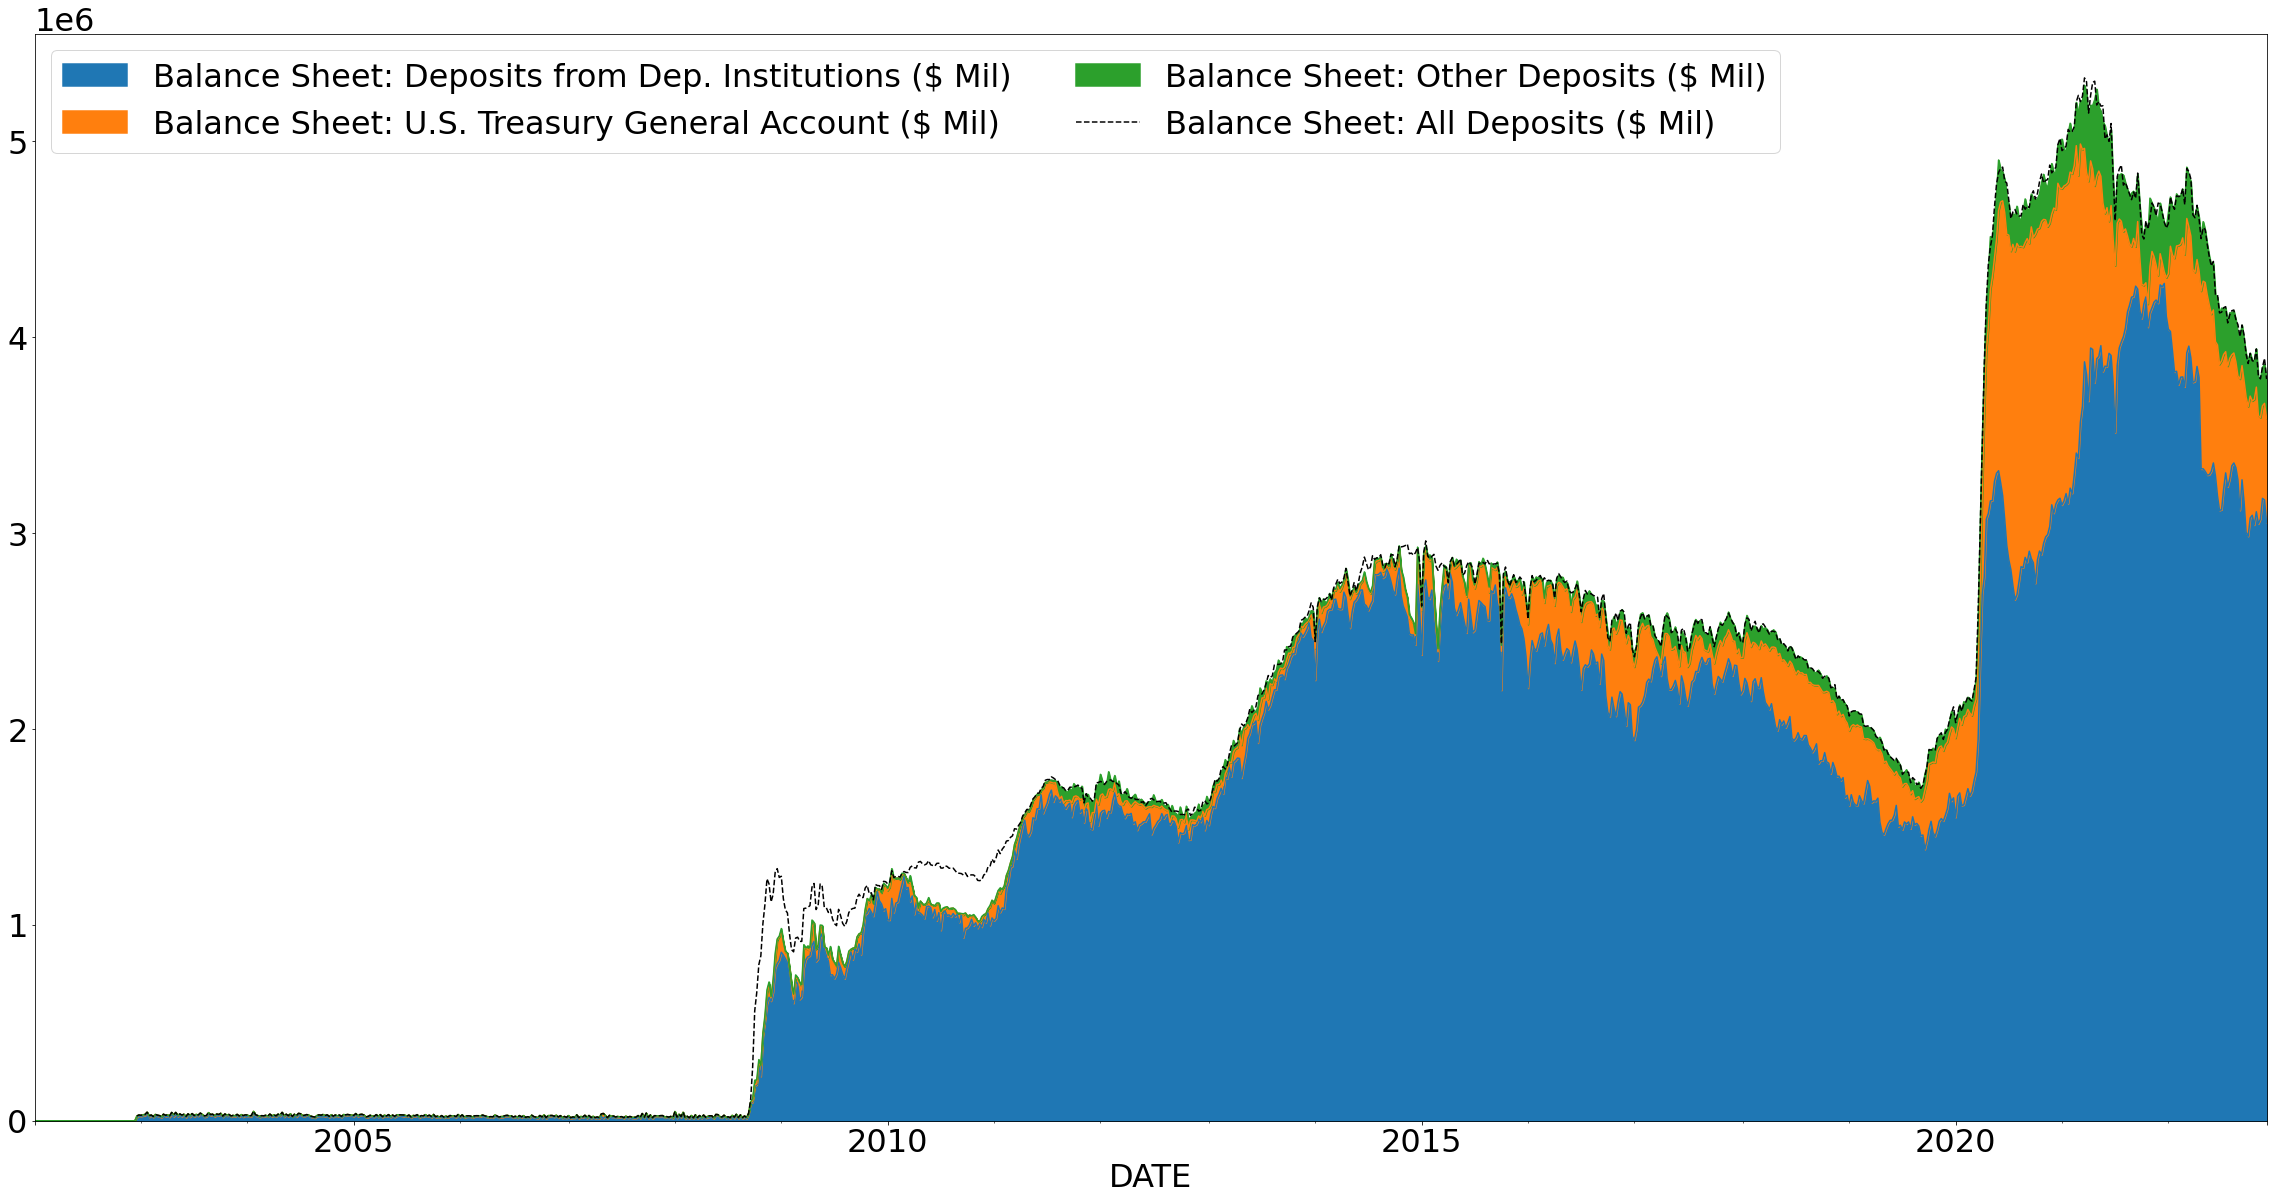

In [26]:
#fedProject
# . . . 
account_vars = ["Balance Sheet: Deposits from Dep. Institutions ($ Mil)",
                "Balance Sheet: U.S. Treasury General Account ($ Mil)",
                "Balance Sheet: Other Deposits ($ Mil)"]

plot_stacked_lines(data, account_vars, linewidth = 1.5, total_var = "Balance Sheet: All Deposits ($ Mil)")

Another way to conceptualize these two components of the liability side of the Fed's balance sheet is to compare them to the total level of deposits held at the Fed. So far, these two components have comprised that vast majority of deposits held at the Federal Reserve. And, together with Federal Reserve Notes Outstanding, deposits comprise a significant portion of the liabilities side of the balance sheet. They are therefore a good indicator of monetary policy. 

If we include liabilities from activity in the overnight lending market, taking the form of reverse repurchase agreements (reverse repos), we account for nearly the entire liabilities side of the balance sheet. 

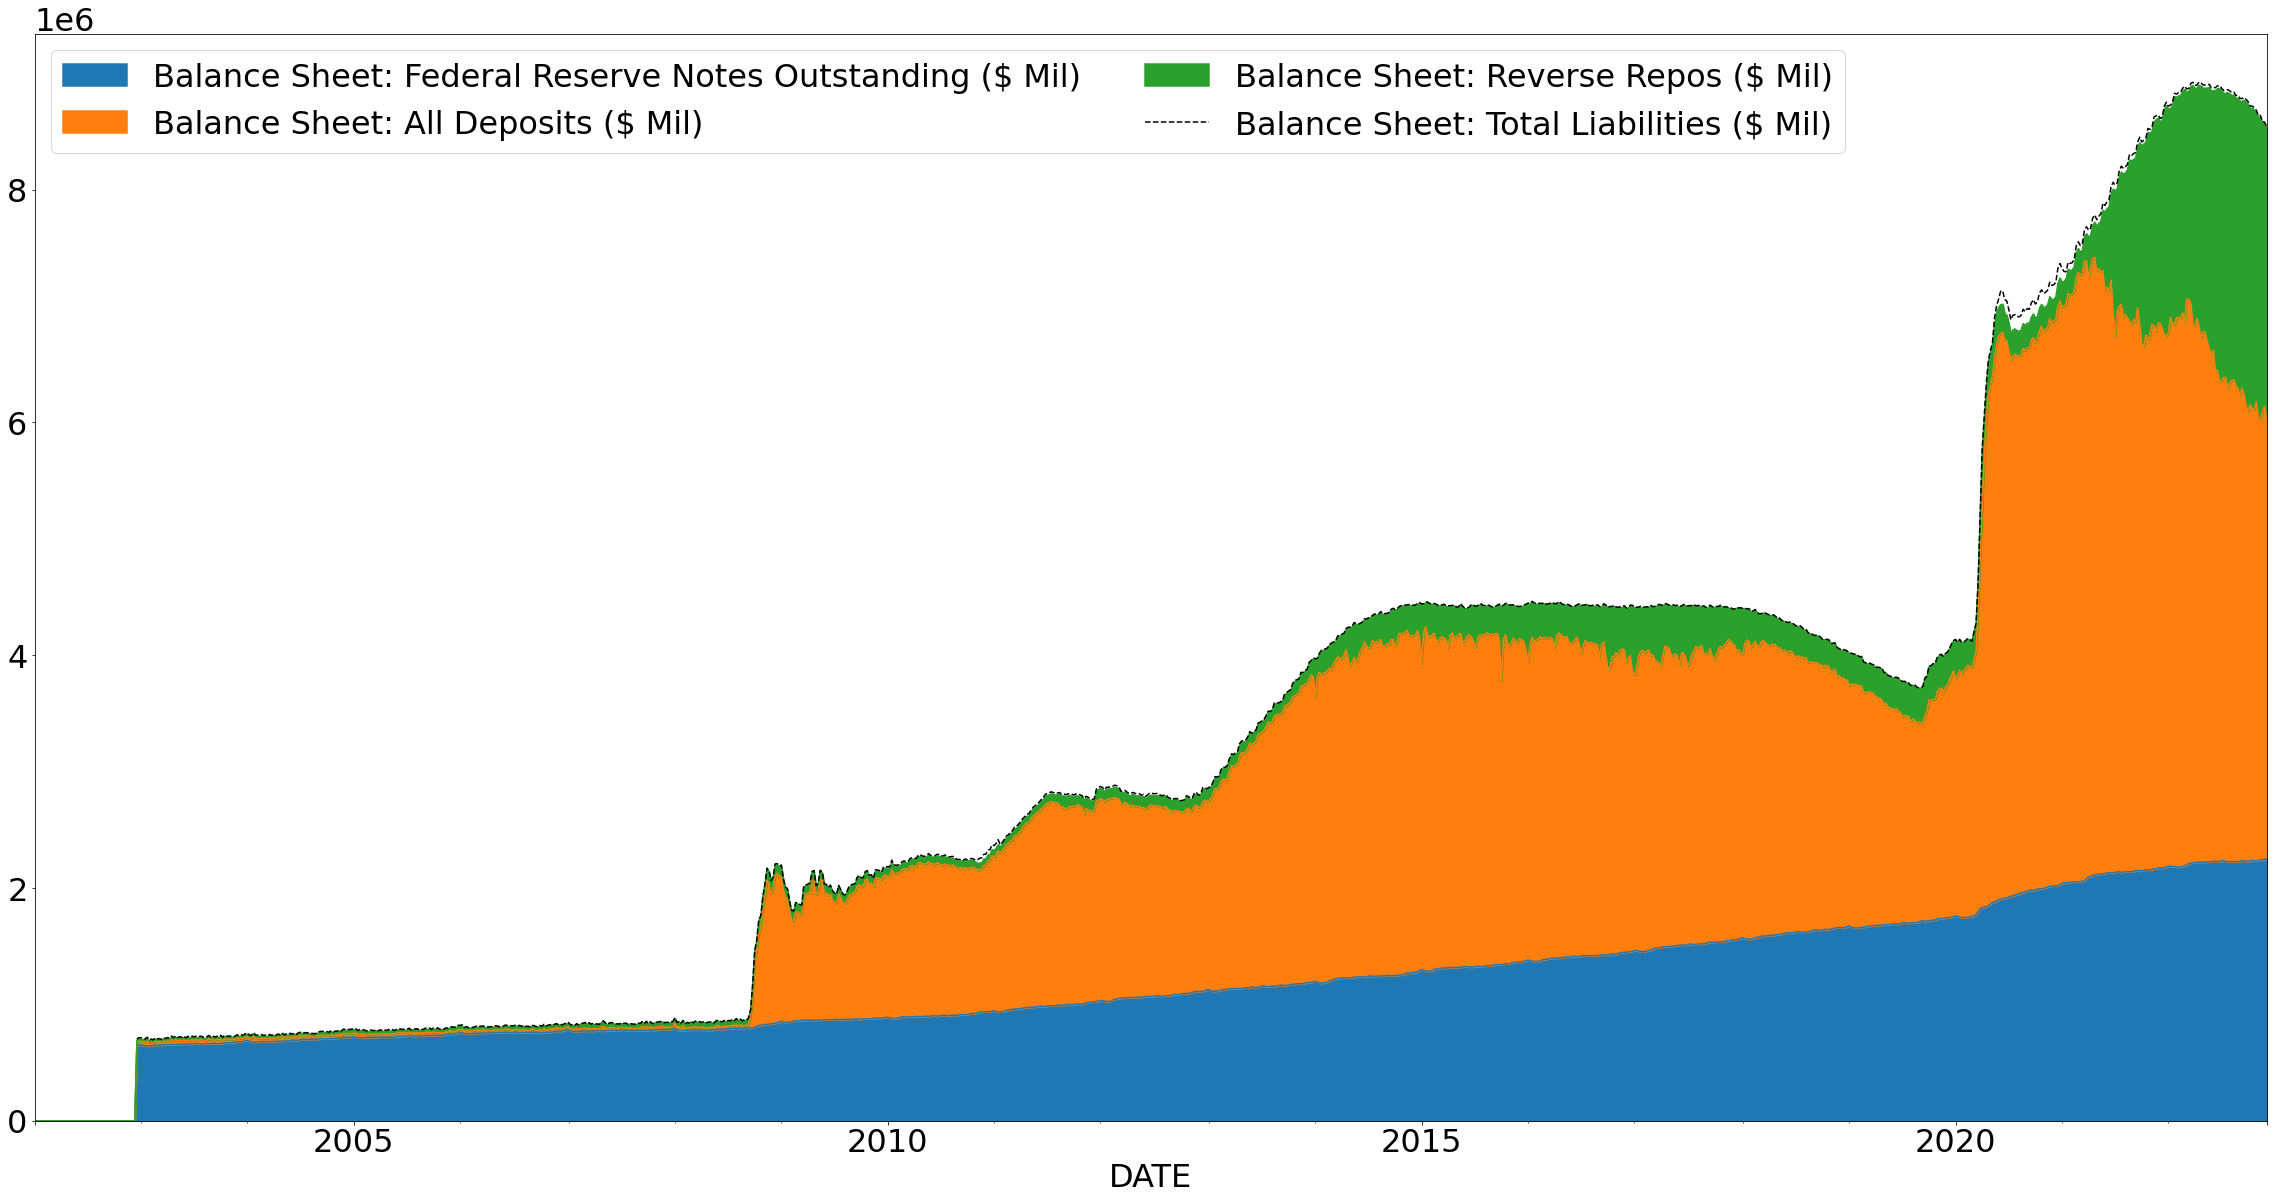

In [27]:
#fedProject
# . . . 
account_vars = ["Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)",
                "Balance Sheet: All Deposits ($ Mil)",
                "Balance Sheet: Reverse Repos ($ Mil)"]

plot_stacked_lines(data, account_vars, linewidth = 1.5, total_var = "Balance Sheet: Total Liabilities ($ Mil)")

## Overnight Lending and the Federal Funds Rate

A fair portion of the Federal Reserve's balance sheet is dedicated to influencing the overnight lending market. The overnight lending market is comprised of lending between banks with the intention of temporarily buffering changes in reserve levels. Before reserve requirements were zero, lending in this market occurred primarily to allow banks to maintain minimum reserve requirements. After reserve requirements were moved to zero, lending volumes in this market fell significantly.  

The Federal Reserve has multiple means of influencing this market. In the most general terms, the Federal Reserve can either lend to or borrow from investors in the overnight lending market. It lends in this market by accumulating repos. It borrows in the market by creating reverse repos. Repurchase agreements are reflected on the asset side of the Federal Reserve's balance sheet whereas reverse repruchase agreements are reflected on the liability side of the balance sheet. The Federal Reserve does not record this activity as influencing the quantity of base money, likely because operations in this market are thought to be temporary.

A good way to conceptualize the Fed's operations in this market is to account for the net effect of it's holdings of repos and reverse repos. We can plot these two values together and also account for the net effect.

C:\Users\JLCat\AppData\Local\Temp\ipykernel_5444\1524566044.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


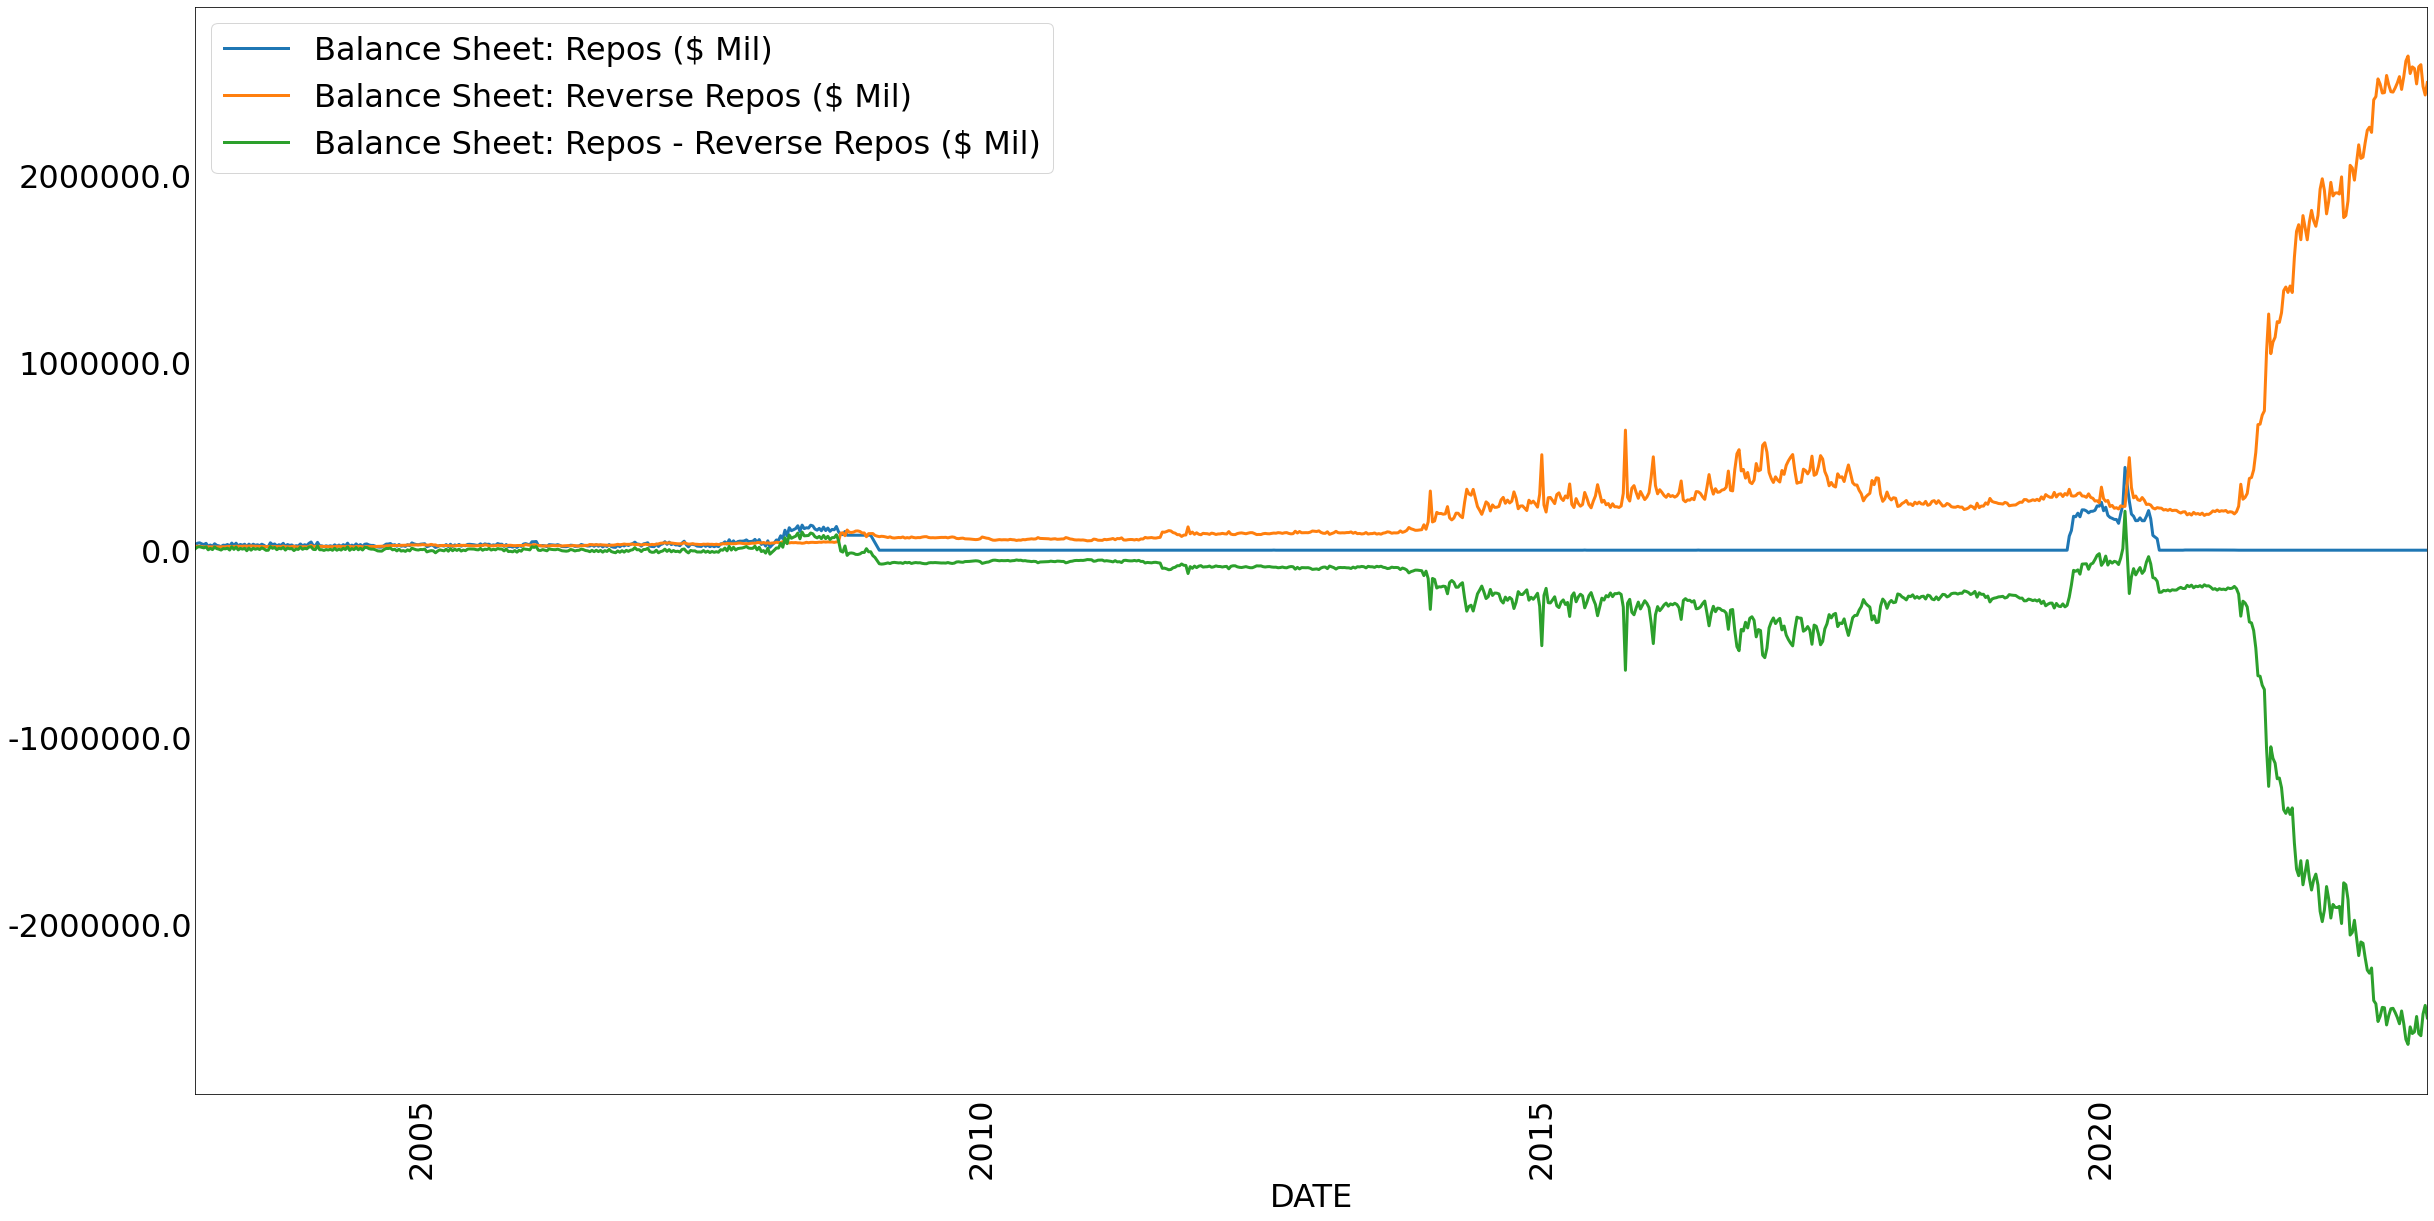

In [28]:
#fedProject.py
# . . . 
data["Balance Sheet: Repos - Reverse Repos ($ Mil)"] =\
    data["Balance Sheet: Repos ($ Mil)"].sub(data["Balance Sheet: Reverse Repos ($ Mil)"])
overnight_vars = ["Balance Sheet: Repos ($ Mil)",
                  "Balance Sheet: Reverse Repos ($ Mil)",
                  "Balance Sheet: Repos - Reverse Repos ($ Mil)"]

plot_lines(data[overnight_vars], linewidth = 3)
data[overnight_vars].to_csv("repoMarket.csv")

The Federal Reserve has been a net borrower in the overnight lending market. Since the value of its reverse repos is greater than the value of its repos, the overall effect of Fed operations in the overnight lending market has been to *decrease* the quantity of funds available to investors in that market.

### Federal Funds Rate, Interest on Excess Reserves, and Federal Reserve Influence over Interest Rates

The overnight lending market plays a key role in the setting of monetary policy by Federal Reserve. Monetary policy is typically enacted by the setting of interest rate targets. The Federal Reserves does not independently target different interest rates. Rather, it targets one rate and then may attempt to marginally influence other interest rates. 

The Fed attempts to influence the risk free rate of interest. Before the financial crisis of 2008, the risk free rate was thought to be the rate paid on short-term sovereign bonds (e.g., U.S. Treasuries). A similar approximation of the risk free rate is provided by the federal funds rate, the rate charged for overnight lending between banks. Except under extraordinary circumstance, as occurred when interbank lending slowed to a near halt in 2008, an overnight loan is expected to be able to be repaid by the borrowing bank without any difficulty. For this reason, the Federal Reserve 1) targets the federal funds rate and 2) attempts to maintain stability in the overnight lending market. We can think of the overnight lending and short-term U.S. Treasuries as near-perfect substitutes. 

In 2008, the Federal Reserve add a relevant alternative to these two instruments: deposit accounts that pay interest on excess reserves. Since the Federal Reserve is not at risk of going bankrupt (or it may be more appropriate to say, not in danger dollar devaluation due to fall value of its dollar assets relative to its liabilities), payment of interest on excess reserves is a true risk-free rate for investors, so long as interest rates are believed to compensate for costs from expected future inflation.

For nearly a decade, the Federal Reserve set the rate paid on excess reserves equal to federal funds rate. This made interest bearing deposit accounts at the Fed clearly superior to investment in the overnight lending market. More recently, this rate has moved marginally below the overnight lending rate. The difference between these since mid 2018 has been between 5 and 15 basis points (between .05 and .15).

C:\Users\JLCat\AppData\Local\Temp\ipykernel_5444\1524566044.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


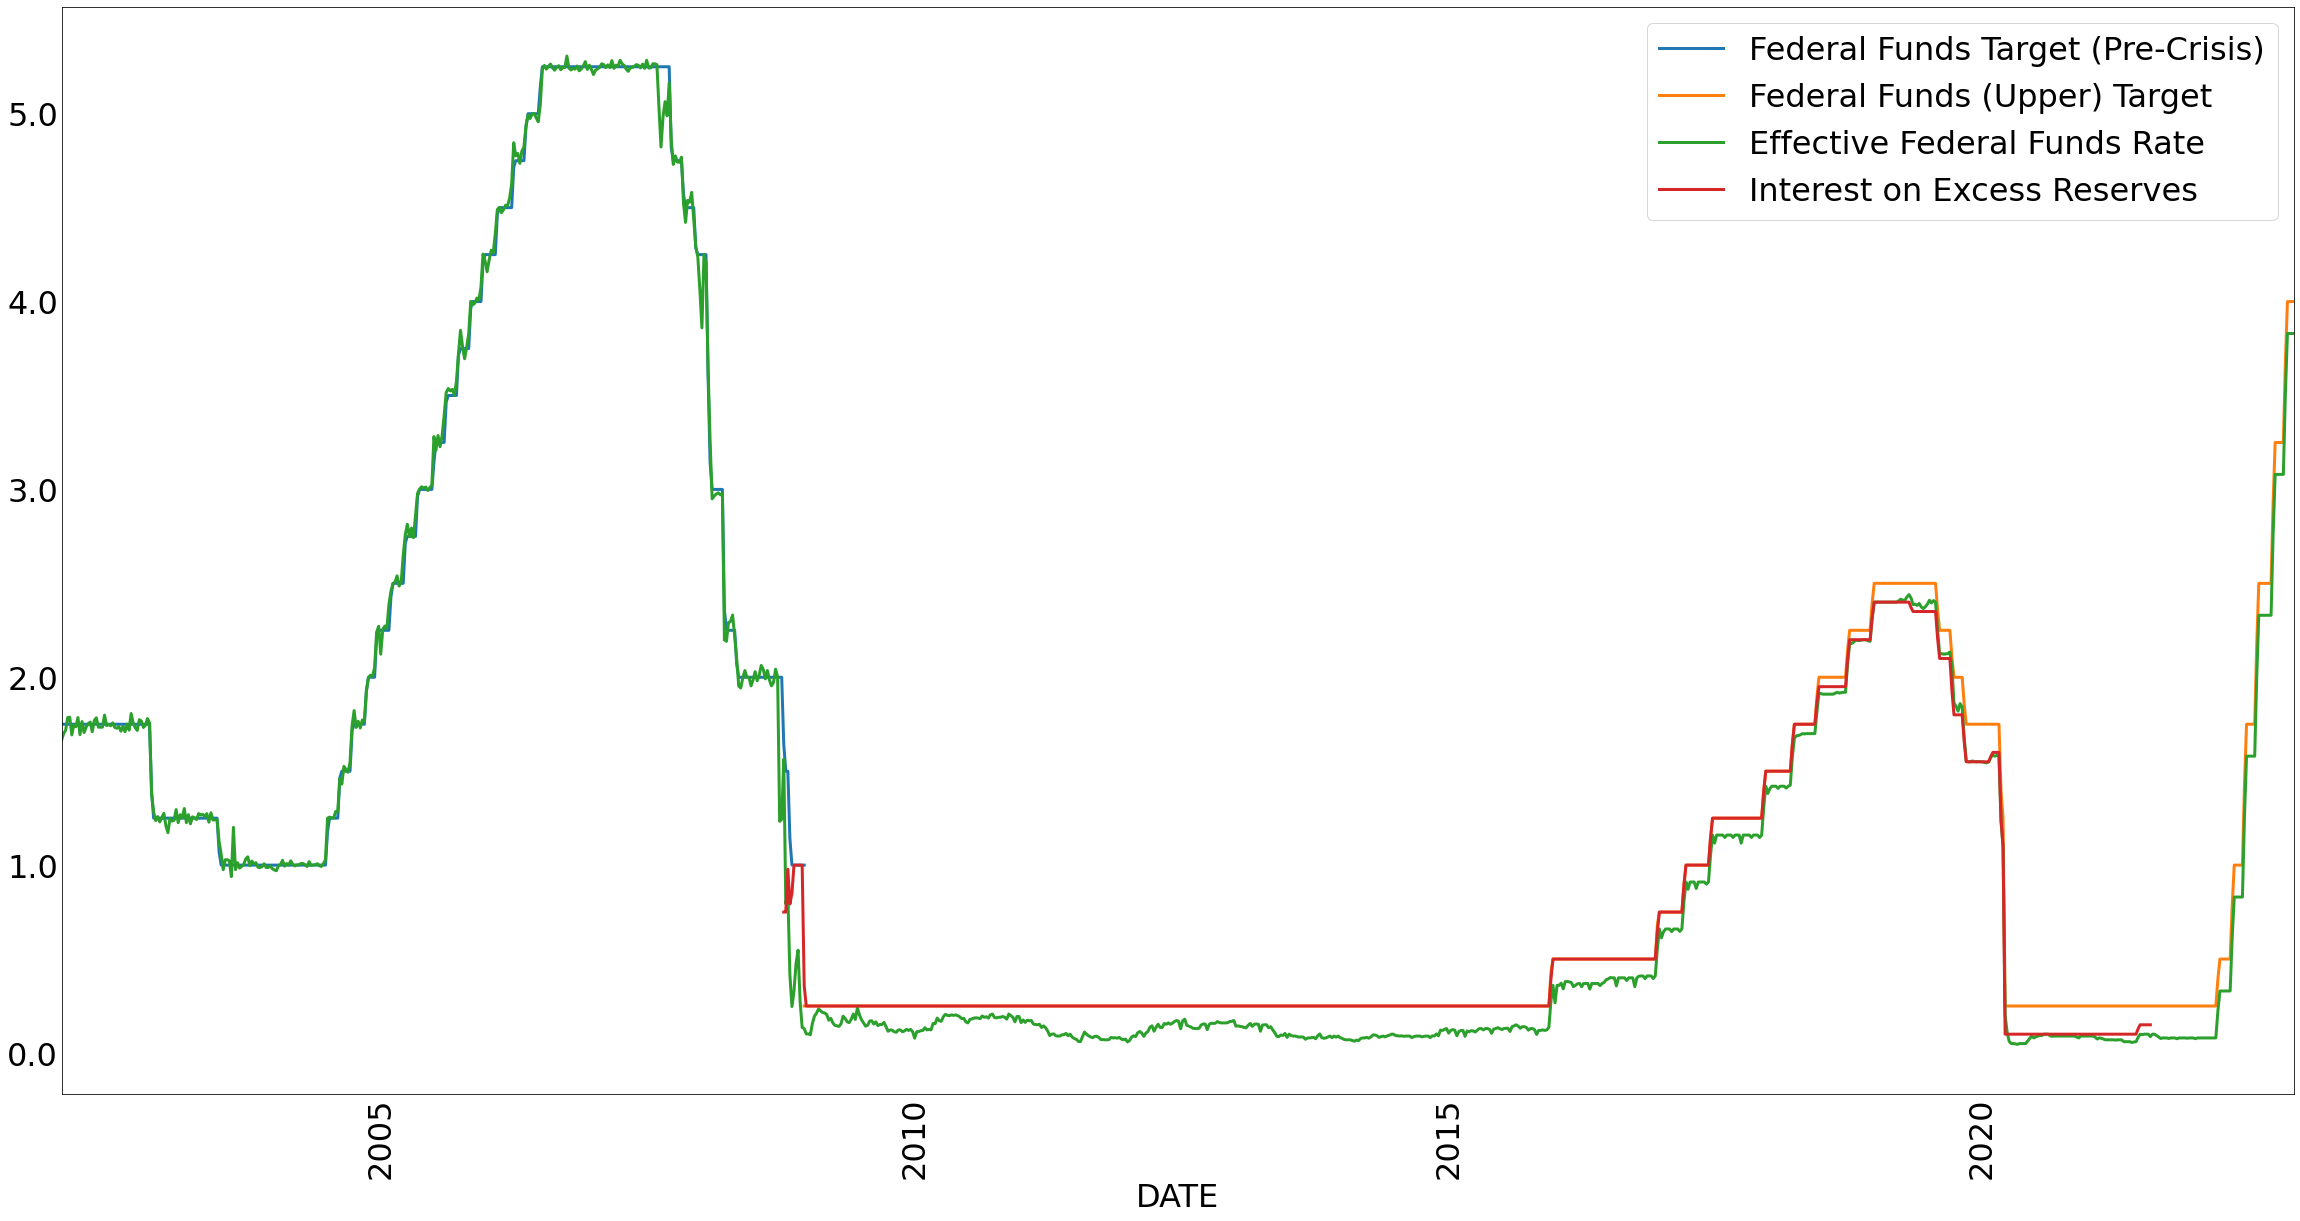

In [29]:
#fedProject.py
# . . . 
interest_vars = ["Federal Funds Target (Pre-Crisis)",
                  "Federal Funds (Upper) Target",
                  "Effective Federal Funds Rate",
                  "Interest on Excess Reserves"]
plot_lines(data[interest_vars], linewidth = 3)        


C:\Users\JLCat\AppData\Local\Temp\ipykernel_5444\3058134291.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()])


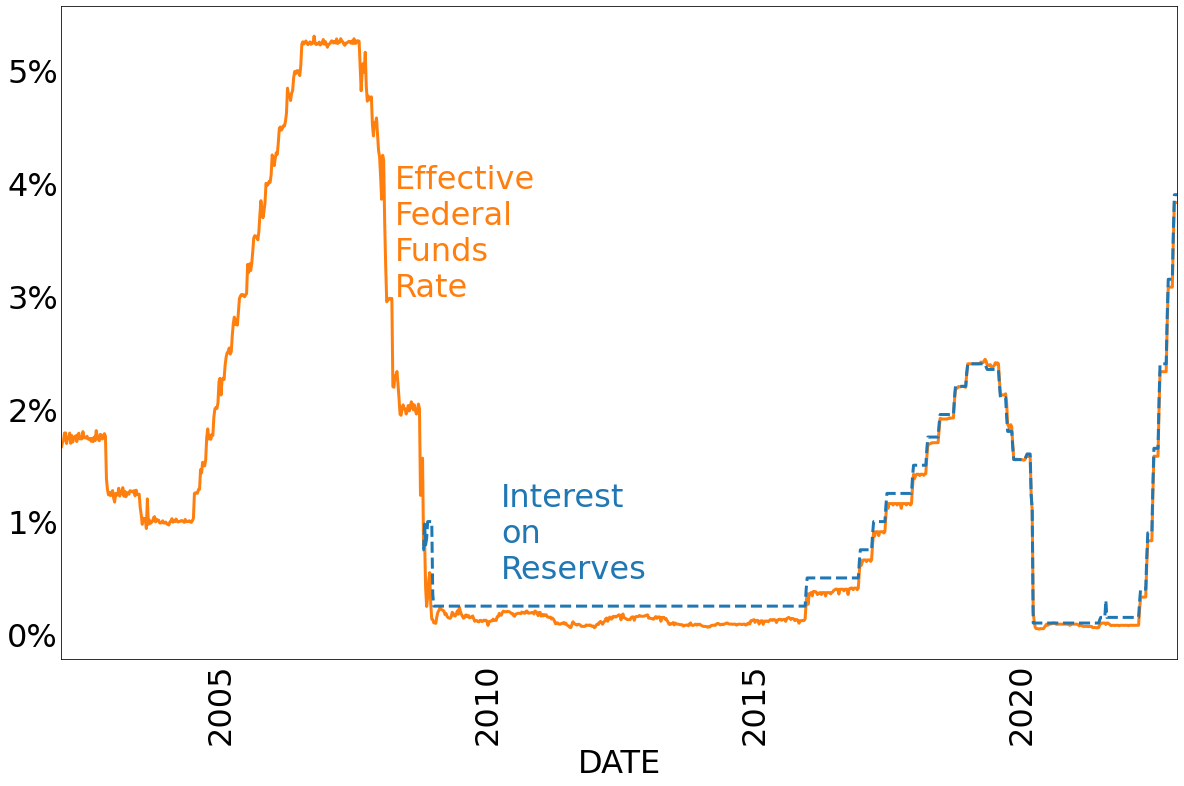

In [30]:
interest_vars = ["Effective Federal Funds Rate",
                  "Interest on Reserves"]
# plot_lines(data[interest_vars], linewidth = 3)        
fig, ax = plt.subplots(figsize = (20,12))
data[[interest_vars[0]]].plot(ax= ax, legend = False, linewidth = 3, color = "C1")
data[[interest_vars[1]]].loc["2008-10-08":].plot(ax= ax, 
                                                 legend = False, 
                                                 ls = "--", linewidth = 3, color = "C0")
ax.text("2008-04", 3, interest_vars[0].replace(" ","\n"), color = "C1")
ax.text("2010-04", .5, interest_vars[1].replace(" ","\n"), color = "C0")

ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()])
plt.xticks(rotation = 90)
ax.tick_params('both', length=0, which='both')

plt.show()

C:\Users\JLCat\AppData\Local\Temp\ipykernel_5444\3182479011.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()])


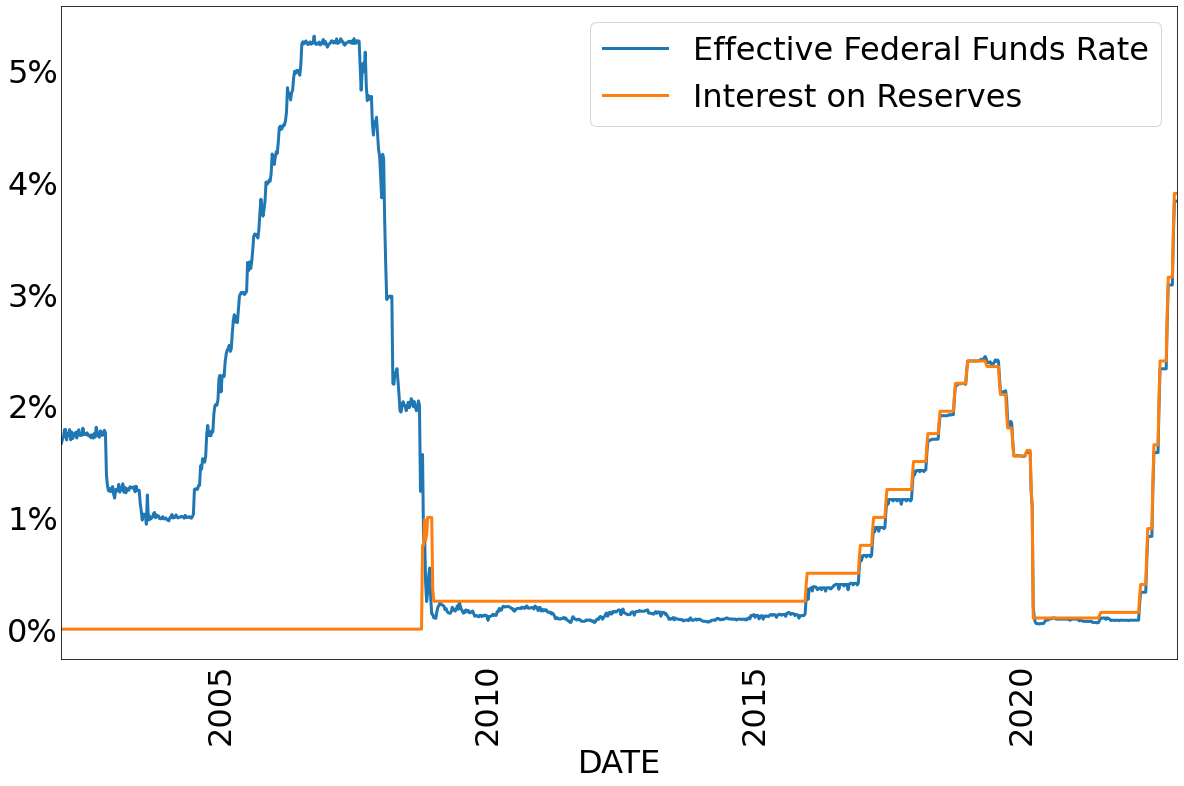

In [31]:
interest_vars = ["Effective Federal Funds Rate",
                  "Interest on Reserves"]
# plot_lines(data[interest_vars], linewidth = 3)        
data["Interest on Reserves"].loc["2021-08-01"] = 0.15
data[interest_vars].loc["2021-08-01":]
fig, ax = plt.subplots(figsize = (20,12))
data[interest_vars].plot(linewidth = 3, ax= ax)
ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()])
plt.xticks(rotation = 90)
ax.tick_params('both', length=0, which='both')

plt.show()

From early 2009 to mid 2018, banks had little incentive to lend overnight to one another since the rate paid on excess reserves was actually higher than the effective federal funds rate. After the Federal Reserve lowered the rate paid on excess reserves relative to the upper federal funds target, the effective federal funds rate has tended to be higher or at least equal to the rate paid on excess reserves. With the onset of the COVID-19 policy response, the federal funds rate briefly moved below the rate paid on excess reserves, but has again returned to equality with it.

## Conclusion

Having created a script for downloading and visualizing data from the Federal Reserve, you are in a position to better understand how monetary policy works. Before 2008, monetary policy might have been summed up by reference to only a few policy tools:

1. setting of the discount window (i.e., direct lending by the central bank)
2. open market operations (i.e., purchases and sales of sovereign debt)
3. setting of the  required reserve ratio
4. targeting of the federal funds rates

All of these elements still play a role in monetary policy. Now, they interact with a much larger set of strategies and financial instruments and facilities. Most important, the Federal Reserve has begun to manage demand for money in by offering interest bearing deposit accounts.

This lesson has simplified monetary policy, viewing all operations as amounting to:
1. loans from the central bank to the market
2. borrowing from the central bank, often in the form of deposit accounts
3. targeting of interest rates by adjusting rates of interest paid to depositors and through operations in the overnight lending market

Furthermore, the increase in the variety of instruments held by the Federal Reserve has allowed it to target particular markets, namely, the home mortgage market in the U.S.. The expansion of the Federal Reserve's balance sheet has also allowed it to significantly increase its support of Federal borrowing. In the process, its ability and willingness to cooperate with the U.S. Treasury has greatly increased since the policy regime change that occurred starting in 2008.

## Homework

1. Download and plot 3 apparently related sets of data with at least. Each set should contain at least two related variables. You should explain *how* variables in each set of data are related. Plot each set using the scatter plot function *and* the line graph function. For example, you might the obseved rate of unemployement and the natural rate of unemployment in the same graph. To find data, search for data at FRED and use the code associated with the data. For example, the [CPI measure that includes urban items](https://fred.stlouisfed.org/series/CPIAUCSL) is identified by the code, *CPIAUCSL*.

2. Create a correlation matrix for quarterly observations of Nominal GDP, Real GDP, the Price Level (CPI or GDP Deflator), the quantity of currency in circulation and the federal funds rate for as large of a date range as possible. Then, calculate the year-over-year percent change for each each variable and save the results as variables in the same dataframe. Create a correlation matrix for these new variables.

How has the correlation between each variable changed? Why do you think the correlation changes after calculate the year-over-year percent change?

*ECON 611 Only*

3. Download data for 1 Year, 2 Year, 5 Year, 10 Year, and 30 Year U.S. Treasuries (Constant Maturity Rates). Create a function that builds a curve with the rate of return for each maturity on a given date. The [yield curve](https://github.com/jlcatonjr/Learn-Python-for-Stats-and-Econ/blob/master/Projects/Federal%20Reserve%20Data/Yield%20Curve%20(Daily%20Data).ipynb) is a plot that indicates the change in rate of interest given an increase in maturity. In this case, the horizontal axis would stretch from 1 to 30, with the relevant rate plotted for each maturity. (Hint: You will use the .loc[date] to call and plot your data by date.) Create a plot for every month and save each plot with the date marked [in a single pdf](https://stackoverflow.com/questions/21364405/saving-plots-to-pdf-files-using-matplotlib).

4. Plot all of the variables from (3) in a single time series line plot. Indicate using shaded regions ([example](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html)) any period where the 5 Year rate is less than the 1 year rate. Save this plot in the same pdf that you used in (3).

In [38]:
data_codes  = {"1 M (%)": "DGS1MO",
               #"2 Month (%)": "DGS2MO",
               "3 M (%)": "DGS3MO",
               "6 M (%)": "DGS6MO",               
               "1 Y (%)": "DGS1",
               "2 Y (%)": "DGS2",
               "3 Y (%)": "DGS3",
               "5 Y (%)": "DGS5",
               "7 Y (%)": "DGS7",
               "10 Y (%)": "DGS10",
               "20 Y (%)": "DGS20",
               "30 Y (%)": "DGS30",
               "Federal Funds Target (Pre-Crisis)": "DFEDTAR",
               "Federal Funds (Upper) Target":"DFEDTARU",
               "Effective Federal Funds Rate":"DFF",
               "Interest on Excess Reserves":"IOER"}

# Select start and end dates
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
data = gather_data(data_codes = data_codes, start = start, end = end, freq = "M")


In [50]:
curve_keys = list(data_codes.keys())[:11]
curve_keys

['1 M (%)',
 '3 M (%)',
 '6 M (%)',
 '1 Y (%)',
 '2 Y (%)',
 '3 Y (%)',
 '5 Y (%)',
 '7 Y (%)',
 '10 Y (%)',
 '20 Y (%)',
 '30 Y (%)']

In [52]:
data[curve_keys].loc["2020-01"]#plot(ax = ax)

1 M (%)   3 M (%)   6 M (%)   1 Y (%)   2 Y (%)   3 Y (%)  \
DATE                                                                     
2020-01-31  1.533333  1.552381  1.563333  1.532857  1.519048  1.518095   

             5 Y (%)   7 Y (%)  10 Y (%)  20 Y (%)  30 Y (%)  
DATE                                                          
2020-01-31  1.562381  1.669524  1.757619  2.067143   2.21619

<AxesSubplot:>

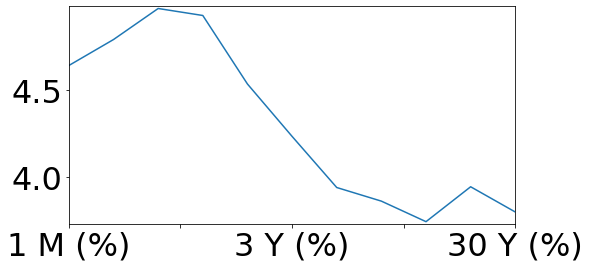

In [63]:
fig, ax = plt.subplots(figsize = (8,4))
data[curve_keys].loc["2023-02"].T.plot.line(legend = False, ax = ax)

In [65]:
pp = PdfPages("YieldCurveExample.pdf")
for ix in data.index:
    fig, ax = plt.subplots(figsize = (8,4))
    data[curve_keys].loc[ix].plot(ax = ax)
    ax.set_title(str(ix)[:7])
    pp.savefig()
    plt.close()
pp.close()

## Appendix

Returning to the earlier, significant interventions in the mortgage market, we will close by dividing the Fed's assets between:

1. U.S. Treasuries
2. Mortgage Backed Securities
3. Direct Lending to Private and Central Banks
4. Repurchase Agreements
5. Unamortized Security Premiums
6. Everything Else

In [33]:
plt.rcParams['axes.ymargin'] = 0.01
plt.rcParams['axes.xmargin'] = 0.00
def stack_hatch(df, total_var = None, ylabel = "$ Trillion", 
                hatches = ['|', '-', '/', '\\', '+',  'O', '.', '*'], 
                loc = "upper left",
                colors = ["C0", "C1", "C2", "C4", "C5", "C6", "C7","C8", "C9"],
                ncol = 2):
    keys = list(df.keys())
    keys.remove(total_var)
    print(keys)
    fig, ax = plt.subplots(figsize = (30,15))
    for i in range(len(keys)):
        key = keys[i]
        if i > 0:
            for j in range(i):
                if j == 0:
                    base = df[keys[j]] 
                else:
                    base = base.add(df[keys[j]])
            ax.fill_between(df.index, base, df[key].add(base),
                            facecolor = colors[i],
                            hatch=hatches[i], 
                            alpha = 1 - i * .075, 
                            label = key)
            
        else:
            ax.fill_between(df.index, [0] * len(df.index), df[key],facecolor = colors[i],
                                             hatch=hatches[i], label = key)
            
    if total_var != None:
        ax.plot(df[total_var], label = total_var, linewidth = 2, linestyle = "--",  color = "k")
    ax.legend(loc = loc, ncol = ncol, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 40)
    ax.tick_params('both', length=0, which='both')


Text(0.5, 1.0, 'Federal Reserve Balance Sheet: Assets')

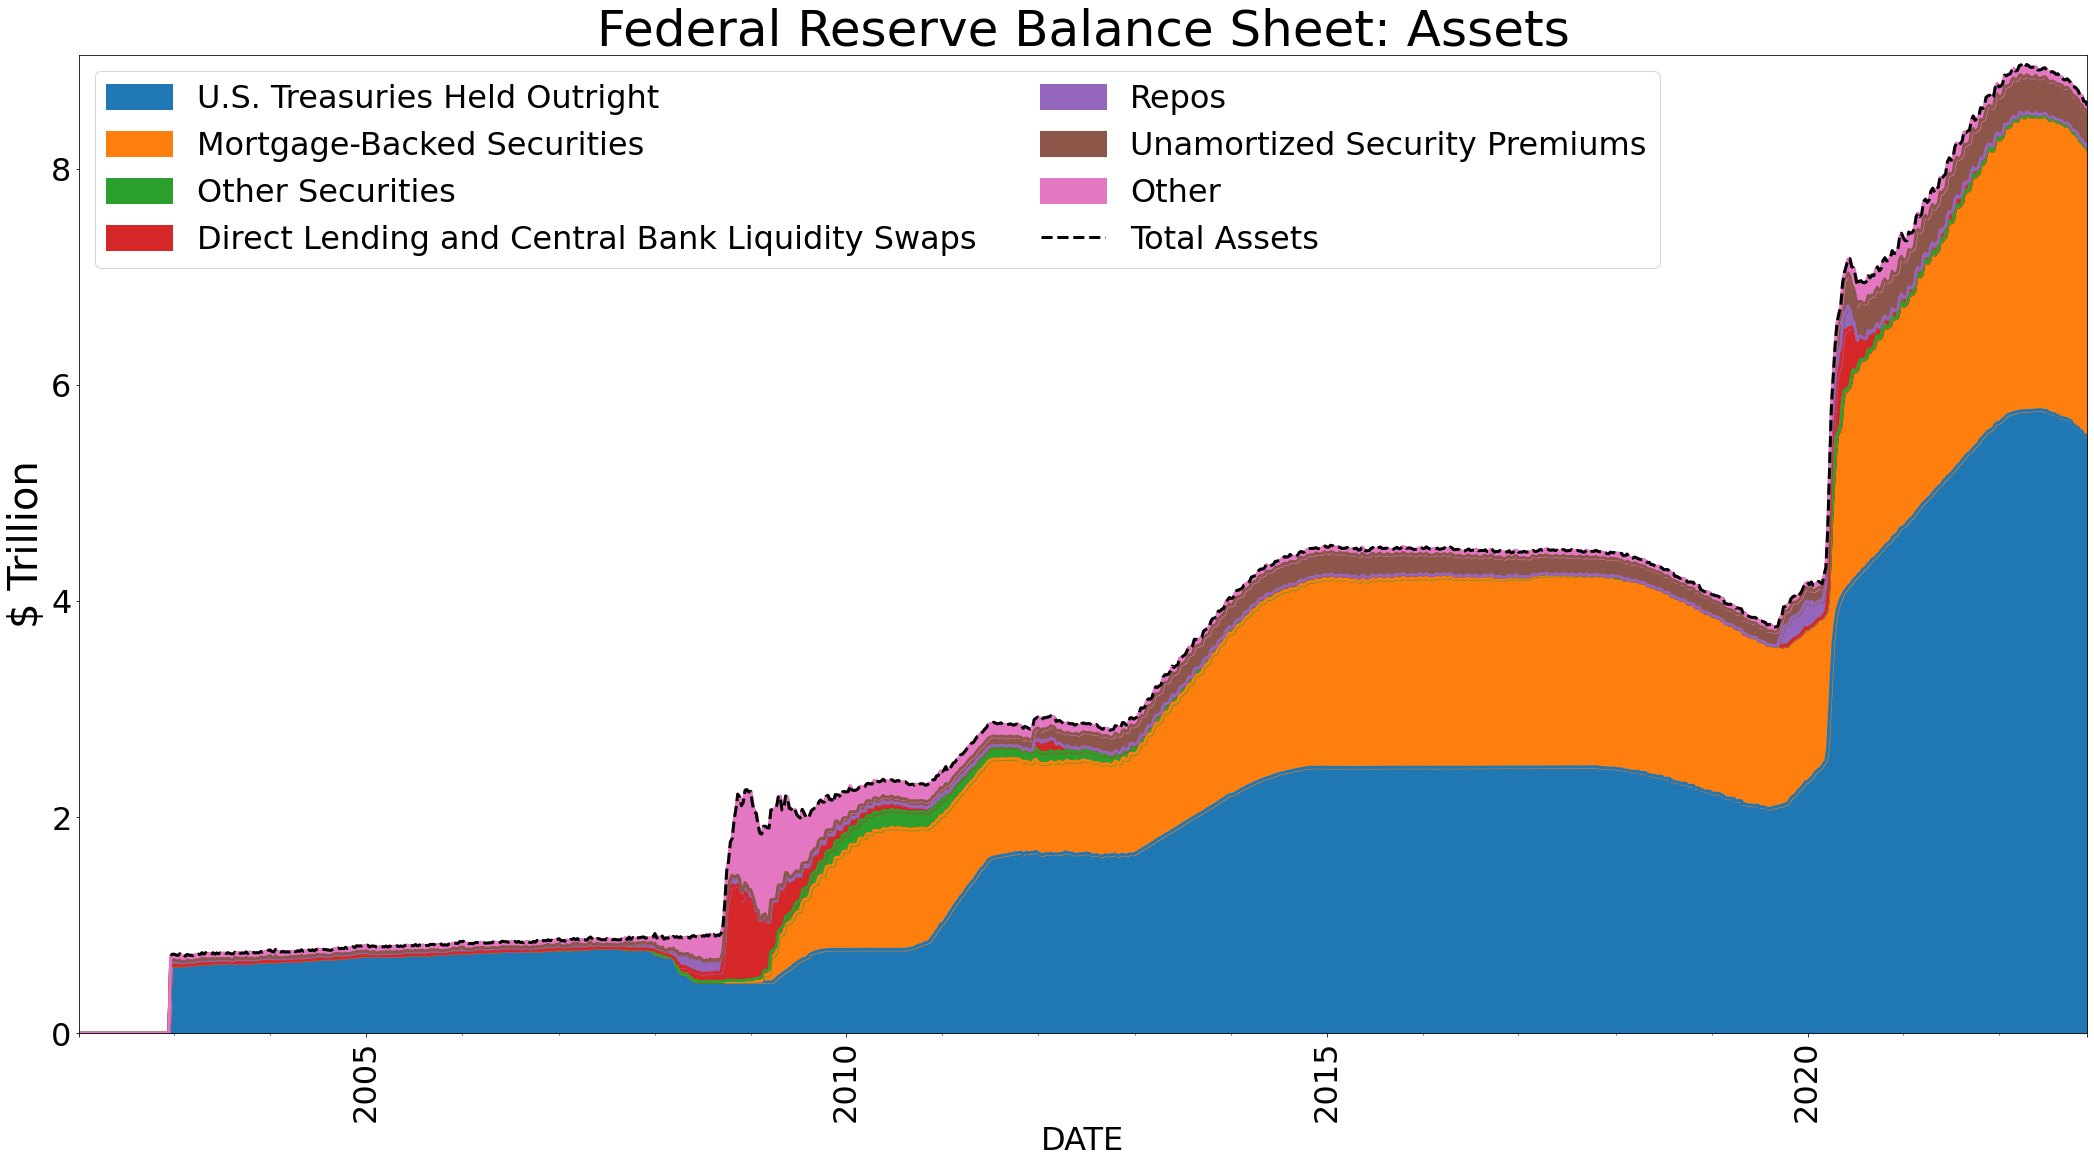

In [34]:
#fedProject
# . . . 
data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"] =\
    data["Balance Sheet: Central Bank Liquidity Swaps ($ Mil)"].add(
    data["Balance Sheet: Direct Lending ($ Mil)"])
data["Balance Sheet: Other Securities"] = data["Balance Sheet: Securities Held Outright ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasuries Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Mortgage-Backed Securities ($ Mil)"])
data["Balance Sheet: Other"] = data["Balance Sheet: Total Assets ($ Mil)"].sub(
    data["Balance Sheet: Securities Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"]).sub(
    data["Balance Sheet: Repos ($ Mil)"]).sub(
    data["Balance Sheet: Unamortized Security Premiums ($ Mil)"])

account_vars = ["U.S. Treasuries Held Outright",
               "Mortgage-Backed Securities",
               "Other Securities",
               "Direct Lending and Central Bank Liquidity Swaps",
               "Repos",
               "Unamortized Security Premiums",
               "Other"]
plot_data = data.rename(columns = {
    key: key.replace("Balance Sheet: ", "").replace(" ($ Mil)", "") for key in data.keys()})
for key, val in plot_data.items():
        plot_data[key] = val.div(10**6)

figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Assets"
plot_data[total_var].plot.line(linewidth = 3, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Assets", fontsize = 50)

['U.S. Treasuries Held Outright', 'Mortgage-Backed Securities', 'Other Securities', 'Direct Lending and Central Bank Liquidity Swaps', 'Repos', 'Unamortized Security Premiums', 'Other']


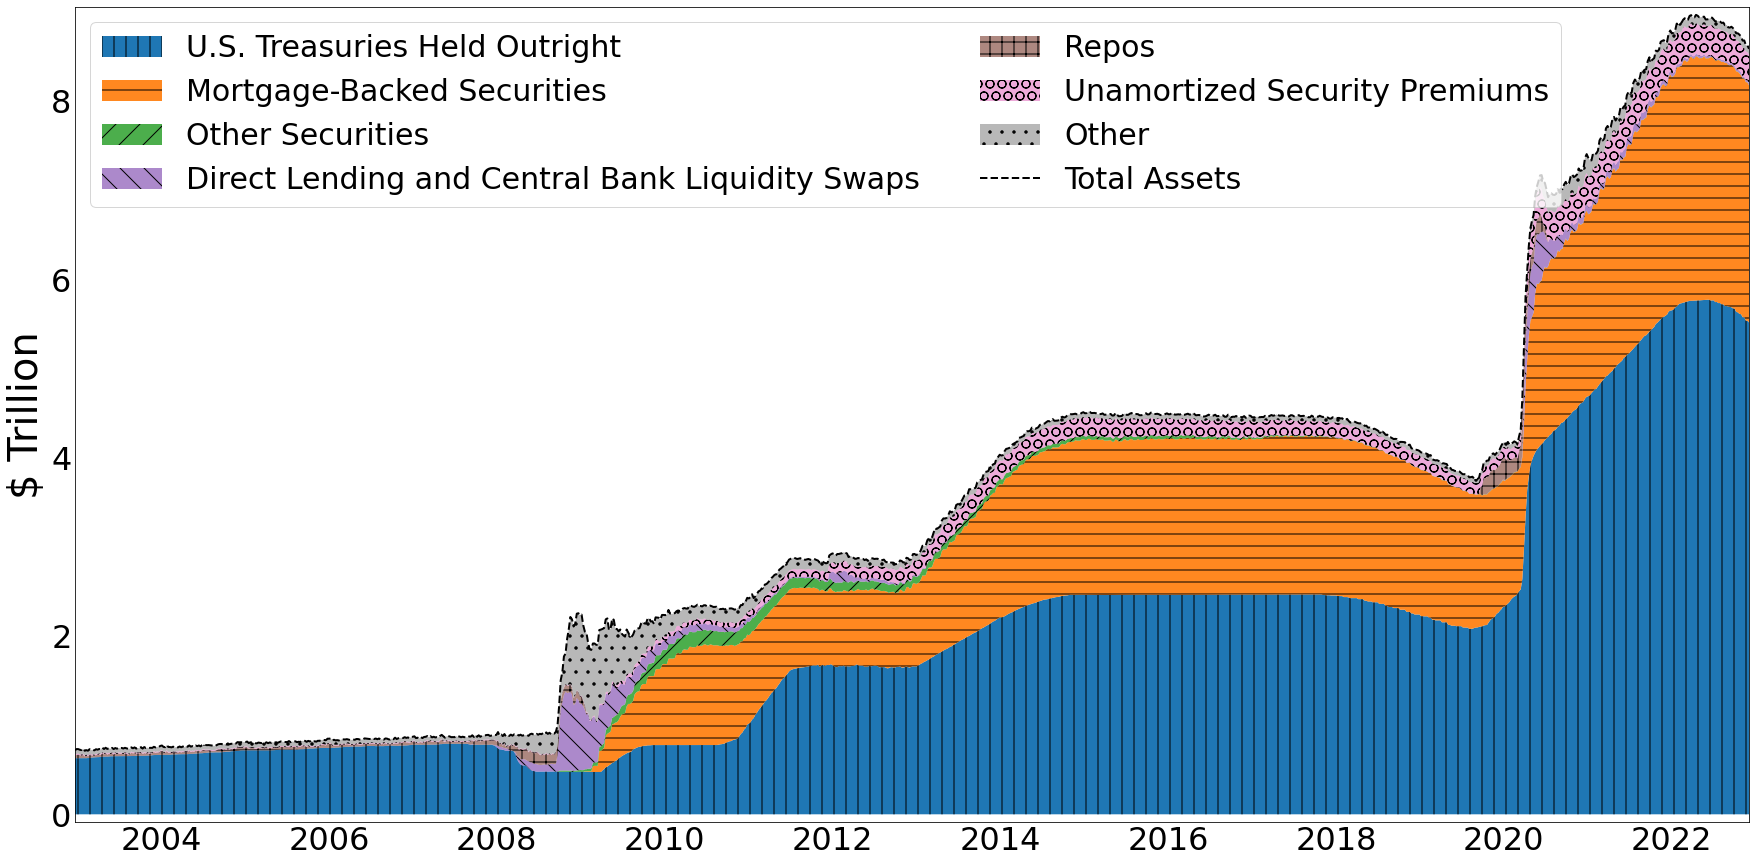

In [35]:
stack_hatch(plot_data[account_vars + [total_var]], total_var  )

Text(0.5, 1.0, 'Federal Reserve Balance Sheet: Liabilities')

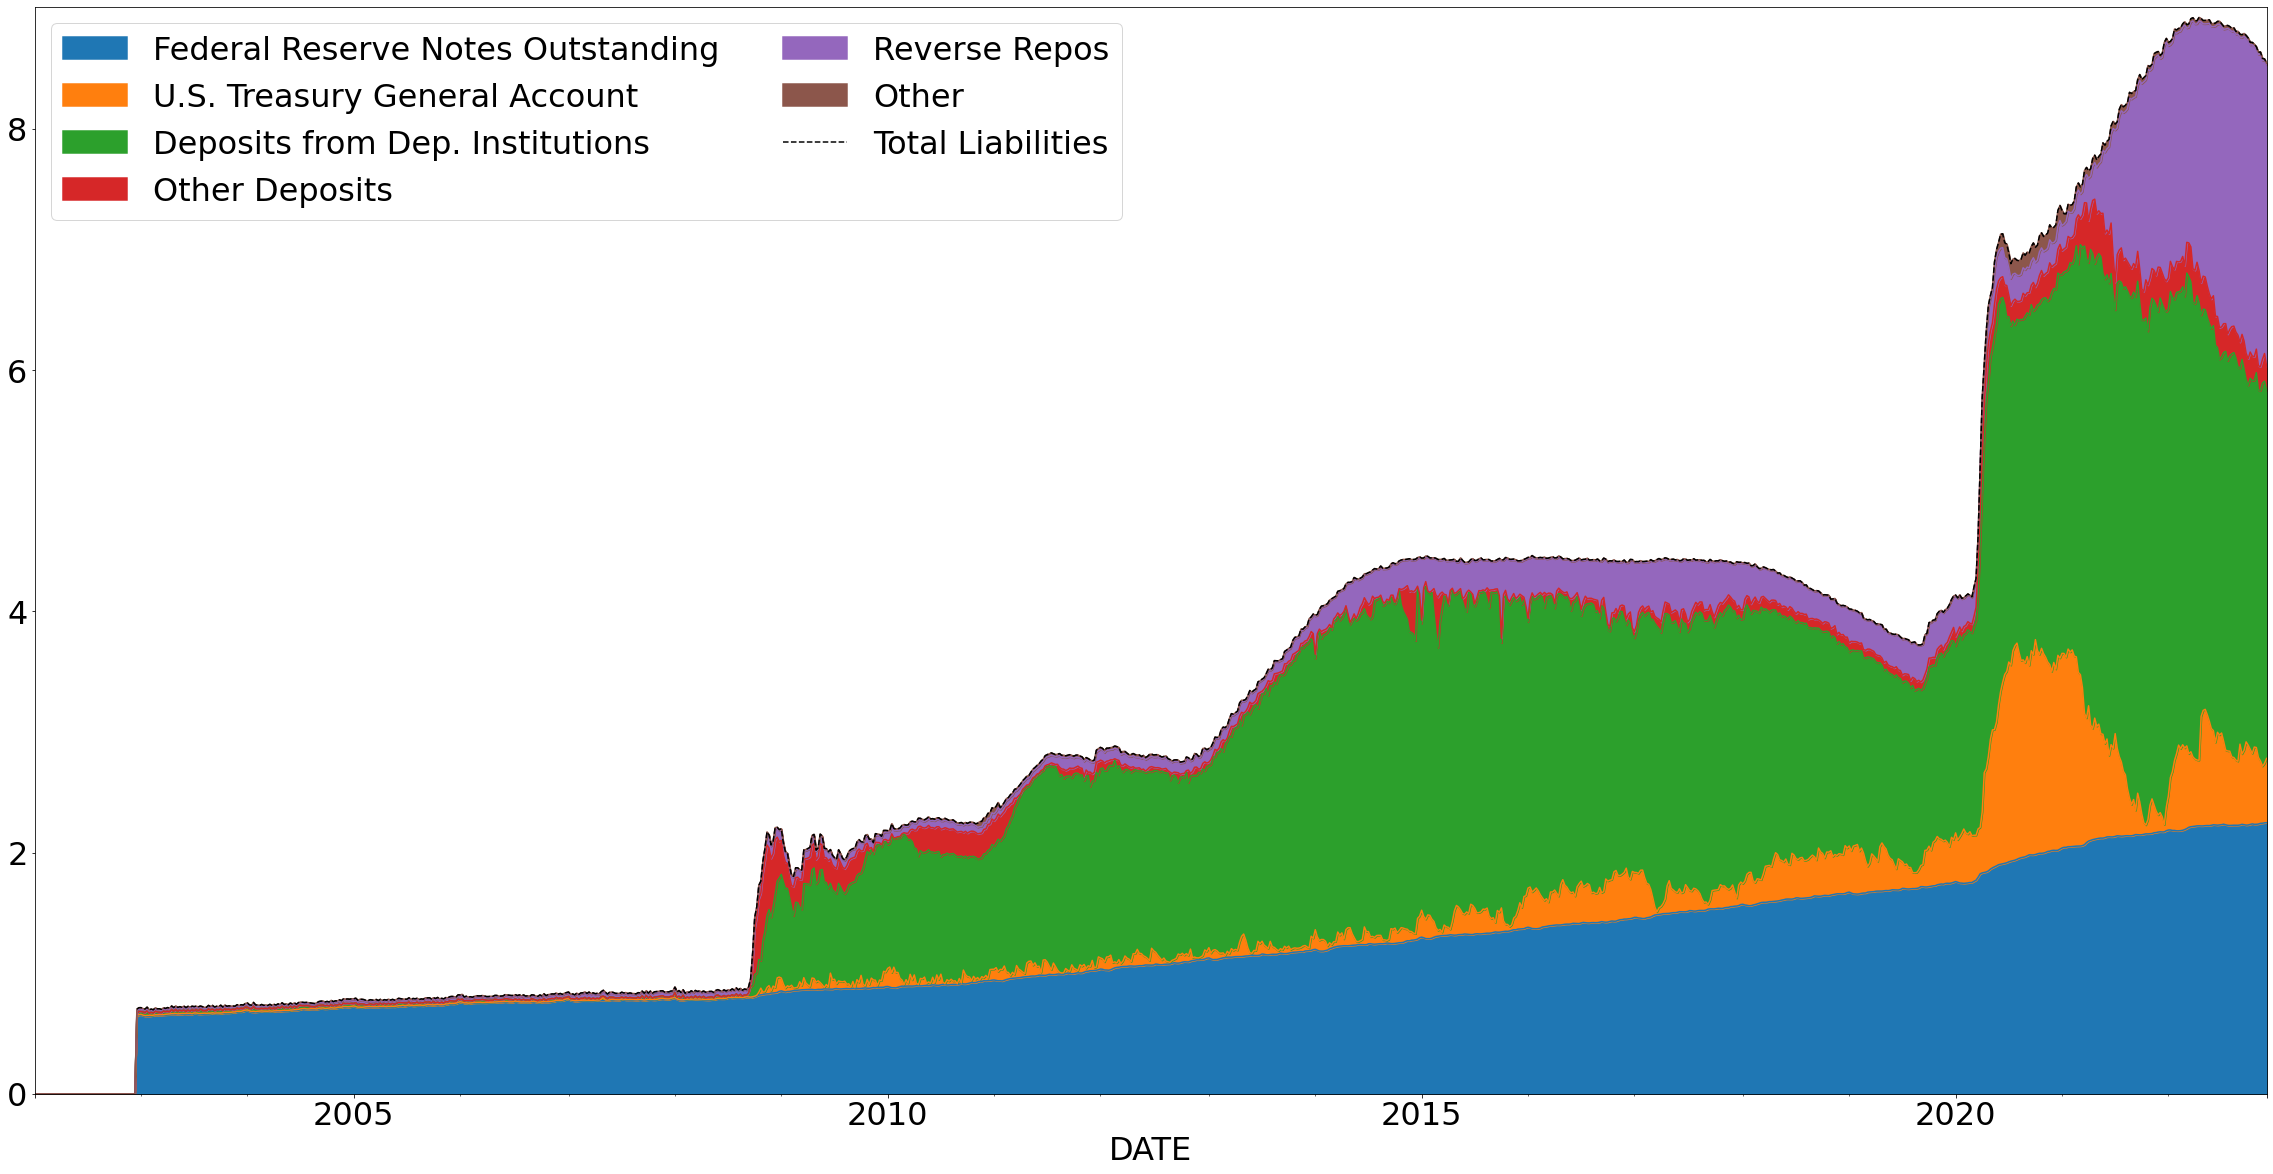

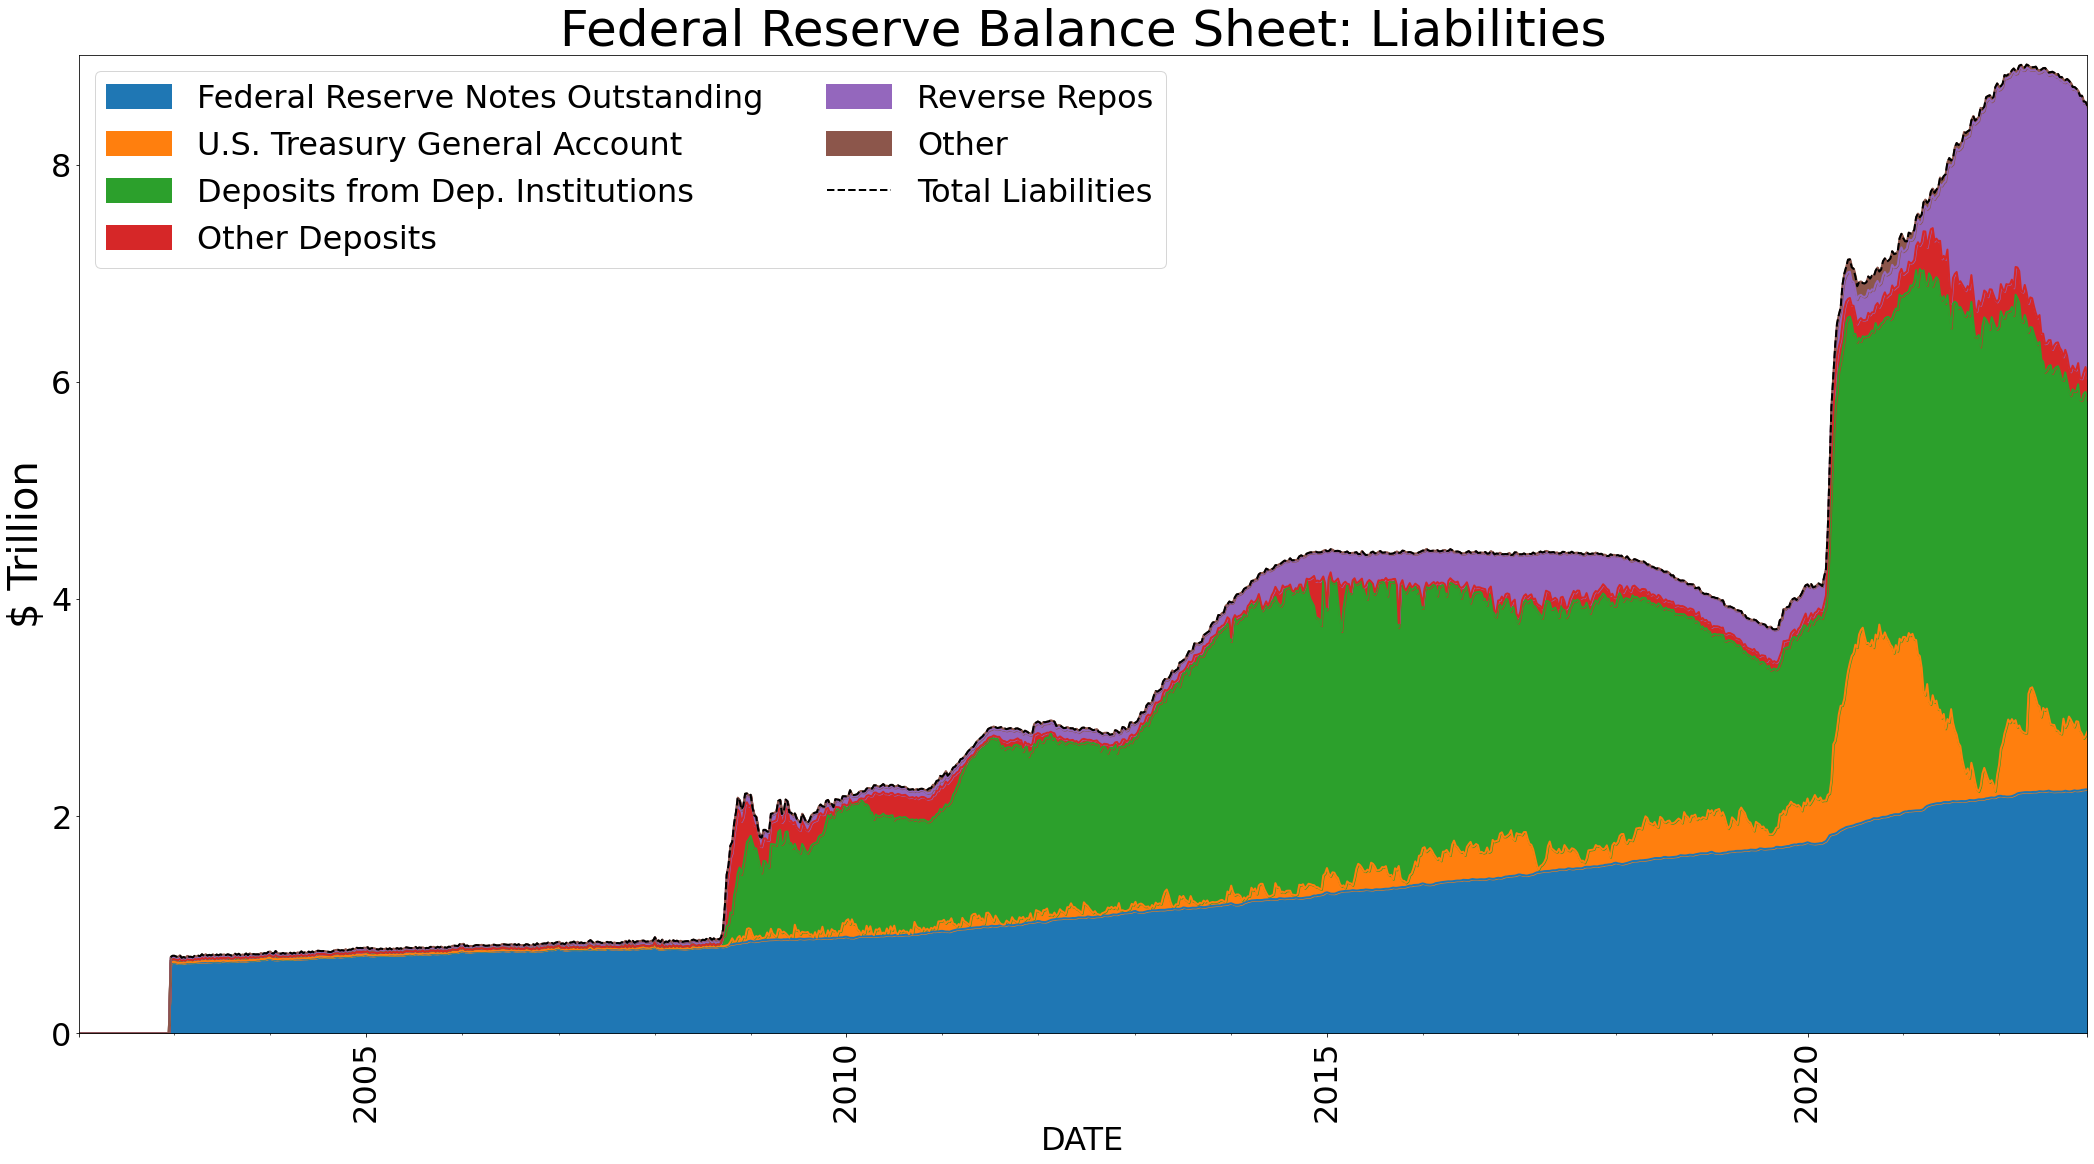

In [36]:
data["Balance Sheet: Other Deposits ($ Mil)"] = data["Balance Sheet: All Deposits ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"])
data["Balance Sheet: Other"]= data["Balance Sheet: Total Liabilities ($ Mil)"].sub(
    data["Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)"]).sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"]).sub(
    data["Balance Sheet: Other Deposits ($ Mil)"]).sub(
    data["Balance Sheet: Reverse Repos ($ Mil)"])

account_vars = ["Federal Reserve Notes Outstanding",
                "U.S. Treasury General Account",
                "Deposits from Dep. Institutions",
                "Other Deposits",
                "Reverse Repos",
                "Other"]

plot_data = data.rename(columns = {
    key: key.replace("Balance Sheet: ", "").replace(" ($ Mil)", "") for key in data.keys()})
for key, val in plot_data.items():
        plot_data[key] = val.div(10**6)
plot_stacked_lines(
    plot_data,
    account_vars, linewidth = 1.5,
    total_var = "Total Liabilities")

figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 2,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Liabilities"
plot_data[total_var].plot.line(linewidth = 2, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Liabilities", fontsize = 50)

['Federal Reserve Notes Outstanding', 'U.S. Treasury General Account', 'Deposits from Dep. Institutions', 'Other Deposits', 'Reverse Repos', 'Other']


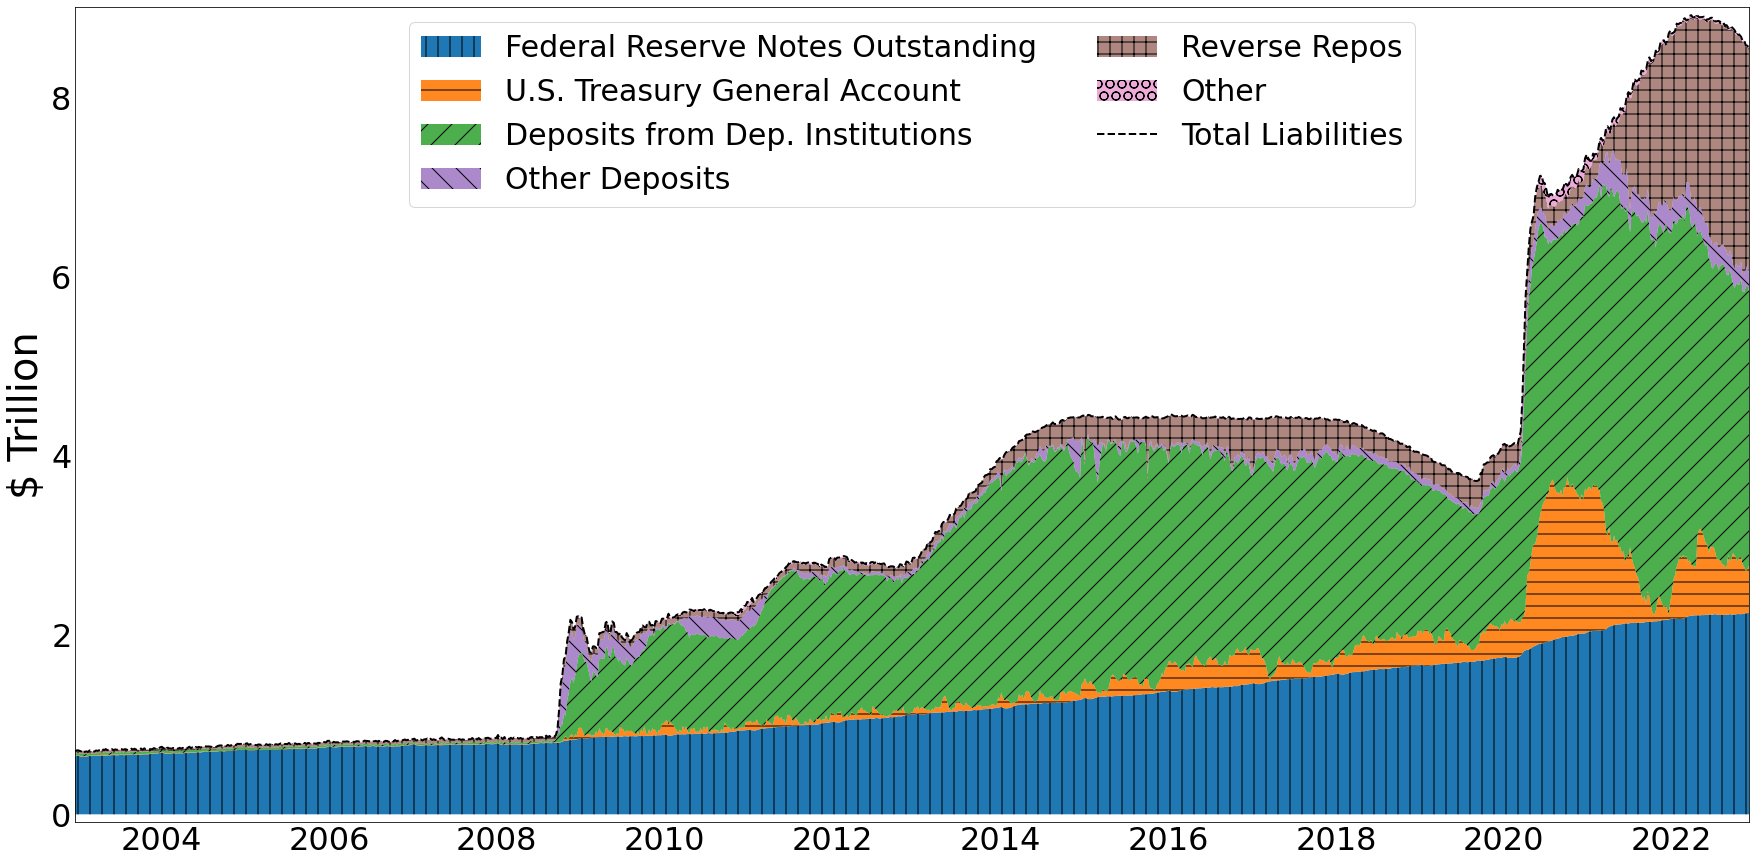

In [37]:
stack_hatch(plot_data[account_vars + [total_var]], total_var, loc = "upper center")